In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/sample_submission.csv
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/Urun Ozellikleri.xlsx
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv
/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
train = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv",encoding='utf-8',low_memory=False)
test = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv",encoding='utf-8',low_memory=False)
submission = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/sample_submission.csv",encoding='utf-8',low_memory=False)

**Train Genel Bakış**

In [5]:

def check_df(dataframe):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.isnull().sum())
    
check_df(train)


############################################
(852719, 97)
############################################
MUSTERI_ID                     object
LABEL                          object
FLAG                           object
PP_CINSIYET                     int64
PP_YAS                          int64
PP_MESLEK                      object
PP_MUSTERI_SEGMENTI             int64
PP_UYRUK                        int64
IL                              int64
SORU_YATIRIM_KARAKTERI_CVP     object
SORU_YATIRIM_KARAKTERI_RG     float64
SORU_MEDENI_HAL_CVP            object
SORU_MEDENI_HAL_RG            float64
SORU_EGITIM_CVP                object
SORU_EGITIM_RG                float64
SORU_GELIR_CVP                 object
SORU_GELIR_RG                 float64
SORU_COCUK_SAYISI_CVP         float64
SORU_COCUK_SAYISI_RG          float64
BES_AYRILMA_TALEP_ADET          int64
ODEMEME_TALEP_ADET              int64
HAYAT_AYRILMA_TALEP_ADET        int64
BILGI_TALEP_ADET                int64
VADE_TUTAR_0           

**Test Genel Bakış**

In [6]:
def check_df(dataframe):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.isnull().sum())
    
check_df(test)

############################################
(195631, 96)
############################################
MUSTERI_ID                     object
FLAG                           object
PP_CINSIYET                     int64
PP_YAS                          int64
PP_MESLEK                      object
PP_MUSTERI_SEGMENTI             int64
PP_UYRUK                        int64
IL                            float64
SORU_YATIRIM_KARAKTERI_CVP     object
SORU_YATIRIM_KARAKTERI_RG     float64
SORU_MEDENI_HAL_CVP            object
SORU_MEDENI_HAL_RG            float64
SORU_EGITIM_CVP                object
SORU_EGITIM_RG                float64
SORU_GELIR_CVP                 object
SORU_GELIR_RG                 float64
SORU_COCUK_SAYISI_CVP         float64
SORU_COCUK_SAYISI_RG          float64
BES_AYRILMA_TALEP_ADET          int64
ODEMEME_TALEP_ADET              int64
HAYAT_AYRILMA_TALEP_ADET        int64
BILGI_TALEP_ADET                int64
VADE_TUTAR_0                    int64
ODEME_TUTAR_0          

In [7]:
train['SORU_GELIR_CVP'] = train['SORU_GELIR_CVP'].str.replace(',', '.')
train['SORU_GELIR_CVP'] = train['SORU_GELIR_CVP'].astype(float)
test['SORU_GELIR_CVP'] = test['SORU_GELIR_CVP'].str.replace(',', '.')
test['SORU_GELIR_CVP'] = test['SORU_GELIR_CVP'].astype(float)

**Eksik değer sayısı %20'den fazla olanları direkt sildim**

In [8]:
train.drop(columns=['SORU_YATIRIM_KARAKTERI_RG', 'SORU_GELIR_RG', 
                    'SORU_COCUK_SAYISI_CVP', 'SORU_COCUK_SAYISI_RG', 'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 
                    'SON_CEYREK_KATKI_MIKTARI', 'SON_CEYREK_KATKI_ADET', 'SON_SENE_KATKI_MIKTARI', 'SON_SENE_KATKI_ADET'], inplace=True)
test.drop(columns=['SORU_YATIRIM_KARAKTERI_RG', 'SORU_GELIR_RG', 
                    'SORU_COCUK_SAYISI_CVP', 'SORU_COCUK_SAYISI_RG', 'SON_AY_KATKI_MIKTARI', 'SON_AY_KATKI_ADET', 
                    'SON_CEYREK_KATKI_MIKTARI', 'SON_CEYREK_KATKI_ADET', 'SON_SENE_KATKI_MIKTARI', 'SON_SENE_KATKI_ADET'], inplace=True)

**Train ve Test Datasını Kategorik ve Nümerik Columns Olarak Ayırma**

In [9]:
def grab_col_names(dataframe, cat_th=16, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes =='O']
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes !='O') & (dataframe[col].nunique() <= cat_th))]
    cat_cols = cat_cols + num_but_cat
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    return cat_cols, num_cols

In [10]:
train_cat_cols, train_num_cols = grab_col_names(train)

print(train_cat_cols)
print("#########")
print(train_num_cols)

['MUSTERI_ID', 'LABEL', 'FLAG', 'PP_MESLEK', 'SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP', 'SORU_EGITIM_CVP', 'PP_CINSIYET', 'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET', 'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09', 'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24', 'HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06', 'HU07', 'HU10', 'HU11', 'HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17', 'HU18', 'HU19']
#########
['PP_YAS', 'IL', 'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_RG', 'SORU_GELIR_CVP', 'VADE_TUTAR_0', 'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2', 'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4', 'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6', 'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8', 'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTA

In [11]:
train_cat_cols = [col for col in train_cat_cols if col not in ['MUSTERI_ID']]



In [12]:
test_cat_cols, test_num_cols = grab_col_names(test)

print(test_cat_cols)
print("#########")
print(test_num_cols)


['MUSTERI_ID', 'FLAG', 'PP_MESLEK', 'SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP', 'SORU_EGITIM_CVP', 'PP_CINSIYET', 'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET', 'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09', 'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24', 'HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06', 'HU07', 'HU10', 'HU11', 'HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17', 'HU18', 'HU19']
#########
['PP_YAS', 'IL', 'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_RG', 'SORU_GELIR_CVP', 'VADE_TUTAR_0', 'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2', 'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4', 'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6', 'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8', 'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VA

In [13]:
test_cat_cols = [col for col in test_cat_cols if col not in ['MUSTERI_ID']]
test_num_cols = test_num_cols

In [14]:
print(train_cat_cols)
print("#########")
print(train_num_cols)

['LABEL', 'FLAG', 'PP_MESLEK', 'SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP', 'SORU_EGITIM_CVP', 'PP_CINSIYET', 'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET', 'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09', 'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24', 'HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06', 'HU07', 'HU10', 'HU11', 'HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17', 'HU18', 'HU19']
#########
['PP_YAS', 'IL', 'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_RG', 'SORU_GELIR_CVP', 'VADE_TUTAR_0', 'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2', 'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4', 'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6', 'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8', 'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TU

In [15]:
print(test_cat_cols)
print("#########")
print(test_num_cols)

['FLAG', 'PP_MESLEK', 'SORU_YATIRIM_KARAKTERI_CVP', 'SORU_MEDENI_HAL_CVP', 'SORU_EGITIM_CVP', 'PP_CINSIYET', 'PP_MUSTERI_SEGMENTI', 'PP_UYRUK', 'BES_AYRILMA_TALEP_ADET', 'ODEMEME_TALEP_ADET', 'HAYAT_AYRILMA_TALEP_ADET', 'BILGI_TALEP_ADET', 'BU01', 'BU02', 'BU03', 'BU04', 'BU05', 'BU06', 'BU07', 'BU08', 'BU09', 'BU10', 'BU11', 'BU12', 'BU13', 'BU14', 'BU15', 'BU16', 'BU17', 'BU18', 'BU19', 'BU20', 'BU21', 'BU22', 'BU23', 'BU24', 'HU01', 'HU02', 'HU03', 'HU04', 'HU05', 'HU06', 'HU07', 'HU10', 'HU11', 'HU12', 'HU13', 'HU14', 'HU15', 'HU16', 'HU17', 'HU18', 'HU19']
#########
['PP_YAS', 'IL', 'SORU_MEDENI_HAL_RG', 'SORU_EGITIM_RG', 'SORU_GELIR_CVP', 'VADE_TUTAR_0', 'ODEME_TUTAR_0', 'VADE_TUTAR_1', 'ODEME_TUTAR_1', 'VADE_TUTAR_2', 'ODEME_TUTAR_2', 'VADE_TUTAR_3', 'ODEME_TUTAR_3', 'VADE_TUTAR_4', 'ODEME_TUTAR_4', 'VADE_TUTAR_5', 'ODEME_TUTAR_5', 'VADE_TUTAR_6', 'ODEME_TUTAR_6', 'VADE_TUTAR_7', 'ODEME_TUTAR_7', 'VADE_TUTAR_8', 'ODEME_TUTAR_8', 'VADE_TUTAR_9', 'ODEME_TUTAR_9', 'VADE_TUTAR_10', 

        LABEL  Ratio
LABEL               
UA     832770 97.661
HU14    10754  1.261
HU07     3728  0.437
HU06     3178  0.373
HU19      759  0.089
HU12      676  0.079
HU11      439  0.051
HU15      415  0.049


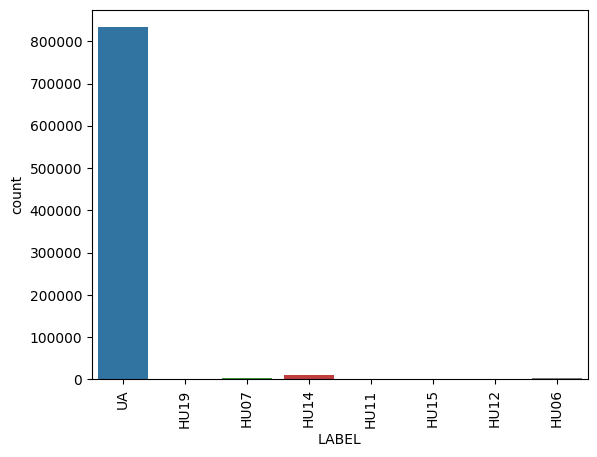

           FLAG  Ratio
FLAG                  
HAZIRAN  252193 29.575
MAYIS    246389 28.895
EKIM      93766 10.996
EYLUL     89170 10.457
TEMMUZ    86460 10.139
AGUSTOS   84741  9.938


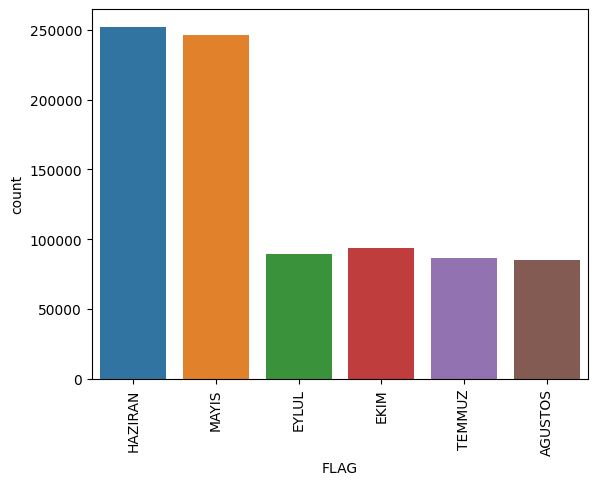

                                            PP_MESLEK  Ratio
PP_MESLEK                                                   
İşçi                                           138034 16.188
Öğrenci                                        102557 12.027
Ev Hanımı                                      102011 11.963
Diğer                                           97803 11.470
Öğretmen                                        33926  3.979
Esnaf                                           30173  3.538
Memur                                           29595  3.471
Serbest Meslek                                  27226  3.193
Mühendis                                        18694  2.192
Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)      12942  1.518
Danışman                                         8872  1.040
SSK-Sosyal Sigortalar Kurumu Emeklileri          8284  0.971
Emekli                                           7886  0.925
Akademisyen                                      7468  0.876
Banka                   

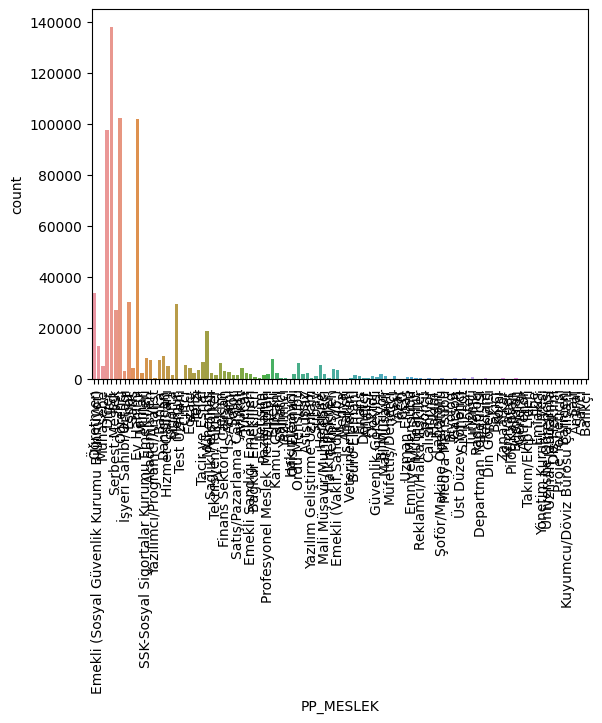

                            SORU_YATIRIM_KARAKTERI_CVP  Ratio
SORU_YATIRIM_KARAKTERI_CVP                                   
Temkinli                                         35414  4.153
Cesur                                            33284  3.903
Dengeli                                          26181  3.070
Yetkin                                           19402  2.275
Bilge                                            18417  2.160


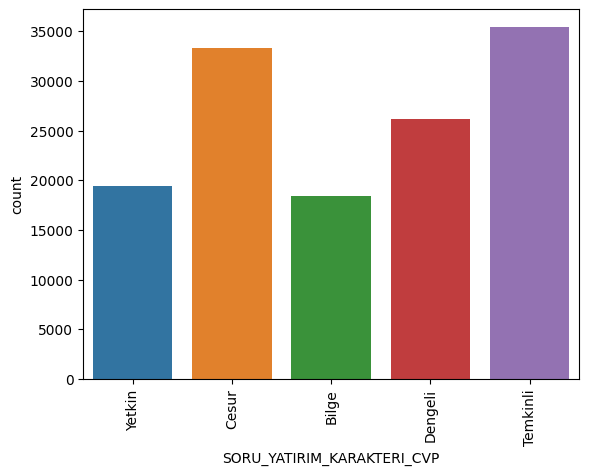

                     SORU_MEDENI_HAL_CVP  Ratio
SORU_MEDENI_HAL_CVP                            
Married                           476413 55.870
Single                            342321 40.145
Divorced                           25346  2.972
Widowed                             6837  0.802
Other                                 14  0.002
Marriage Cancelled                     6  0.001
Marriage Annulled                      2  0.000


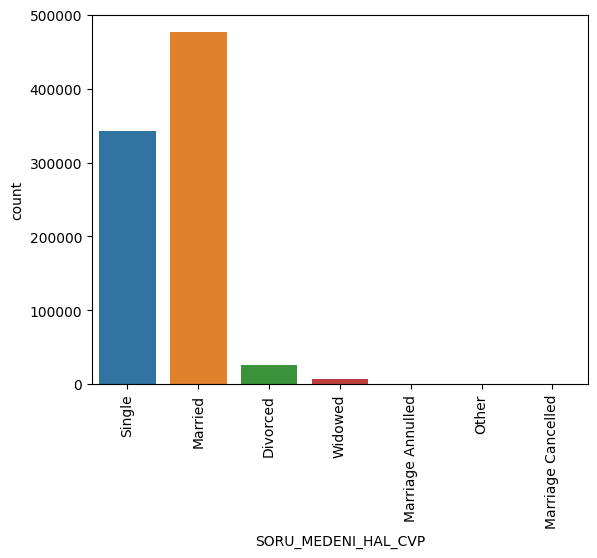

                 SORU_EGITIM_CVP  Ratio
SORU_EGITIM_CVP                        
Lise                      240689 28.226
Lisans                    212010 24.863
(Diğer)                   136355 15.991
İlköğretim                 97849 11.475
Yüksek Lisans              19113  2.241
Önlisans                   15851  1.859
Doktora                     3757  0.441


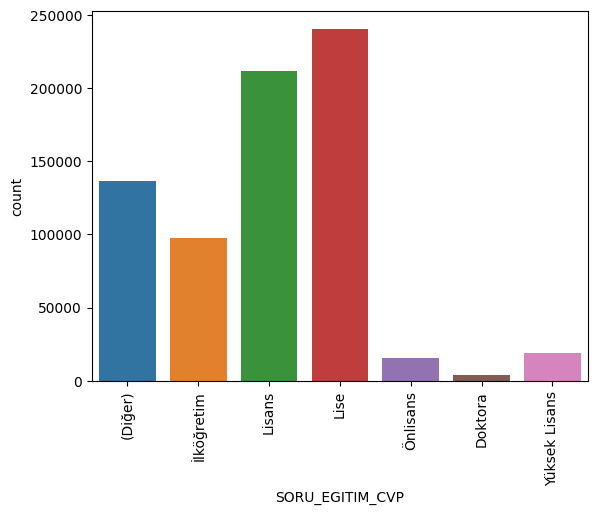

             PP_CINSIYET  Ratio
PP_CINSIYET                    
1                 431283 50.577
2                 421436 49.423


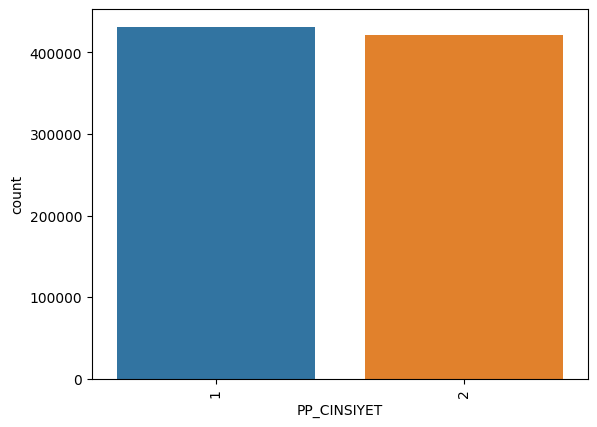

                     PP_MUSTERI_SEGMENTI  Ratio
PP_MUSTERI_SEGMENTI                            
106                               370063 43.398
105                               196927 23.094
102                               107096 12.559
104                                89176 10.458
103                                88645 10.396
101                                  812  0.095


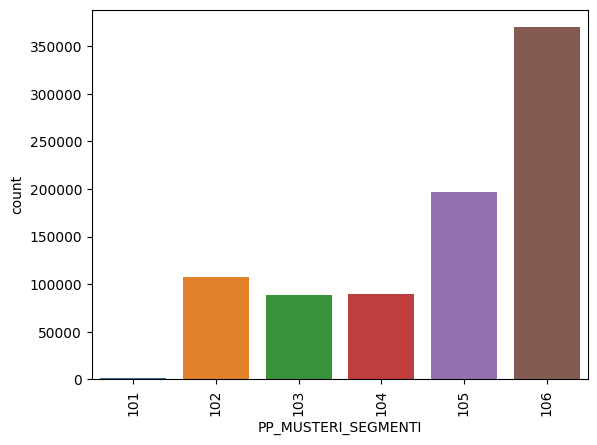

          PP_UYRUK  Ratio
PP_UYRUK                 
1           848335 99.486
2             2570  0.301
3             1814  0.213


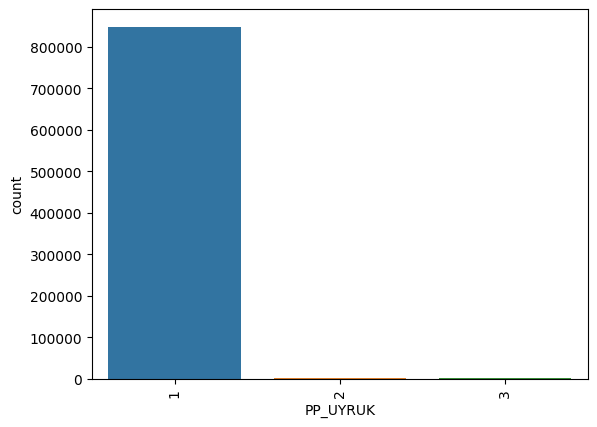

                        BES_AYRILMA_TALEP_ADET  Ratio
BES_AYRILMA_TALEP_ADET                               
0                                       845024 99.098
1                                         6788  0.796
2                                          781  0.092
3                                           97  0.011
4                                           24  0.003
5                                            3  0.000
7                                            1  0.000
8                                            1  0.000


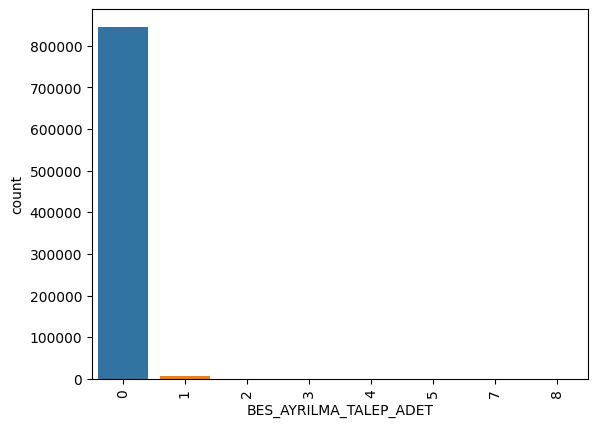

                    ODEMEME_TALEP_ADET  Ratio
ODEMEME_TALEP_ADET                           
0                               852424 99.965
1                                  251  0.029
2                                   36  0.004
3                                    7  0.001
4                                    1  0.000


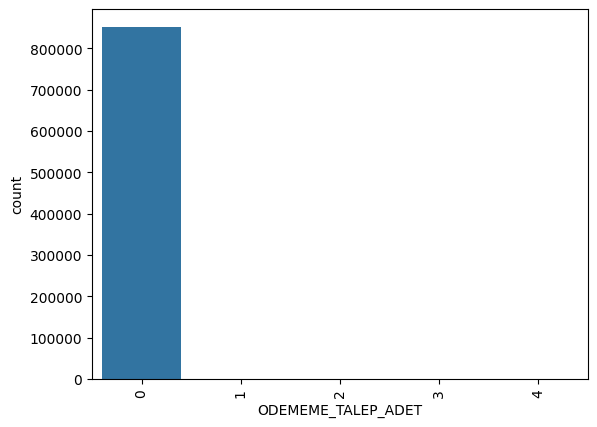

                          HAYAT_AYRILMA_TALEP_ADET  Ratio
HAYAT_AYRILMA_TALEP_ADET                                 
0                                           852292 99.950
1                                              379  0.044
2                                               43  0.005
4                                                3  0.000
5                                                1  0.000
3                                                1  0.000


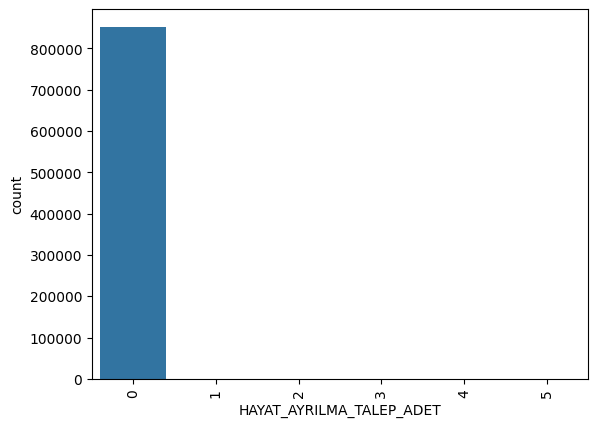

                  BILGI_TALEP_ADET  Ratio
BILGI_TALEP_ADET                         
0                           851585 99.867
1                              967  0.113
2                               68  0.008
3                               18  0.002
7                               17  0.002
10                              15  0.002
8                               11  0.001
4                                9  0.001
9                                9  0.001
6                                7  0.001
11                               6  0.001
5                                6  0.001
12                               1  0.000


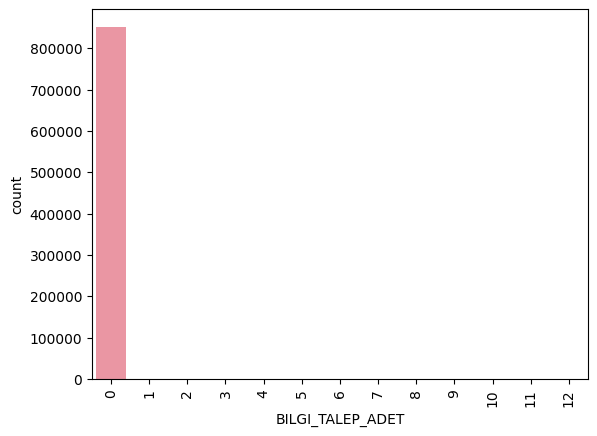

        BU01  Ratio
BU01               
0     813563 95.408
1      38909  4.563
2        231  0.027
3         14  0.002
4          2  0.000


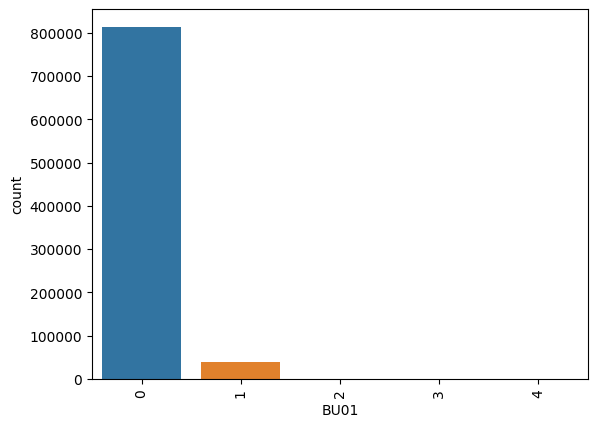

        BU02  Ratio
BU02               
0     776505 91.062
1      72917  8.551
2       3137  0.368
3        135  0.016
4         20  0.002
5          3  0.000
6          2  0.000


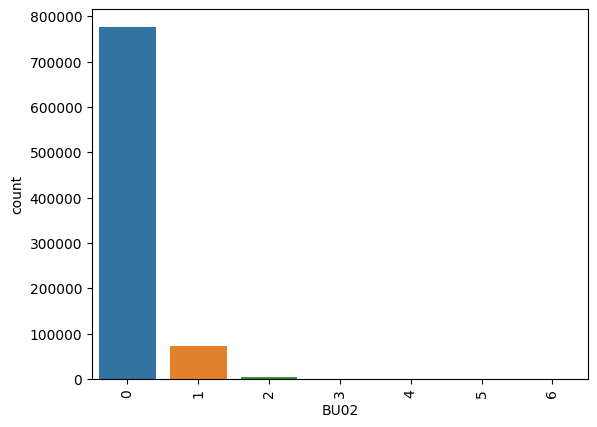

        BU03  Ratio
BU03               
0     847067 99.337
1       5485  0.643
2        147  0.017
3         17  0.002
4          3  0.000


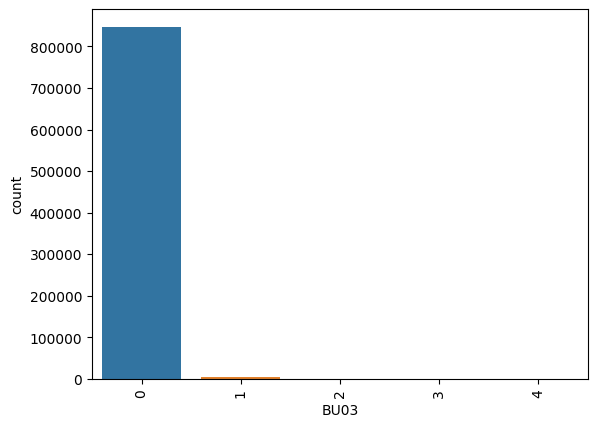

        BU04  Ratio
BU04               
0     852128 99.931
1        575  0.067
2         11  0.001
3          4  0.000
4          1  0.000


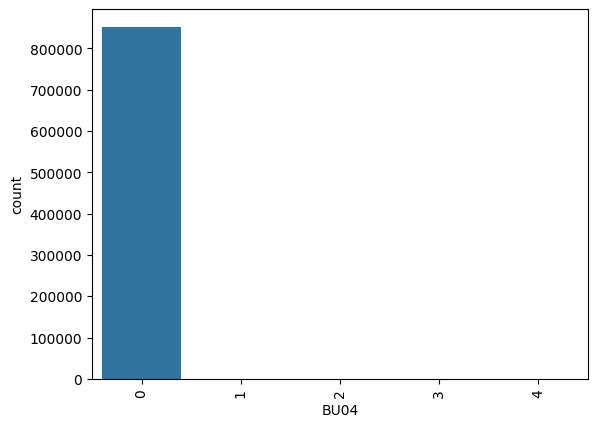

        BU05  Ratio
BU05               
0     852456 99.969
1        244  0.029
2         19  0.002


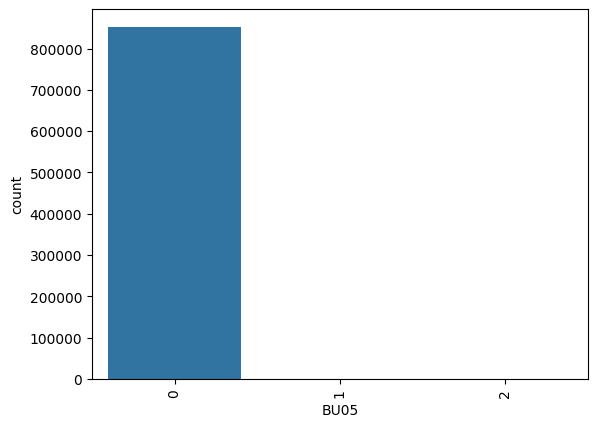

        BU06   Ratio
BU06                
0     852716 100.000
1          3   0.000


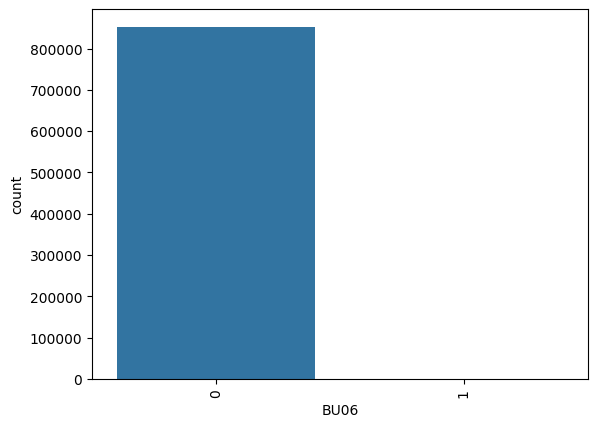

        BU07  Ratio
BU07               
0     848405 99.494
1       4146  0.486
2        146  0.017
3         18  0.002
4          2  0.000
6          1  0.000
5          1  0.000


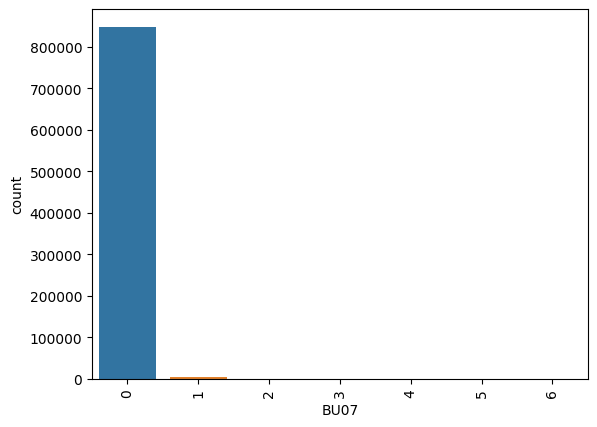

        BU08  Ratio
BU08               
0     773916 90.759
1      74305  8.714
2       4079  0.478
3        358  0.042
4         48  0.006
5         10  0.001
6          1  0.000
7          1  0.000
8          1  0.000


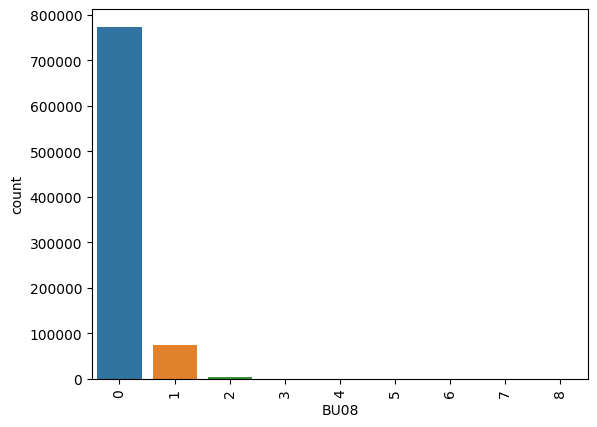

        BU09  Ratio
BU09               
0     722985 84.786
1     114760 13.458
2      12482  1.464
3       1840  0.216
4        439  0.051
5        134  0.016
6         37  0.004
7         21  0.002
8          8  0.001
10         4  0.000
11         3  0.000
12         2  0.000
13         1  0.000
17         1  0.000
9          1  0.000
36         1  0.000


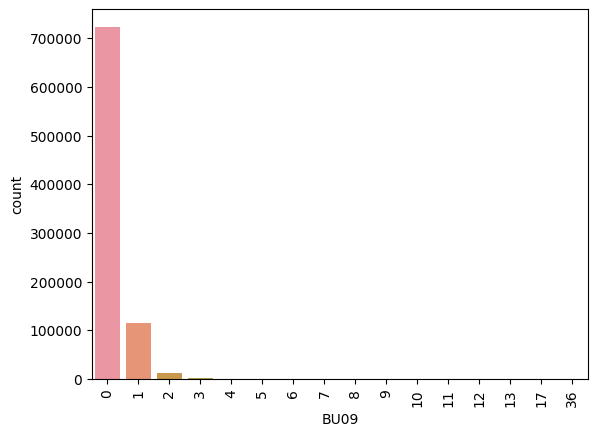

        BU10  Ratio
BU10               
0     817082 95.821
1      34088  3.998
2       1323  0.155
3        173  0.020
4         38  0.004
5         11  0.001
8          2  0.000
6          2  0.000


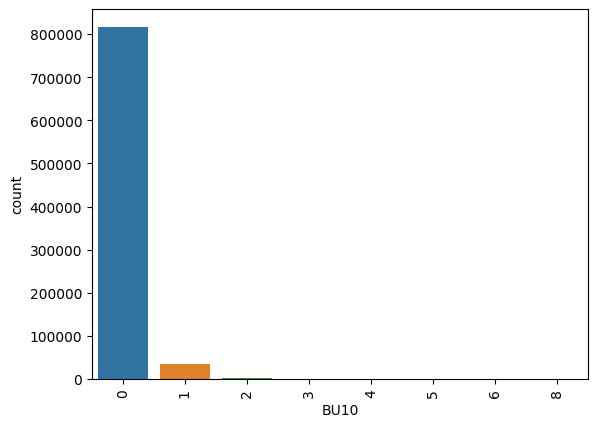

        BU11  Ratio
BU11               
0     794754 93.202
1      49519  5.807
2       7476  0.877
3        811  0.095
4        126  0.015
5         23  0.003
6          5  0.001
8          3  0.000
11         1  0.000
7          1  0.000


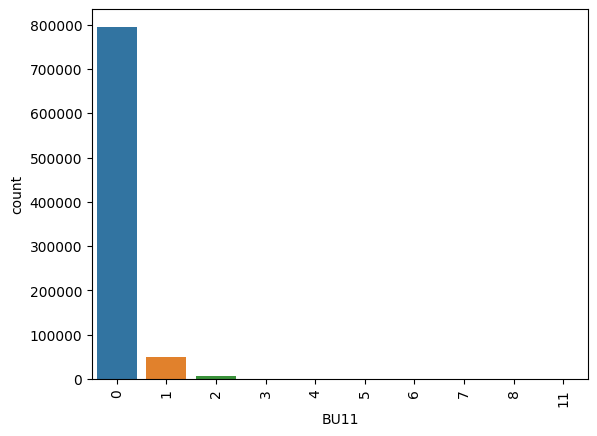

        BU12  Ratio
BU12               
0     852710 99.999
1          9  0.001


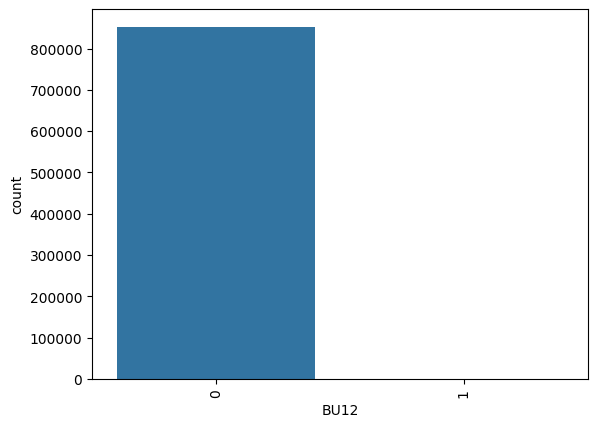

        BU13  Ratio
BU13               
0     815838 95.675
1      33289  3.904
2       2998  0.352
3        422  0.049
4        103  0.012
5         40  0.005
6         12  0.001
7          6  0.001
8          4  0.000
11         3  0.000
9          2  0.000
12         1  0.000
22         1  0.000


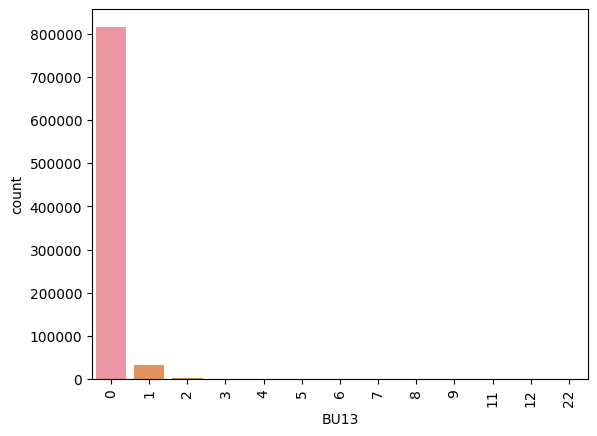

        BU14  Ratio
BU14               
0     852472 99.971
1        214  0.025
2         28  0.003
3          4  0.000
4          1  0.000


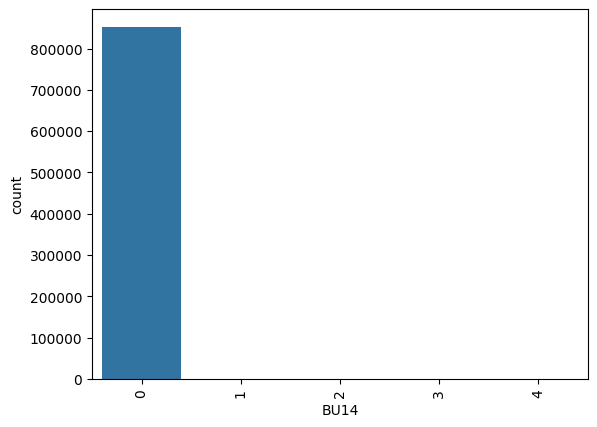

        BU15  Ratio
BU15               
0     851931 99.908
1        744  0.087
2         44  0.005


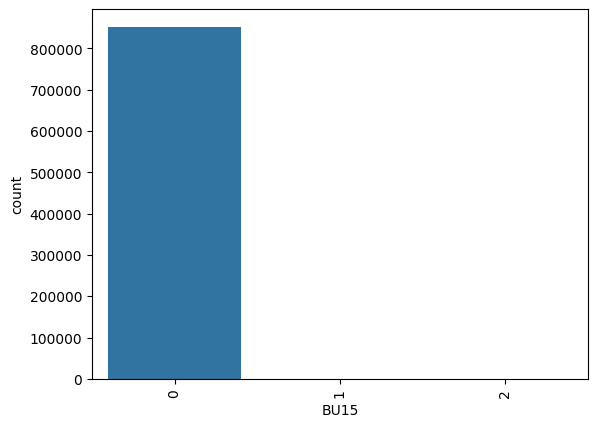

        BU16  Ratio
BU16               
0     761642 89.319
1      81329  9.538
2       8552  1.003
3        976  0.114
4        174  0.020
5         29  0.003
6         10  0.001
10         2  0.000
8          2  0.000
13         1  0.000
7          1  0.000
12         1  0.000


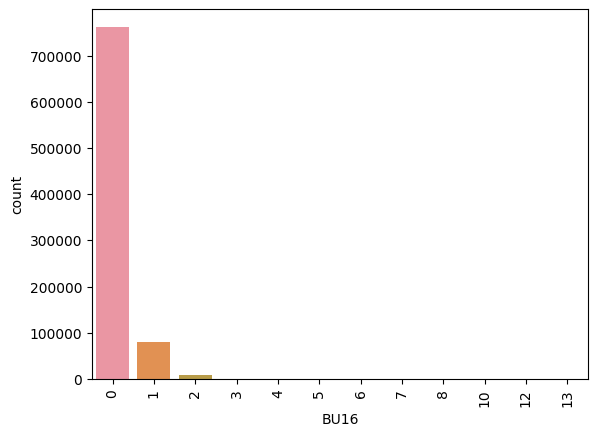

        BU17  Ratio
BU17               
0     702151 82.343
1     133720 15.682
2      14634  1.716
3       1809  0.212
4        322  0.038
5         52  0.006
6         19  0.002
7          4  0.000
11         2  0.000
10         2  0.000
9          2  0.000
8          2  0.000


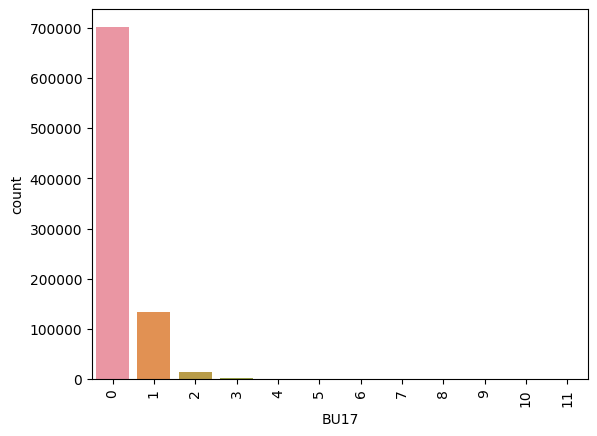

        BU18  Ratio
BU18               
0     845327 99.133
1       7042  0.826
2        317  0.037
3         30  0.004
4          2  0.000
5          1  0.000


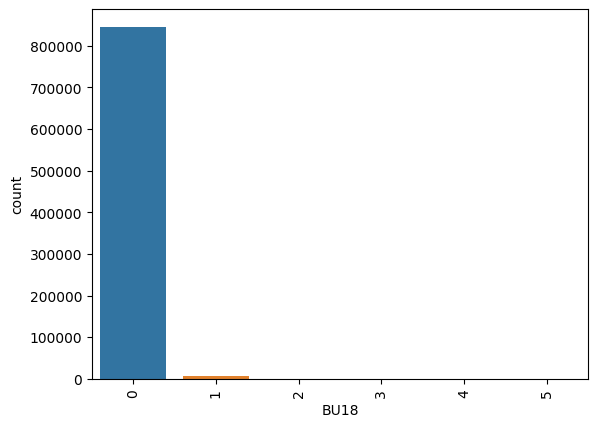

        BU19  Ratio
BU19               
0     817861 95.912
1      28907  3.390
2       4616  0.541
3        979  0.115
4        237  0.028
5         82  0.010
6         17  0.002
7         11  0.001
8          7  0.001
10         1  0.000
9          1  0.000


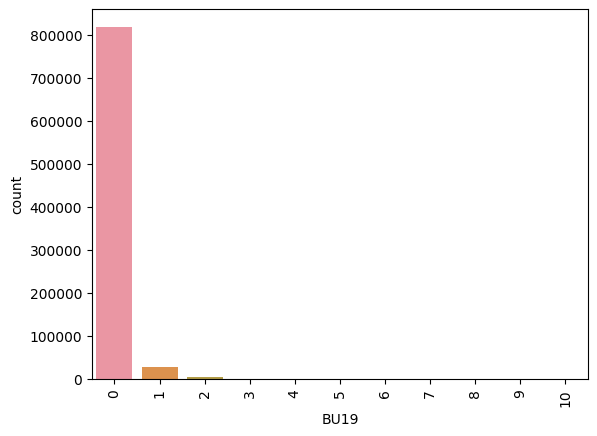

        BU20  Ratio
BU20               
0     832227 97.597
1      19829  2.325
2        578  0.068
3         59  0.007
4         16  0.002
5          6  0.001
6          3  0.000
8          1  0.000


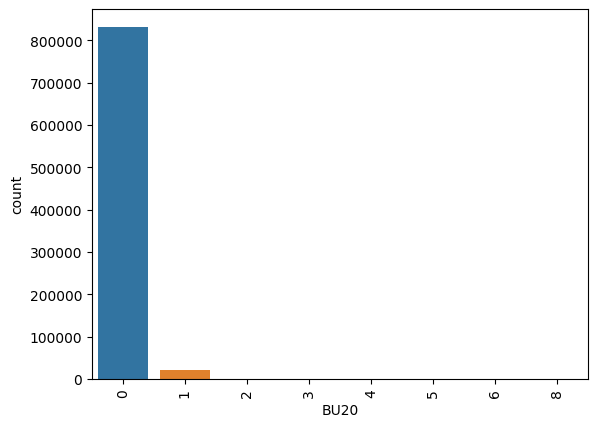

        BU21  Ratio
BU21               
0     849182 99.585
1       3451  0.405
2         73  0.009
3          7  0.001
4          4  0.000
5          1  0.000
8          1  0.000


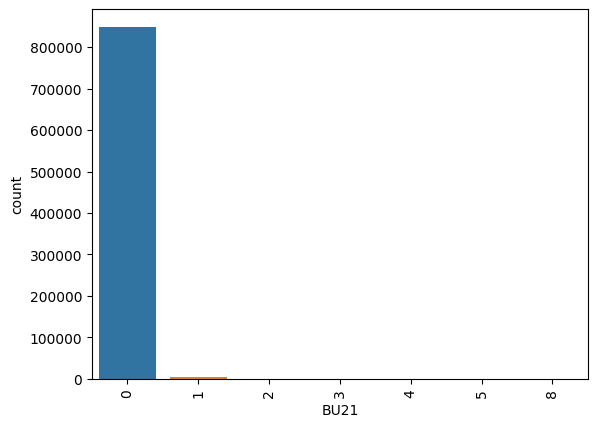

        BU22  Ratio
BU22               
0     851837 99.897
1        840  0.099
2         38  0.004
3          3  0.000
4          1  0.000


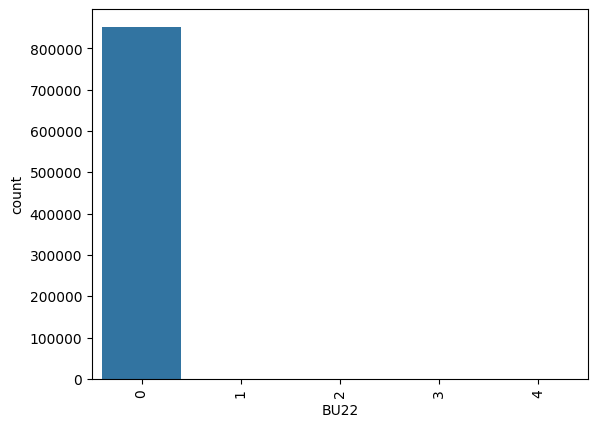

        BU23  Ratio
BU23               
0     703866 82.544
1     143842 16.869
2       4792  0.562
3        187  0.022
4         29  0.003
5          3  0.000


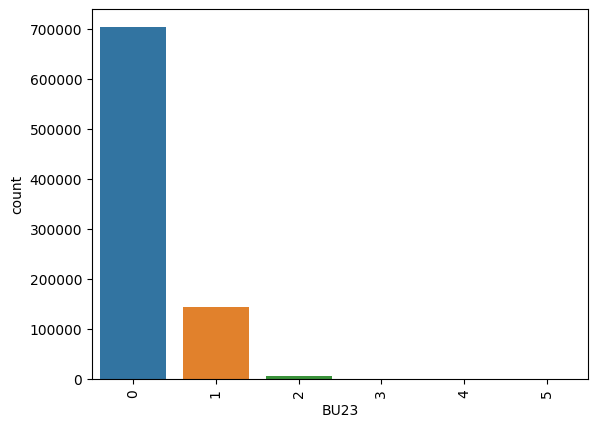

        BU24  Ratio
BU24               
0     828300 97.136
1      23401  2.744
2        982  0.115
3         35  0.004
4          1  0.000


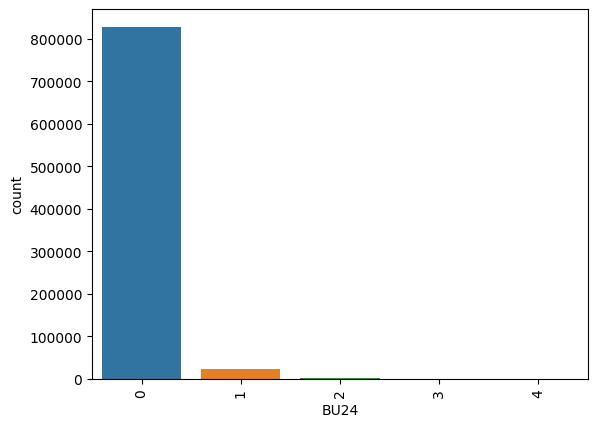

        HU01  Ratio
HU01               
0     852510 99.975
1        194  0.023
2         10  0.001
10         4  0.000
5          1  0.000


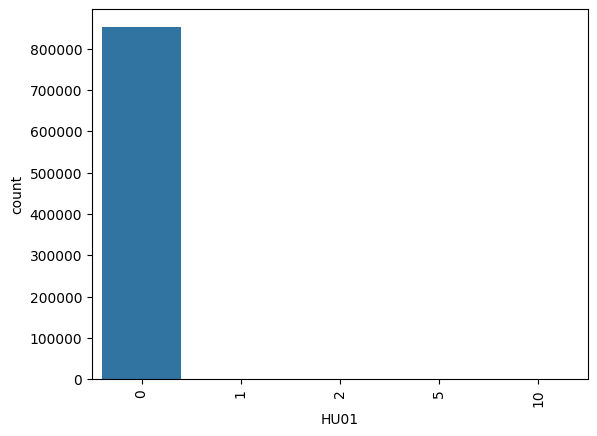

        HU02  Ratio
HU02               
0     852703 99.998
1         16  0.002


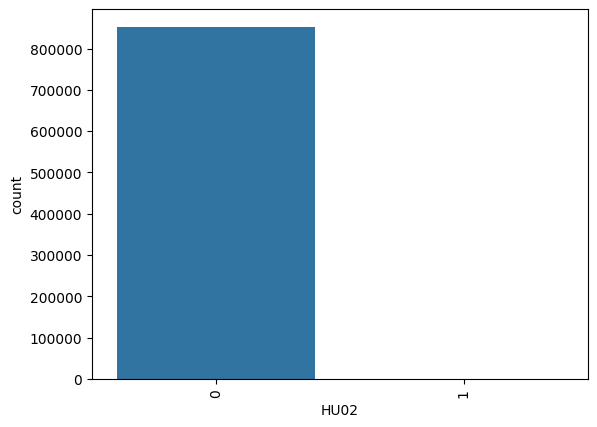

        HU03  Ratio
HU03               
0     852185 99.937
1        466  0.055
2         48  0.006
3          9  0.001
4          7  0.001
5          1  0.000
9          1  0.000
8          1  0.000
6          1  0.000


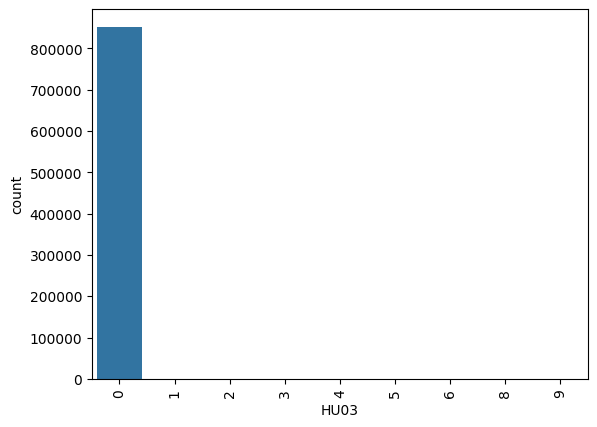

        HU04  Ratio
HU04               
0     843410 98.908
1       9283  1.089
2         26  0.003


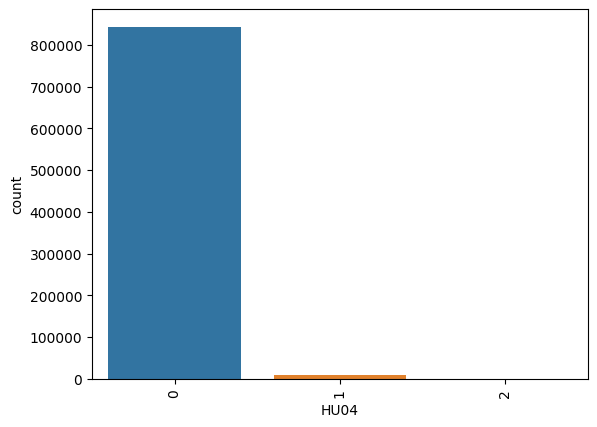

        HU05  Ratio
HU05               
0     848816 99.542
2       3817  0.448
1         86  0.010


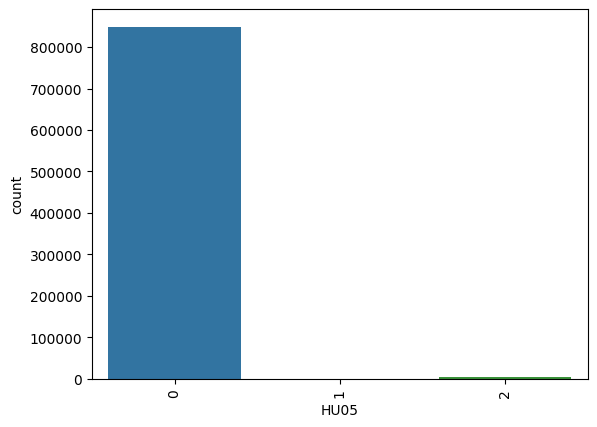

        HU06  Ratio
HU06               
0     840395 98.555
1      11036  1.294
2       1111  0.130
3        124  0.015
4         40  0.005
5          8  0.001
6          4  0.000
9          1  0.000


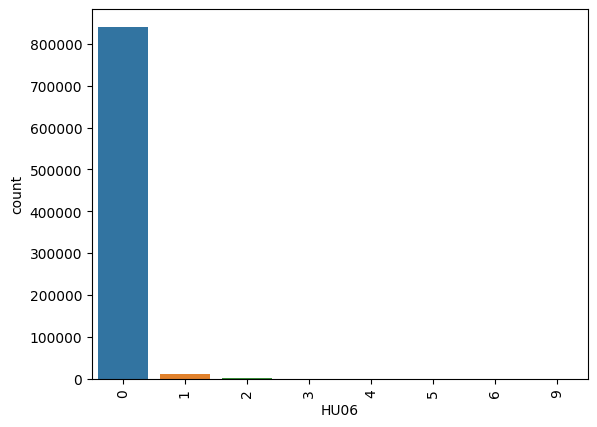

        HU07  Ratio
HU07               
0     847069 99.337
1       5650  0.663


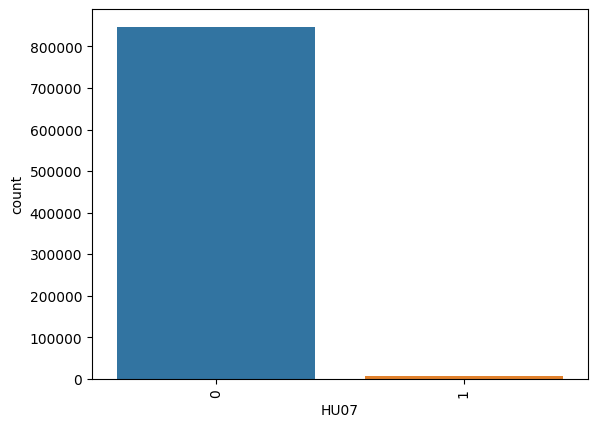

        HU10  Ratio
HU10               
0     848621 99.519
1       3769  0.442
2        313  0.037
3         14  0.002
8          1  0.000
4          1  0.000


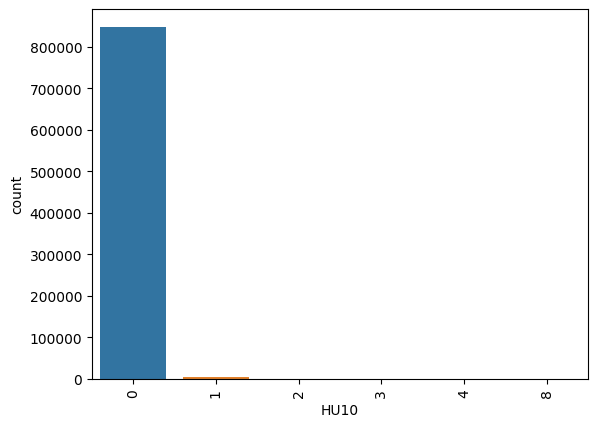

        HU11  Ratio
HU11               
0     850903 99.787
1       1659  0.195
2        130  0.015
3         21  0.002
4          4  0.000
5          2  0.000


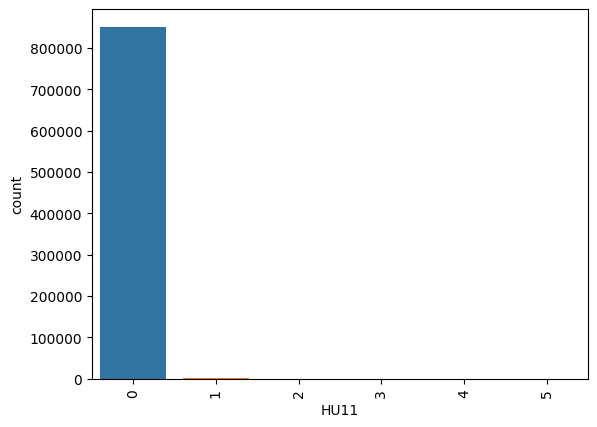

        HU12  Ratio
HU12               
0     851963 99.911
1        711  0.083
2         39  0.005
3          4  0.000
4          1  0.000
5          1  0.000


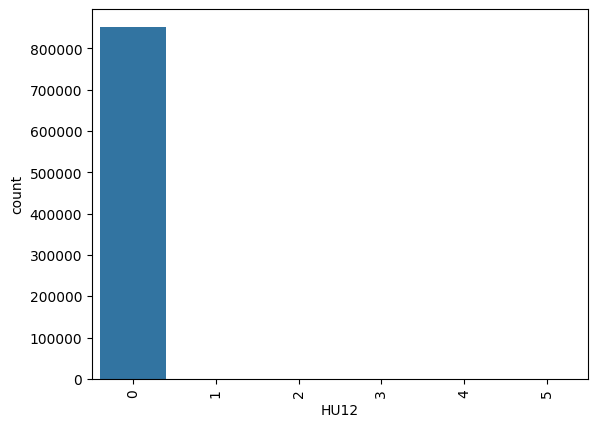

        HU13  Ratio
HU13               
0     852634 99.990
1         85  0.010


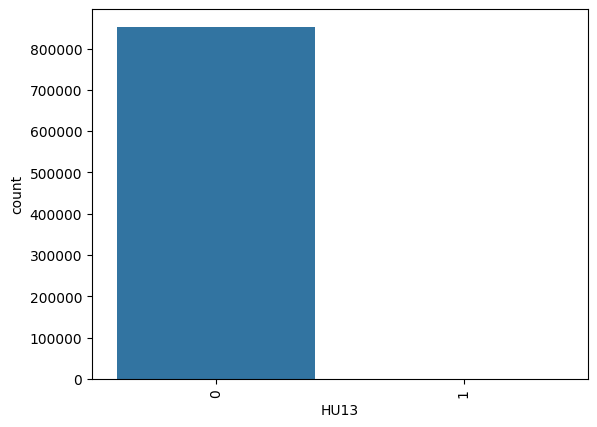

        HU14  Ratio
HU14               
0     836299 98.074
1      15676  1.838
2        604  0.071
3         99  0.012
4         28  0.003
5          8  0.001
9          2  0.000
7          2  0.000
8          1  0.000


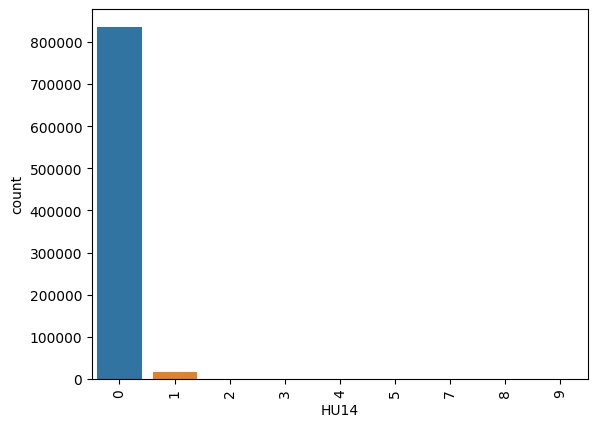

        HU15  Ratio
HU15               
0     852063 99.923
1        655  0.077
2          1  0.000


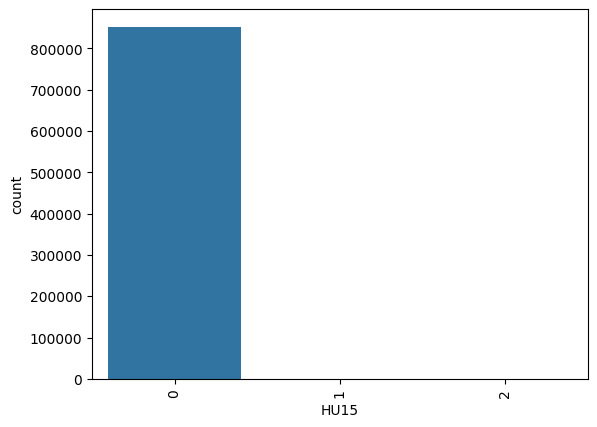

        HU16  Ratio
HU16               
0     852398 99.962
1        300  0.035
2         20  0.002
3          1  0.000


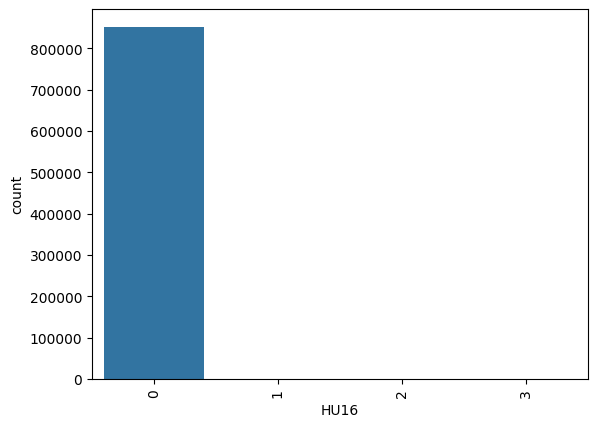

        HU17  Ratio
HU17               
0     845241 99.123
1       5585  0.655
2       1204  0.141
3        402  0.047
4        143  0.017
5         58  0.007
6         33  0.004
7         20  0.002
8         12  0.001
9          8  0.001
10         4  0.000
13         3  0.000
12         3  0.000
11         2  0.000
15         1  0.000


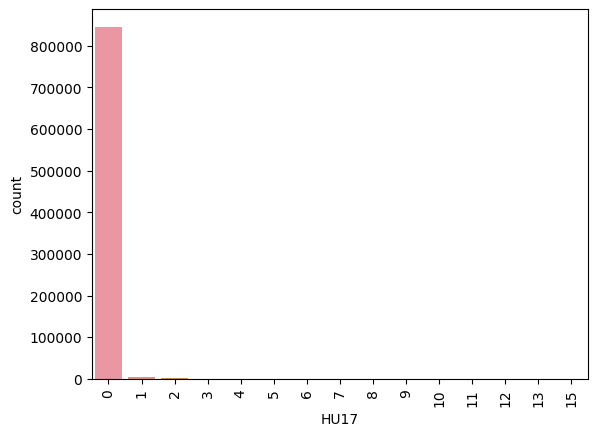

        HU18  Ratio
HU18               
0     835805 98.016
1      16841  1.975
2         71  0.008
3          2  0.000


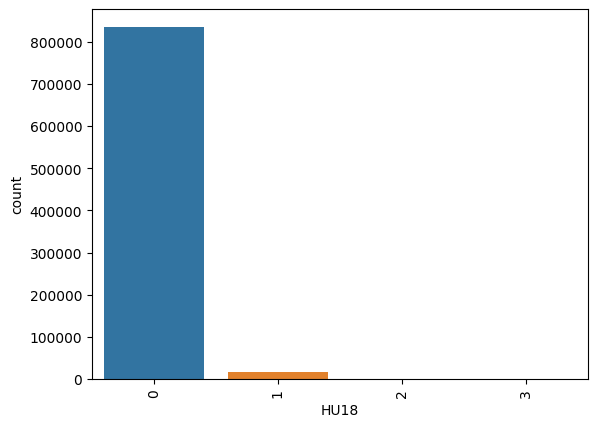

        HU19  Ratio
HU19               
0     847692 99.410
1       4524  0.531
2        336  0.039
3         97  0.011
4         32  0.004
5         16  0.002
6         10  0.001
7          7  0.001
8          4  0.000
10         1  0.000


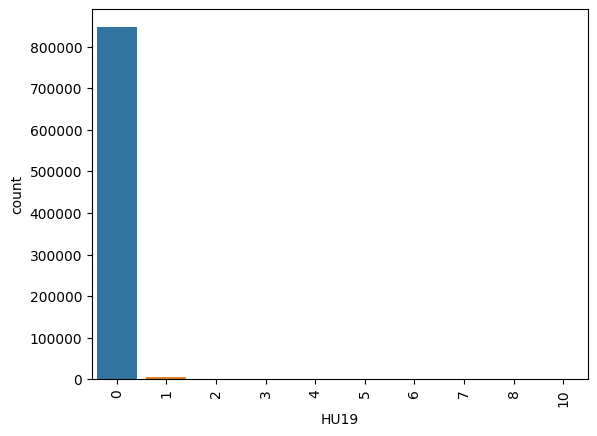

In [16]:

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe[col_name])}))
    
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation=90)
        plt.show()
        
for col in train_cat_cols:
    cat_summary(train, col, True)


count   852719.000
mean       440.773
std        205.058
min          0.000
5%          58.000
10%        108.000
20%        269.000
30%        355.000
40%        419.000
50%        470.000
60%        515.000
70%        559.000
80%        612.000
90%        685.000
95%        744.000
99%        858.000
100%      1474.000
max       1474.000
Name: PP_YAS, dtype: float64


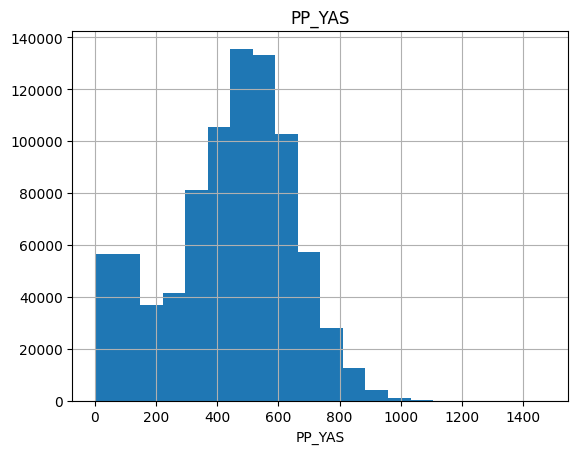

count   852719.000
mean        31.022
std         18.435
min          0.000
5%           6.000
10%          6.000
20%          9.000
30%         20.000
40%         33.000
50%         34.000
60%         34.000
70%         35.000
80%         43.000
90%         57.000
95%         65.000
99%         78.000
100%        81.000
max         81.000
Name: IL, dtype: float64


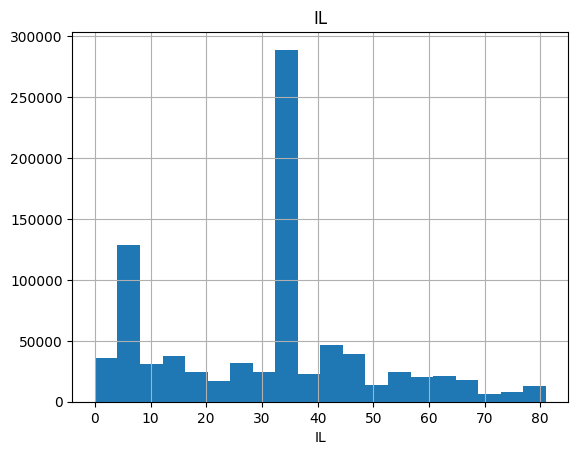

count   850939.000
mean        87.329
std         69.144
min          0.000
5%           5.000
10%         10.000
20%         18.000
30%         33.000
40%         56.000
50%         78.000
60%         96.000
70%        113.000
80%        147.000
90%        197.000
95%        234.000
99%        238.000
100%      1482.000
max       1482.000
Name: SORU_MEDENI_HAL_RG, dtype: float64


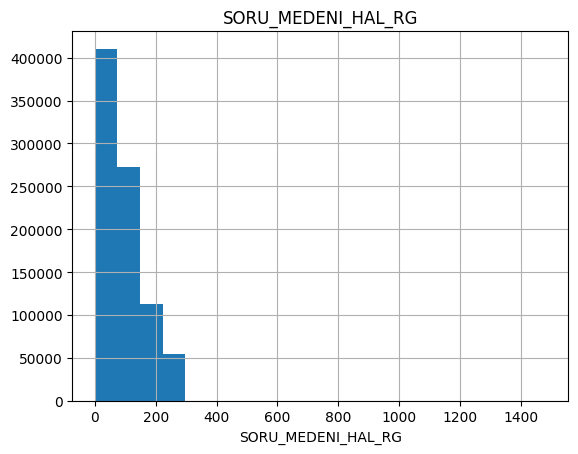

count   725624.000
mean        84.778
std         71.031
min          0.000
5%           5.000
10%          9.000
20%         17.000
30%         28.000
40%         49.000
50%         68.000
60%         91.000
70%        111.000
80%        146.000
90%        203.000
95%        234.000
99%        238.000
100%      1482.000
max       1482.000
Name: SORU_EGITIM_RG, dtype: float64


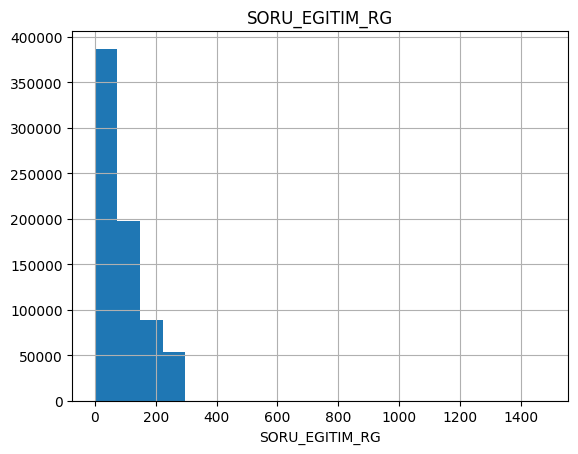

count       574817.000
mean         32999.606
std        8741361.593
min             -4.000
5%               0.000
10%              0.000
20%            500.000
30%           1400.000
40%           2000.000
50%           3000.000
60%           4000.000
70%           5000.000
80%           7500.000
90%          15000.000
95%          20000.000
99%          60000.000
100%    5353908482.000
max     5353908482.000
Name: SORU_GELIR_CVP, dtype: float64


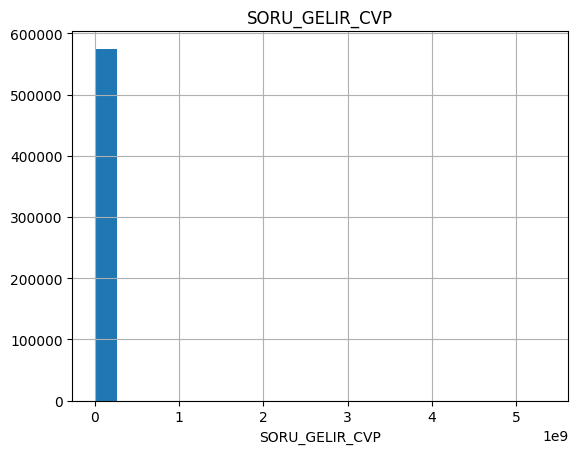

count   852719.000
mean      1167.957
std       4294.030
min          0.000
5%         317.000
10%        325.000
20%        373.000
30%        449.000
40%        497.000
50%        574.000
60%        679.000
70%        851.000
80%       1014.000
90%       1770.000
95%       3272.000
99%       9570.000
100%    229680.000
max     229680.000
Name: VADE_TUTAR_0, dtype: float64


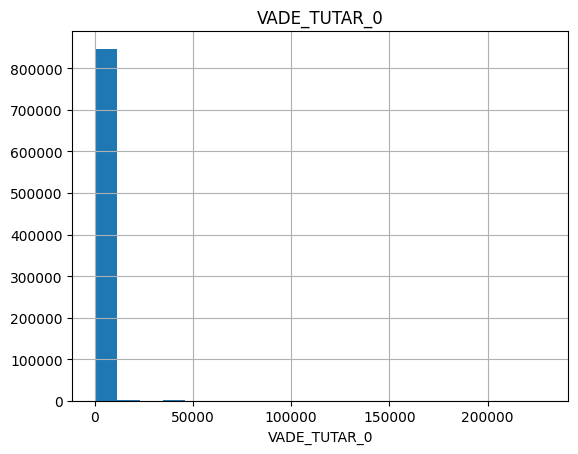

count   852719.000
mean       687.891
std       3201.322
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        334.000
60%        435.000
70%        564.000
80%        765.000
90%       1301.000
95%       2210.000
99%       6699.000
100%    229680.000
max     229680.000
Name: ODEME_TUTAR_0, dtype: float64


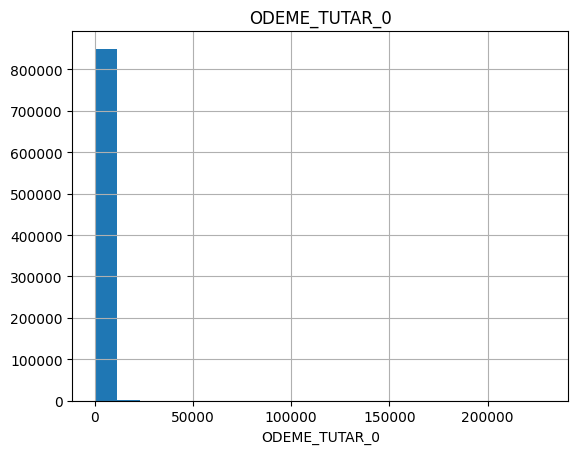

count   852719.000
mean       895.148
std       1296.980
min          0.000
5%         306.000
10%        325.000
20%        354.000
30%        430.000
40%        478.000
50%        564.000
60%        660.000
70%        851.000
80%        957.000
90%       1588.000
95%       2660.000
99%       6670.000
100%    153120.000
max     153120.000
Name: VADE_TUTAR_1, dtype: float64


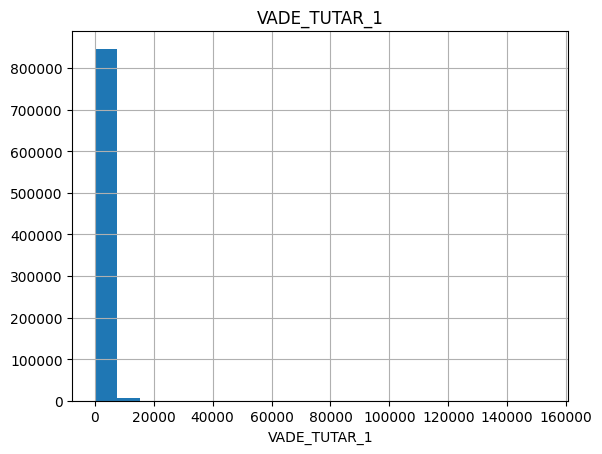

count   852719.000
mean       601.842
std       1203.735
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%        287.000
50%        353.000
60%        459.000
70%        574.000
80%        791.000
90%       1320.000
95%       2153.000
99%       5742.000
100%    153120.000
max     153120.000
Name: ODEME_TUTAR_1, dtype: float64


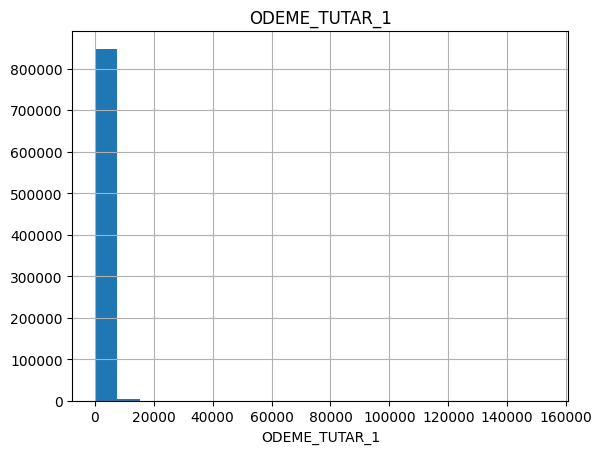

count   852719.000
mean       870.184
std       1250.229
min          0.000
5%         191.000
10%        317.000
20%        353.000
30%        430.000
40%        478.000
50%        535.000
60%        660.000
70%        832.000
80%        957.000
90%       1540.000
95%       2583.000
99%       6471.460
100%    115902.000
max     115902.000
Name: VADE_TUTAR_2, dtype: float64


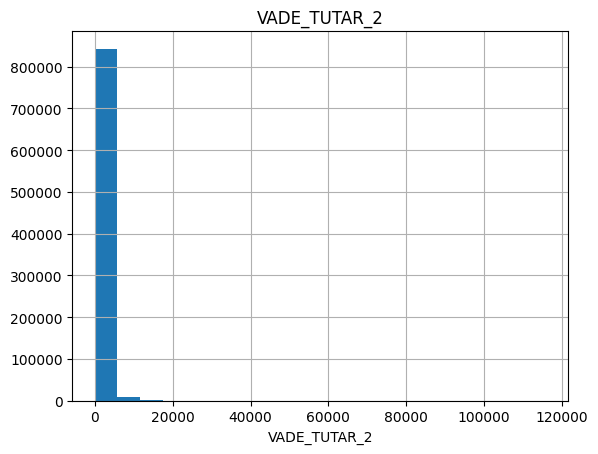

count   852719.000
mean       595.239
std       1175.512
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%        287.000
50%        353.000
60%        449.000
70%        574.000
80%        784.000
90%       1291.000
95%       2134.000
99%       5560.000
100%    115902.000
max     115902.000
Name: ODEME_TUTAR_2, dtype: float64


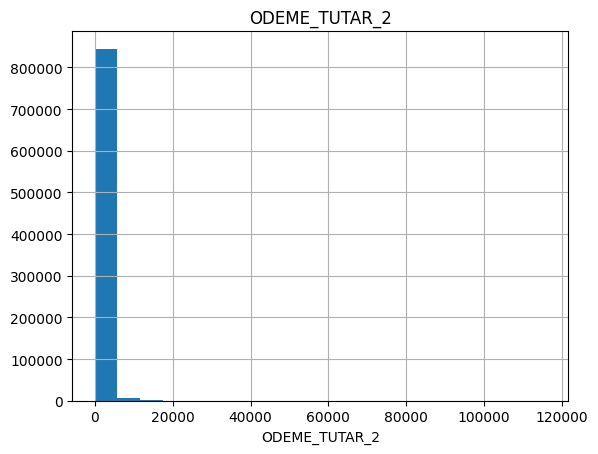

count   852719.000
mean       868.939
std       1264.732
min          0.000
5%           0.000
10%        317.000
20%        353.000
30%        430.000
40%        478.000
50%        535.000
60%        660.000
70%        832.000
80%        957.000
90%       1579.000
95%       2636.000
99%       6545.000
100%    160709.000
max     160709.000
Name: VADE_TUTAR_3, dtype: float64


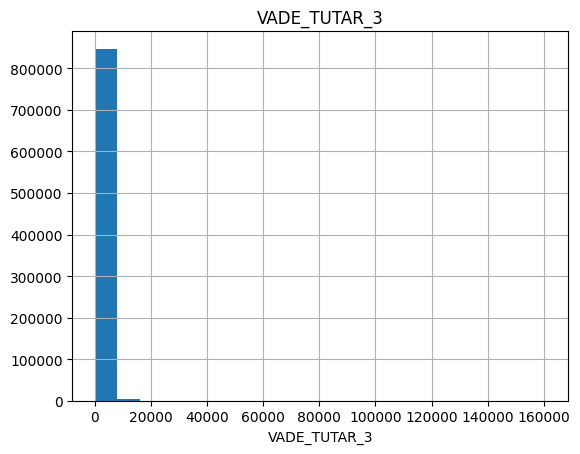

count   852719.000
mean       594.899
std       1169.151
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%        240.000
50%        353.000
60%        449.000
70%        574.000
80%        784.000
90%       1301.000
95%       2153.000
99%       5598.000
100%     66990.000
max      66990.000
Name: ODEME_TUTAR_3, dtype: float64


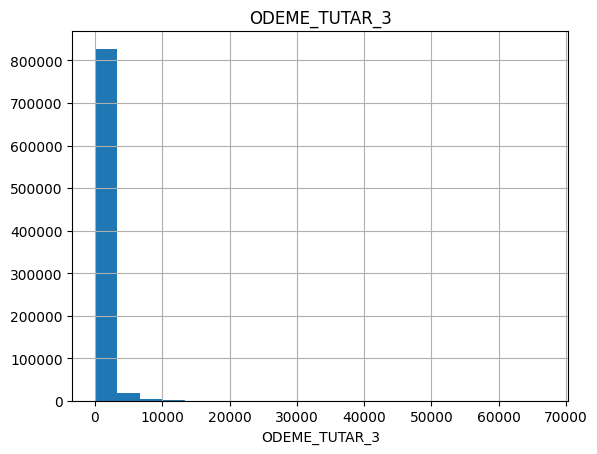

count   852719.000
mean       756.091
std       1135.880
min          0.000
5%           0.000
10%        174.000
20%        306.000
30%        353.000
40%        430.000
50%        478.000
60%        574.000
70%        689.000
80%        890.000
90%       1378.000
95%       2201.000
99%       5541.000
100%    101010.000
max     101010.000
Name: VADE_TUTAR_4, dtype: float64


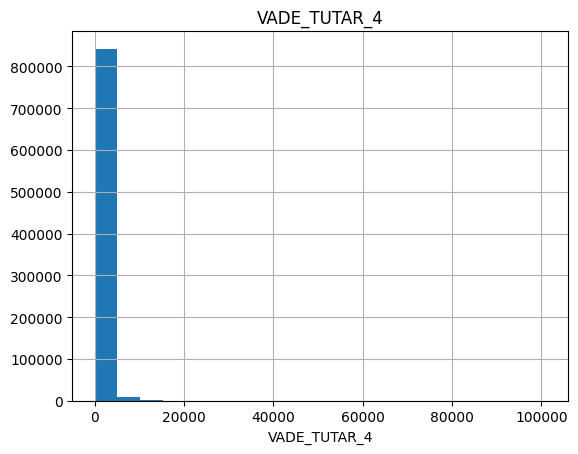

count   852719.000
mean       526.194
std       1073.710
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        317.000
60%        388.000
70%        511.000
80%        689.000
90%       1148.000
95%       1914.000
99%       5078.640
100%    101010.000
max     101010.000
Name: ODEME_TUTAR_4, dtype: float64


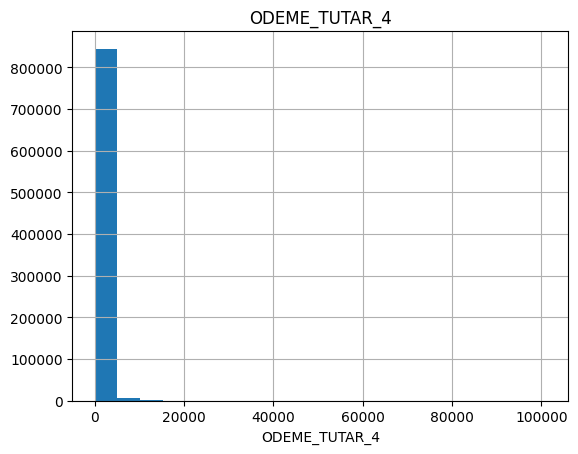

count   852719.000
mean       621.828
std        975.825
min          0.000
5%           0.000
10%        129.000
20%        210.000
30%        267.000
40%        325.000
50%        392.000
60%        468.000
70%        571.000
80%        765.000
90%       1148.000
95%       1914.000
99%       4785.000
100%     66990.000
max      66990.000
Name: VADE_TUTAR_5, dtype: float64


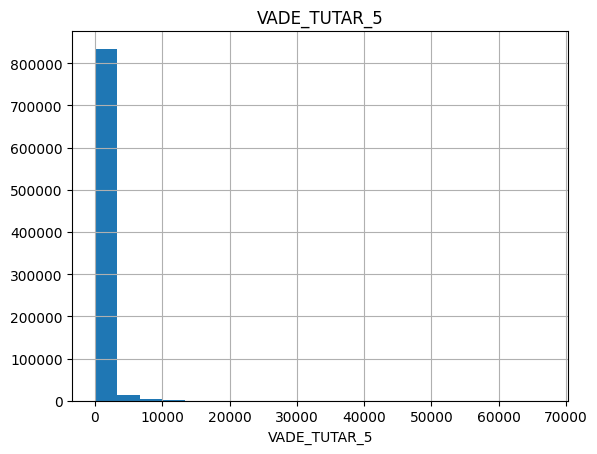

count   852719.000
mean       437.913
std        926.889
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        238.000
60%        325.000
70%        430.000
80%        574.000
90%        957.000
95%       1702.000
99%       4411.000
100%     66990.000
max      66990.000
Name: ODEME_TUTAR_5, dtype: float64


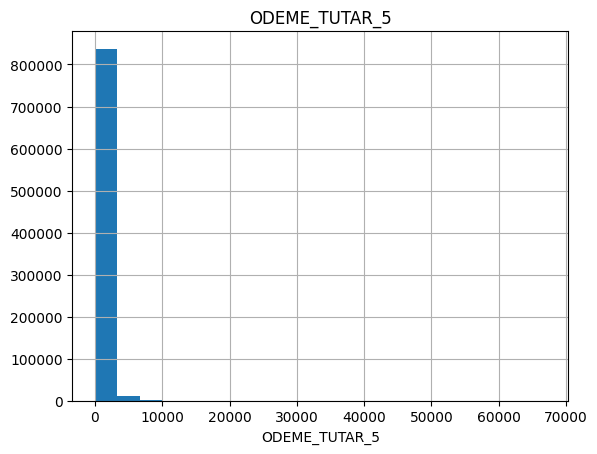

count   852719.000
mean       587.457
std       1012.085
min          0.000
5%           0.000
10%          0.000
20%        191.000
30%        248.000
40%        306.000
50%        363.000
60%        449.000
70%        516.000
80%        698.000
90%       1071.000
95%       1827.000
99%       4765.000
100%     74368.000
max      74368.000
Name: VADE_TUTAR_6, dtype: float64


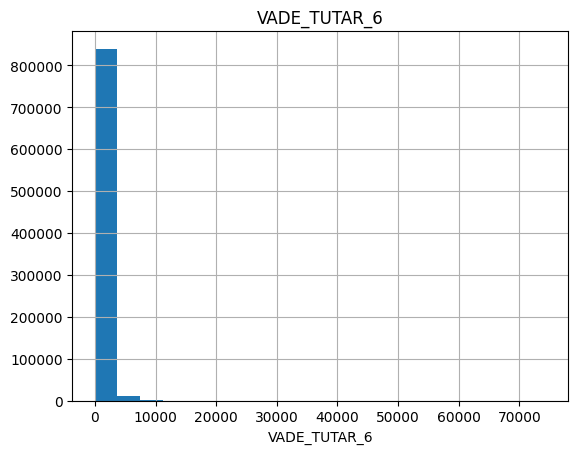

count   852719.000
mean       411.158
std        934.961
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        208.000
60%        287.000
70%        382.000
80%        526.000
90%        957.000
95%       1550.000
99%       4224.640
100%     66990.000
max      66990.000
Name: ODEME_TUTAR_6, dtype: float64


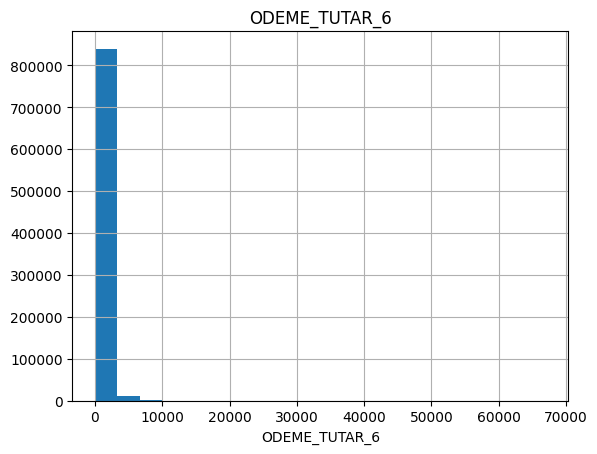

count   852719.000
mean       520.239
std        847.264
min          0.000
5%           0.000
10%          0.000
20%        181.000
30%        239.000
40%        267.000
50%        325.000
60%        401.000
70%        478.000
80%        622.000
90%        957.000
95%       1646.000
99%       4067.000
100%     76560.000
max      76560.000
Name: VADE_TUTAR_7, dtype: float64


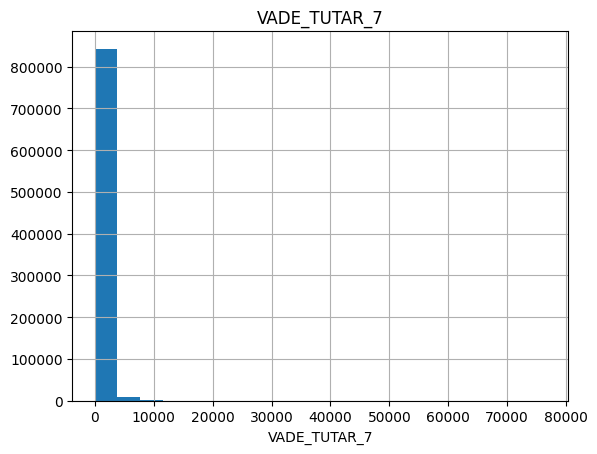

count   852719.000
mean       367.928
std        811.048
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        191.000
60%        267.000
70%        353.000
80%        478.000
90%        851.000
95%       1416.000
99%       3799.000
100%     76560.000
max      76560.000
Name: ODEME_TUTAR_7, dtype: float64


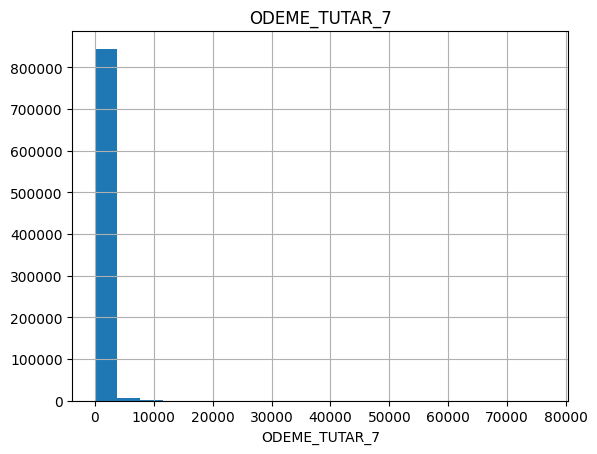

count   852719.000
mean       474.582
std        770.281
min          0.000
5%           0.000
10%          0.000
20%        174.000
30%        210.000
40%        258.000
50%        306.000
60%        363.000
70%        459.000
80%        555.000
90%        918.000
95%       1435.000
99%       3799.000
100%     76885.000
max      76885.000
Name: VADE_TUTAR_8, dtype: float64


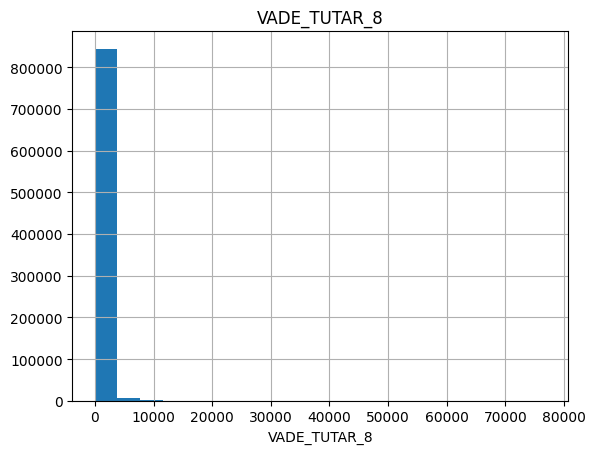

count   852719.000
mean       335.412
std        731.297
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        174.000
60%        239.000
70%        317.000
80%        459.000
90%        756.000
95%       1263.000
99%       3531.000
100%     65076.000
max      65076.000
Name: ODEME_TUTAR_8, dtype: float64


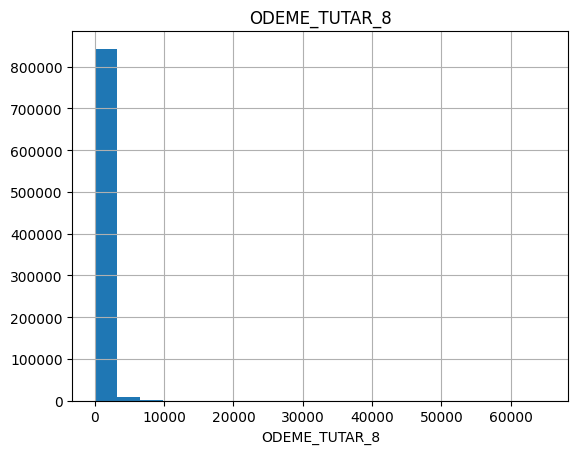

count   852719.000
mean       437.401
std        728.159
min          0.000
5%           0.000
10%          0.000
20%        172.000
30%        208.000
40%        239.000
50%        278.000
60%        344.000
70%        430.000
80%        497.000
90%        823.000
95%       1349.000
99%       3466.460
100%    115797.000
max     115797.000
Name: VADE_TUTAR_9, dtype: float64


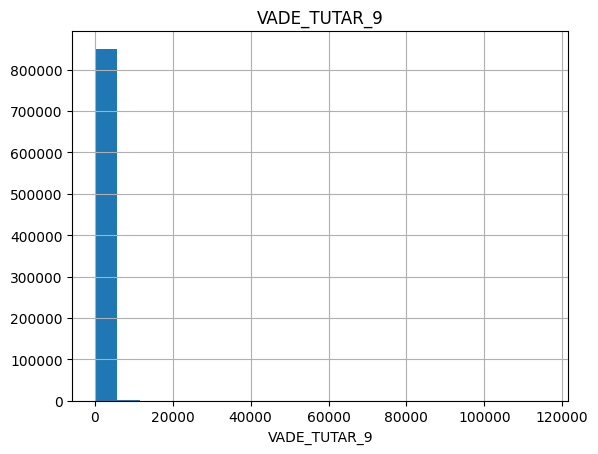

count   852719.000
mean       306.716
std        685.655
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        174.000
60%        239.000
70%        287.000
80%        411.000
90%        687.000
95%       1148.000
99%       3062.000
100%     66990.000
max      66990.000
Name: ODEME_TUTAR_9, dtype: float64


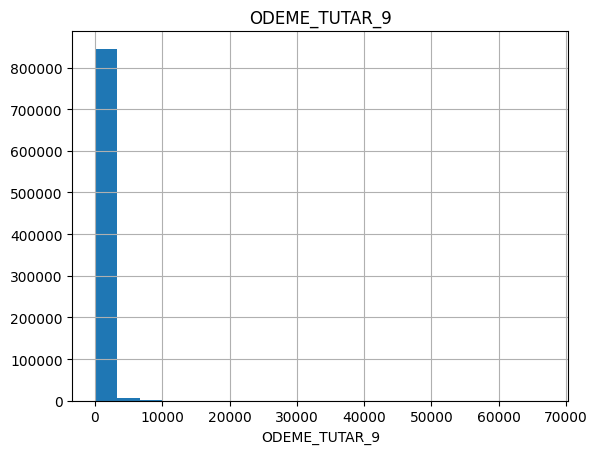

count   852719.000
mean       416.589
std        668.824
min          0.000
5%           0.000
10%          0.000
20%        172.000
30%        191.000
40%        239.000
50%        277.000
60%        325.000
70%        411.000
80%        478.000
90%        765.000
95%       1235.000
99%       3253.000
100%     66990.000
max      66990.000
Name: VADE_TUTAR_10, dtype: float64


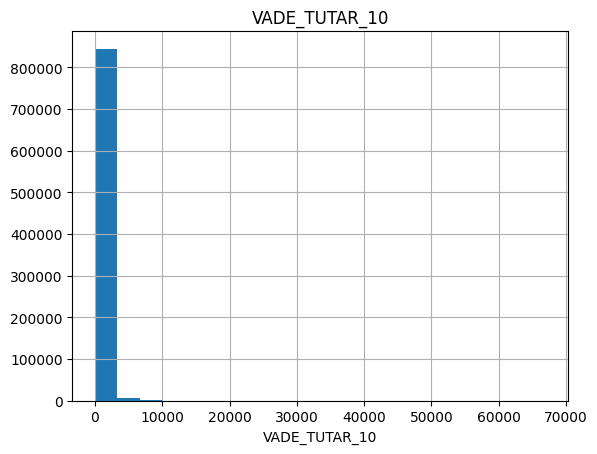

count   852719.000
mean       291.901
std        642.135
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        172.000
60%        229.000
70%        287.000
80%        382.000
90%        660.000
95%       1062.000
99%       2871.000
100%     66990.000
max      66990.000
Name: ODEME_TUTAR_10, dtype: float64


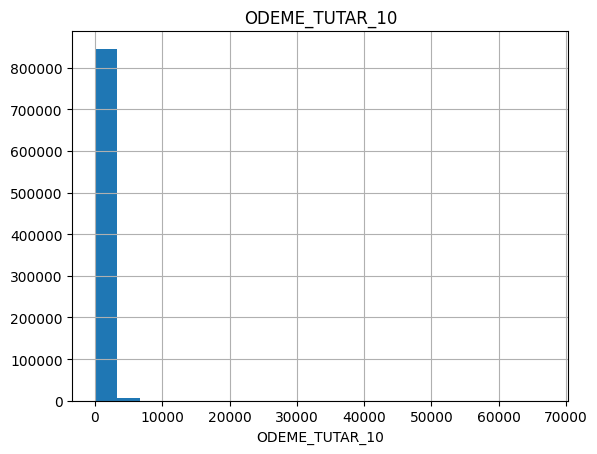

count   852719.000
mean       406.869
std        705.809
min          0.000
5%           0.000
10%          0.000
20%        162.000
30%        191.000
40%        239.000
50%        267.000
60%        315.000
70%        401.000
80%        478.000
90%        746.000
95%       1192.000
99%       3137.460
100%    143741.000
max     143741.000
Name: VADE_TUTAR_11, dtype: float64


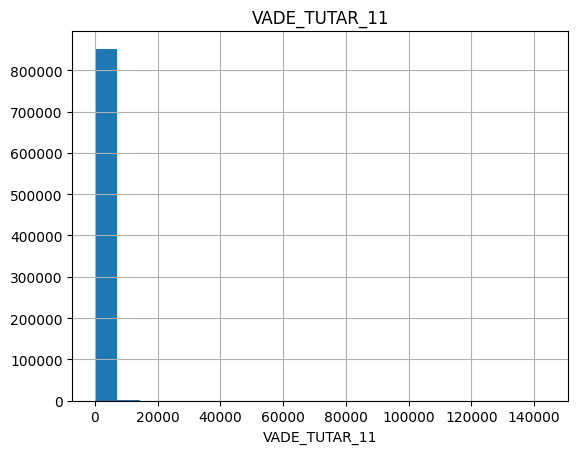

count   852719.000
mean       283.587
std        656.318
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%        172.000
60%        220.000
70%        287.000
80%        382.000
90%        631.000
95%       1023.000
99%       2871.000
100%     76560.000
max      76560.000
Name: ODEME_TUTAR_11, dtype: float64


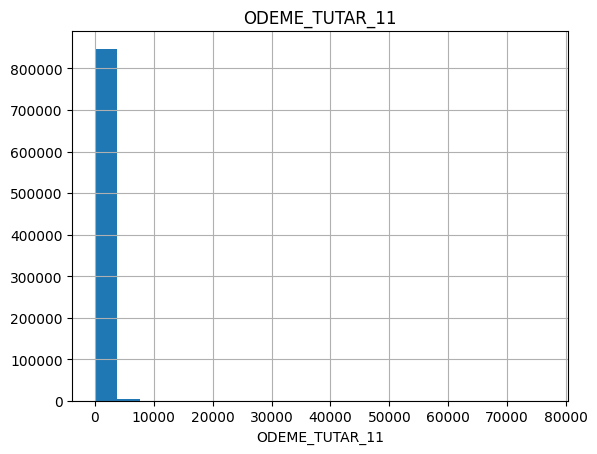

count   852719.000
mean     17413.150
std      39168.961
min          0.000
5%          20.000
10%         71.000
20%        547.000
30%       1666.000
40%       3016.000
50%       4662.000
60%       8165.000
70%      13727.000
80%      22287.000
90%      41794.200
95%      71758.100
99%     198875.940
100%    957000.000
max     957000.000
Name: ANAPARA, dtype: float64


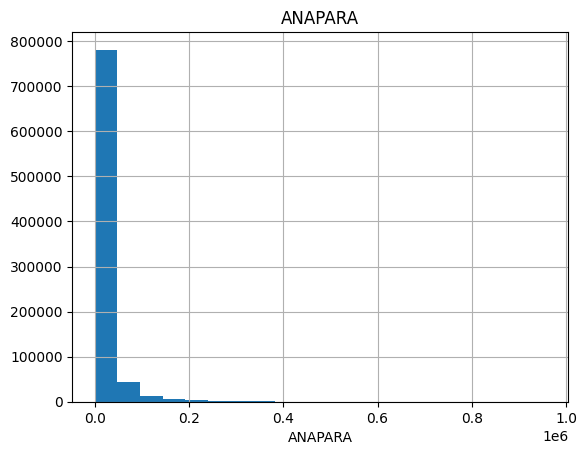

count    852719.000
mean      32790.044
std      109231.501
min     -334227.000
5%           -7.000
10%          44.000
20%         355.000
30%         794.000
40%        1509.000
50%        2947.000
60%        6850.000
70%       15314.000
80%       32287.000
90%       78209.400
95%      147367.100
99%      466361.200
100%    7510468.000
max     7510468.000
Name: GETIRI, dtype: float64


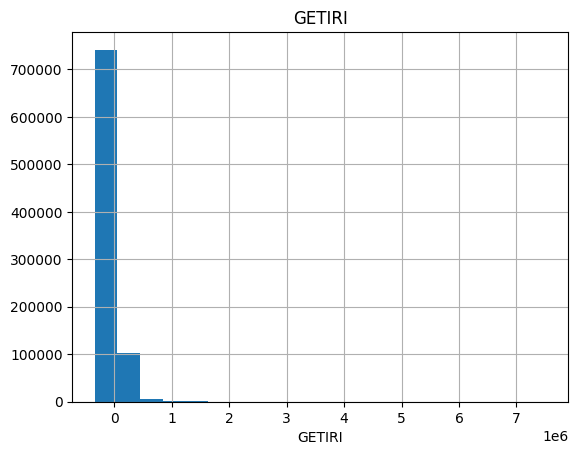

count   852719.000
mean        62.937
std         56.456
min          0.000
5%           2.000
10%          6.000
20%         12.000
30%         18.000
40%         28.000
50%         46.000
60%         68.000
70%         91.000
80%        109.000
90%        148.000
95%        183.000
99%        215.000
100%       239.000
max        239.000
Name: AKTIF_ILK_POLICE_RG, dtype: float64


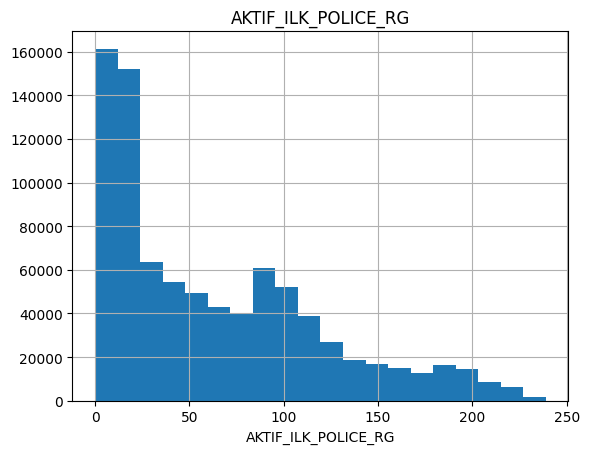

In [17]:

def num_summary(dataframe, num_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe[num_col].describe(quantiles).T)
    
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()

for col in train_num_cols:
    num_summary(train, col, True)
    

       PP_YAS
LABEL        
HU06  438.885
HU07  442.590
HU11  476.107
HU12  512.269
HU14  428.514
HU15  477.983
HU19  444.248
UA    440.832





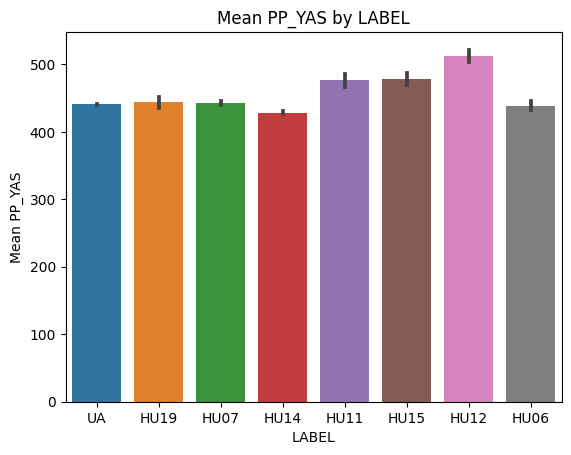

          IL
LABEL       
HU06  29.641
HU07  30.557
HU11  31.585
HU12  29.626
HU14  31.258
HU15  28.359
HU19  35.199
UA    31.025





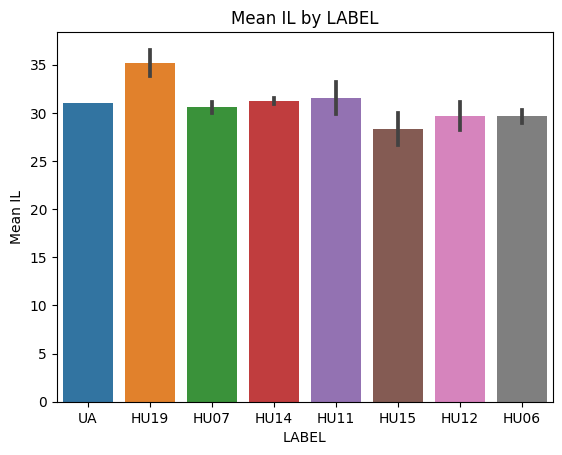

       SORU_MEDENI_HAL_RG
LABEL                    
HU06               90.173
HU07               71.096
HU11              105.337
HU12              106.484
HU14               82.697
HU15              126.708
HU19               89.569
UA                 87.404





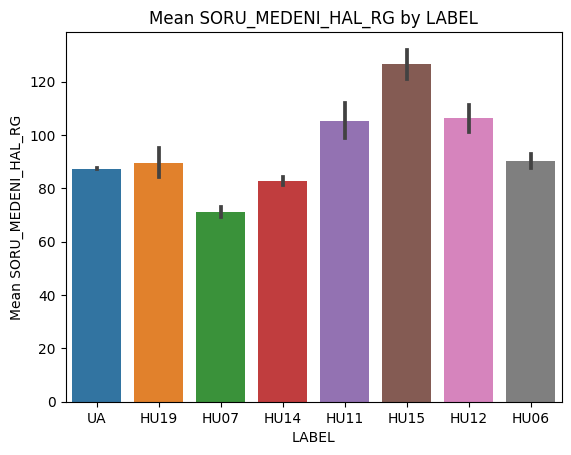

       SORU_EGITIM_RG
LABEL                
HU06           90.714
HU07           70.733
HU11          105.324
HU12          106.393
HU14           82.549
HU15          126.115
HU19           89.521
UA             84.800





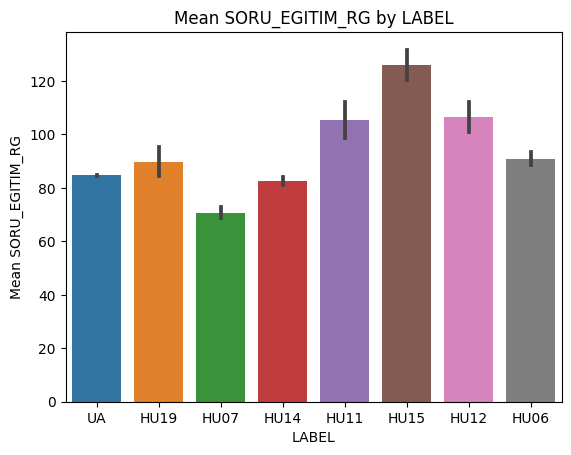

       SORU_GELIR_CVP
LABEL                
HU06        44617.366
HU07         7669.851
HU11        25366.108
HU12        11589.939
HU14        24056.217
HU15         7361.045
HU19        37919.686
UA          33245.749





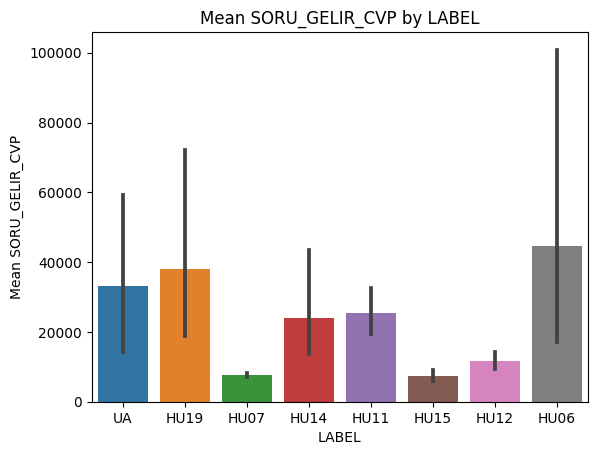

       VADE_TUTAR_0
LABEL              
HU06       3237.989
HU07        995.543
HU11       4518.538
HU12       1452.827
HU14       1399.207
HU15       1553.043
HU19       1648.086
UA         1155.216





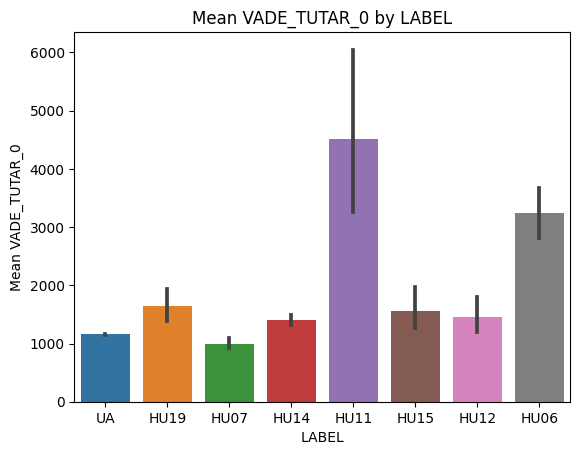

       ODEME_TUTAR_0
LABEL               
HU06        2276.884
HU07         790.644
HU11        4009.704
HU12         977.513
HU14         980.092
HU15        1338.193
HU19        1275.750
UA           674.748





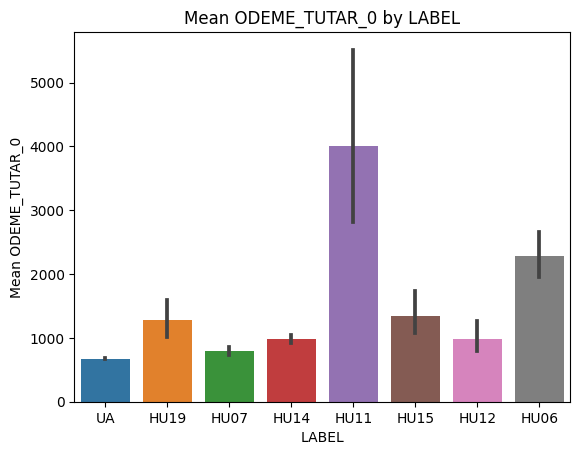

       VADE_TUTAR_1
LABEL              
HU06       1524.080
HU07        844.206
HU11       2160.993
HU12       1204.746
HU14       1093.843
HU15       1367.880
HU19       1367.232
UA          888.825





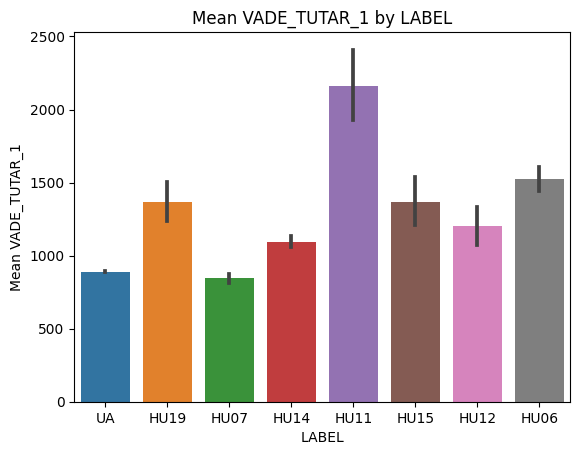

       ODEME_TUTAR_1
LABEL               
HU06        1293.458
HU07         737.839
HU11        1947.975
HU12         929.429
HU14         921.622
HU15        1236.831
HU19        1092.974
UA           592.724





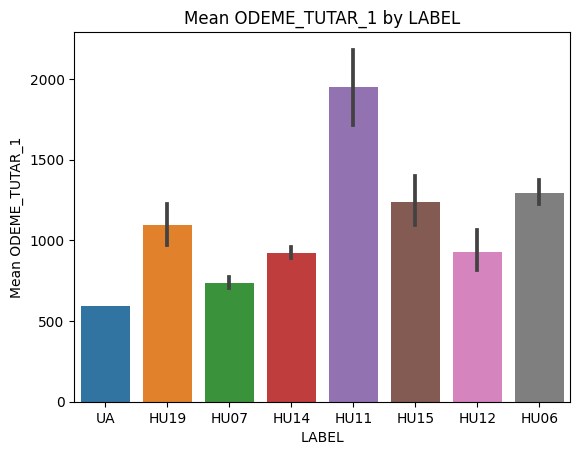

       VADE_TUTAR_2
LABEL              
HU06       1454.106
HU07        834.017
HU11       2113.021
HU12       1160.899
HU14       1044.727
HU15       1347.087
HU19       1319.480
UA          864.325





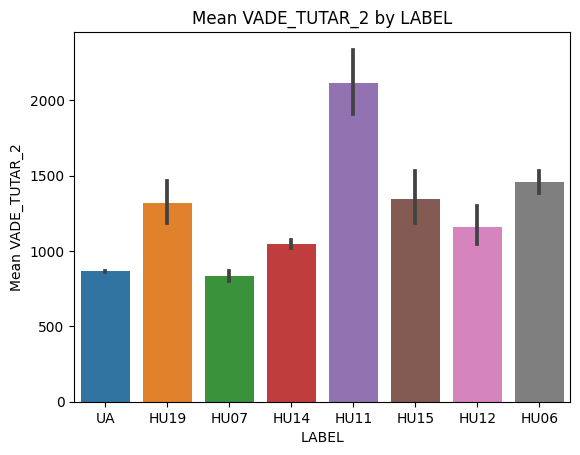

       ODEME_TUTAR_2
LABEL               
HU06        1257.059
HU07         733.234
HU11        1919.401
HU12         910.352
HU14         897.028
HU15        1228.757
HU19        1072.543
UA           586.493





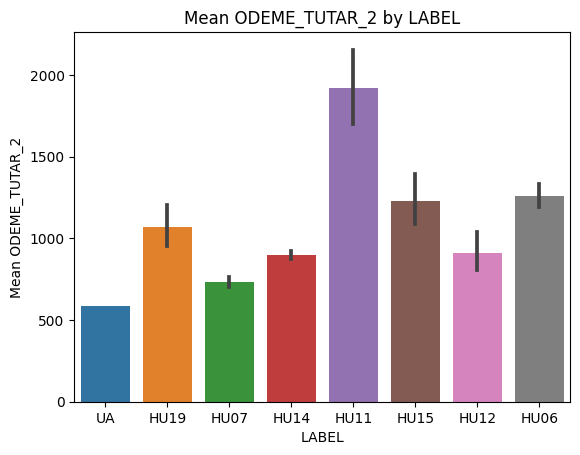

       VADE_TUTAR_3
LABEL              
HU06       1430.464
HU07        817.288
HU11       2034.394
HU12       1125.065
HU14       1030.221
HU15       1352.029
HU19       1248.854
UA          863.535





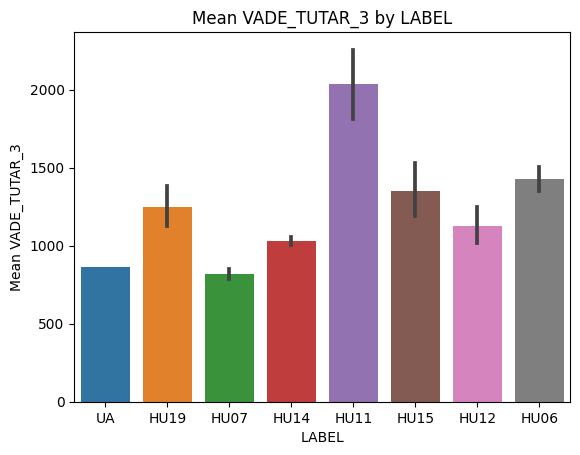

       ODEME_TUTAR_3
LABEL               
HU06        1235.526
HU07         734.016
HU11        1861.118
HU12         866.593
HU14         889.497
HU15        1233.696
HU19         994.084
UA           586.457





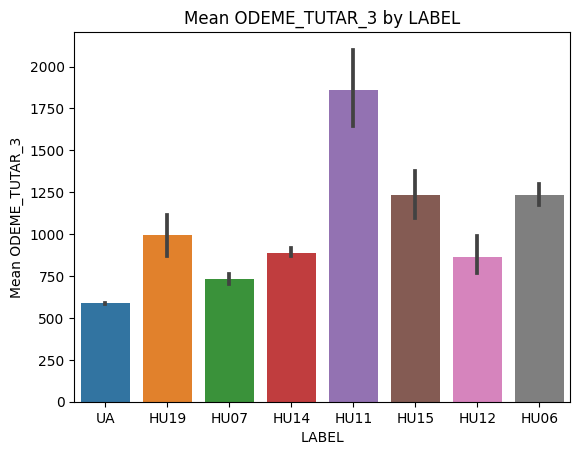

       VADE_TUTAR_4
LABEL              
HU06       1284.964
HU07        767.071
HU11       1816.200
HU12       1036.522
HU14        959.535
HU15       1213.824
HU19       1140.125
UA          750.032





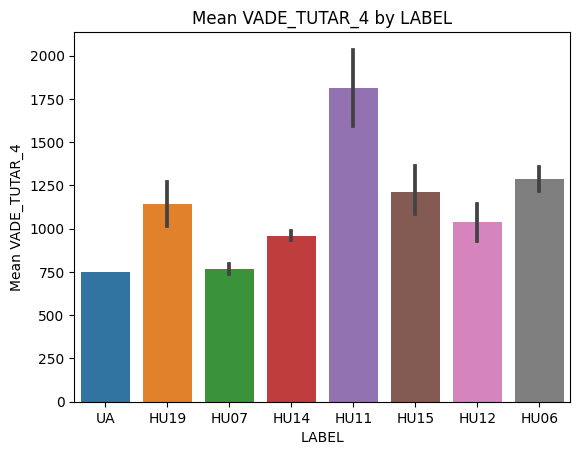

       ODEME_TUTAR_4
LABEL               
HU06        1118.296
HU07         692.186
HU11        1657.289
HU12         817.769
HU14         835.303
HU15        1119.359
HU19         907.679
UA           517.723





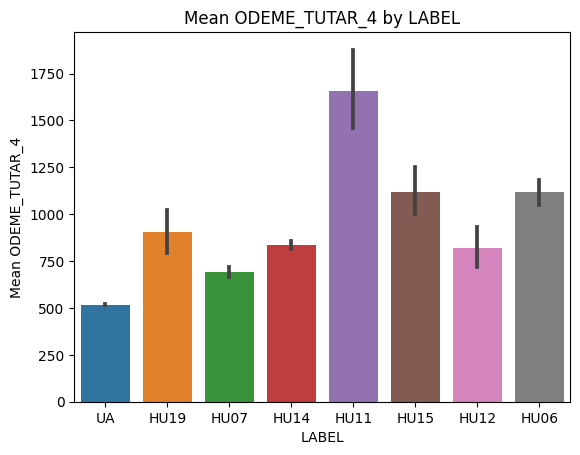

       VADE_TUTAR_5
LABEL              
HU06       1097.800
HU07        689.593
HU11       1638.367
HU12        909.846
HU14        862.334
HU15       1038.412
HU19       1062.934
UA          615.224





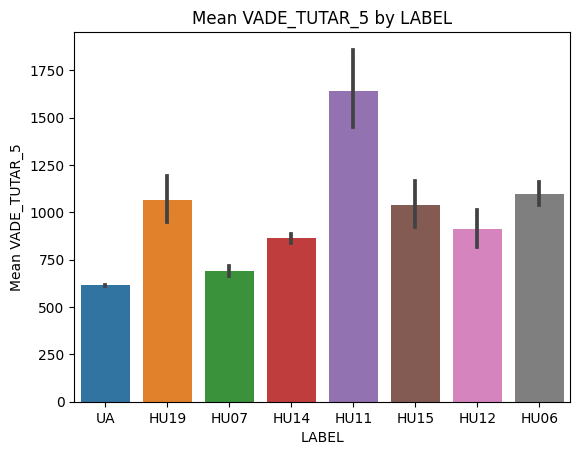

       ODEME_TUTAR_5
LABEL               
HU06         953.920
HU07         624.200
HU11        1510.631
HU12         736.481
HU14         758.194
HU15         947.263
HU19         860.917
UA           429.527





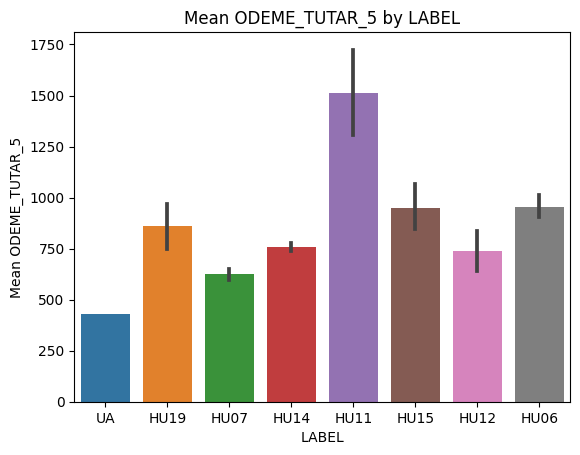

       VADE_TUTAR_6
LABEL              
HU06       1018.316
HU07        631.865
HU11       1463.326
HU12        824.024
HU14        796.385
HU15        913.186
HU19        972.227
UA          581.749





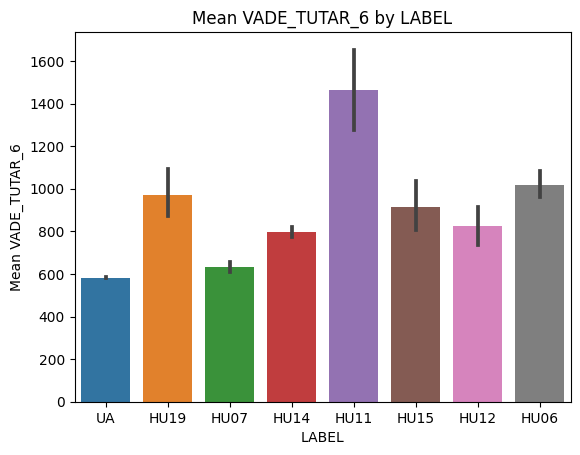

       ODEME_TUTAR_6
LABEL               
HU06         887.260
HU07         573.174
HU11        1356.749
HU12         664.556
HU14         701.631
HU15         829.576
HU19         789.580
UA           403.607





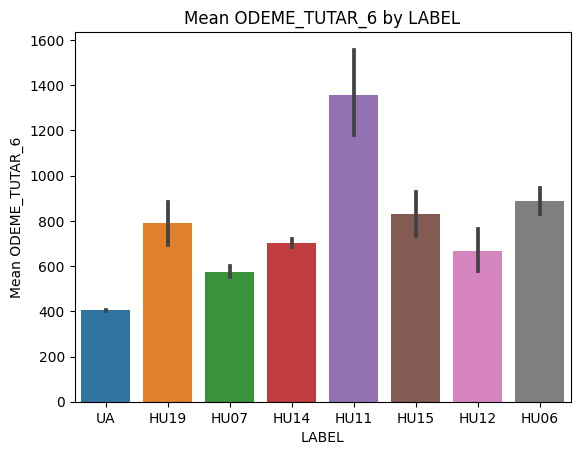

       VADE_TUTAR_7
LABEL              
HU06        869.268
HU07        571.474
HU11       1308.699
HU12        698.851
HU14        706.301
HU15        826.819
HU19        833.874
UA          515.276





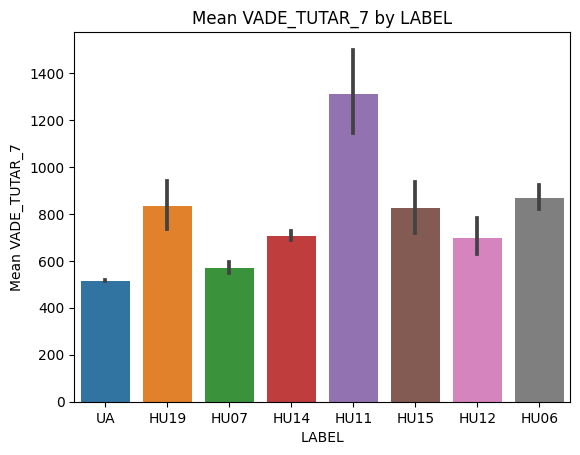

       ODEME_TUTAR_7
LABEL               
HU06         764.974
HU07         520.843
HU11        1203.868
HU12         556.515
HU14         630.486
HU15         743.002
HU19         674.845
UA           361.277





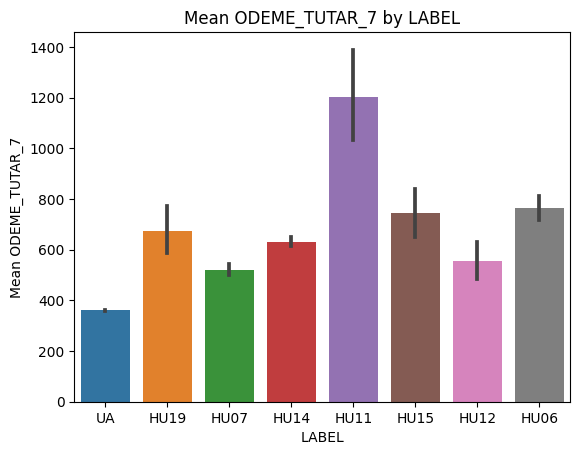

       VADE_TUTAR_8
LABEL              
HU06        762.453
HU07        505.021
HU11       1166.779
HU12        612.438
HU14        623.633
HU15        807.369
HU19        649.859
UA          470.620





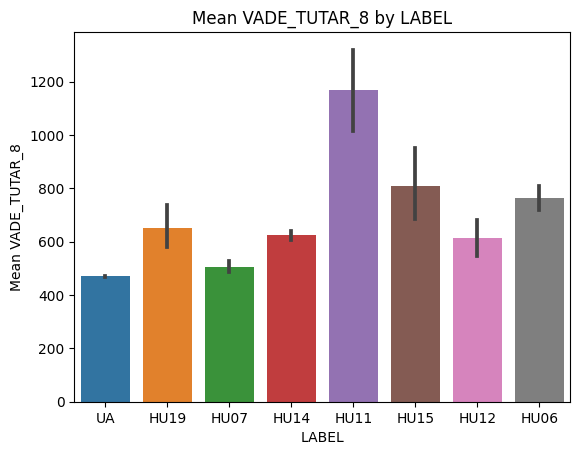

       ODEME_TUTAR_8
LABEL               
HU06         671.725
HU07         460.818
HU11        1088.806
HU12         495.320
HU14         557.477
HU15         733.149
HU19         529.344
UA           329.797





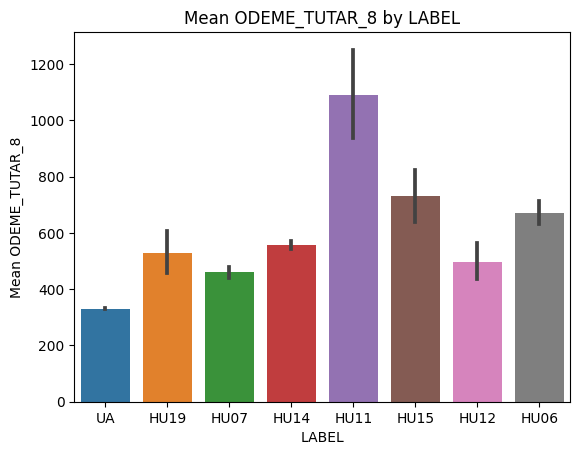

       VADE_TUTAR_9
LABEL              
HU06        670.434
HU07        449.304
HU11        998.581
HU12        540.053
HU14        551.926
HU15        681.829
HU19        554.306
UA          434.372





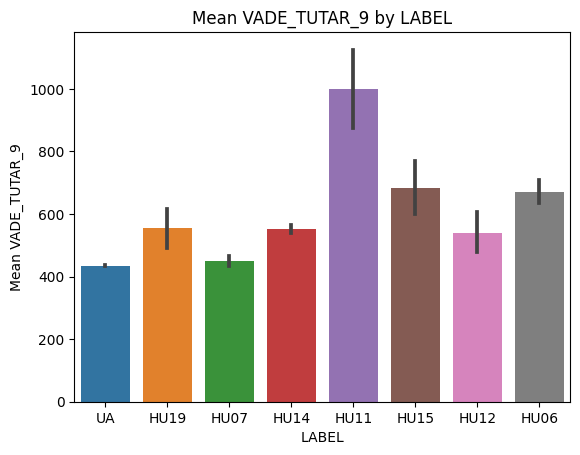

       ODEME_TUTAR_9
LABEL               
HU06         587.774
HU07         412.537
HU11         925.226
HU12         444.027
HU14         496.866
HU15         629.494
HU19         455.335
UA           301.981





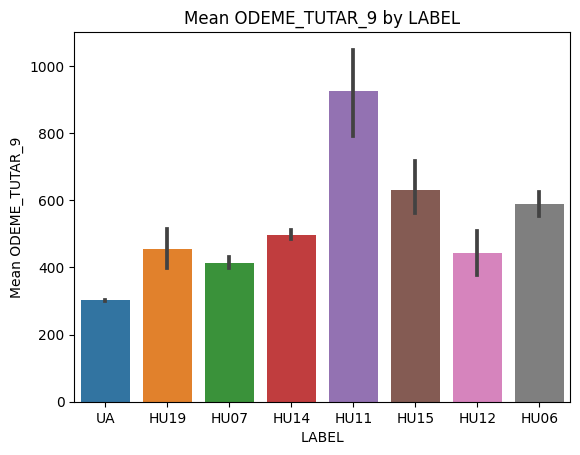

       VADE_TUTAR_10
LABEL               
HU06         638.654
HU07         444.204
HU11         946.082
HU12         518.907
HU14         537.191
HU15         667.783
HU19         541.889
UA           413.459





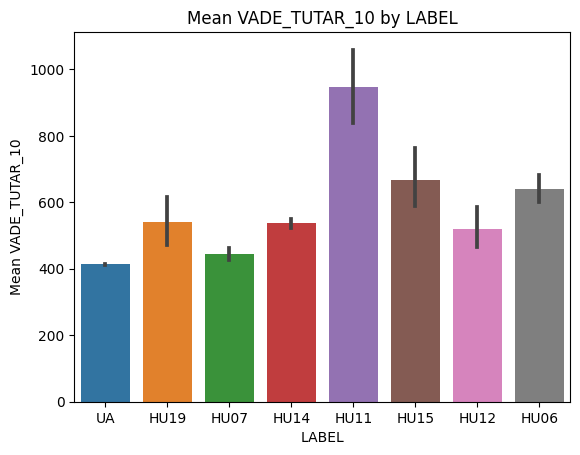

       ODEME_TUTAR_10
LABEL                
HU06          553.113
HU07          409.249
HU11          873.576
HU12          427.266
HU14          485.581
HU15          617.084
HU19          445.539
UA            287.159





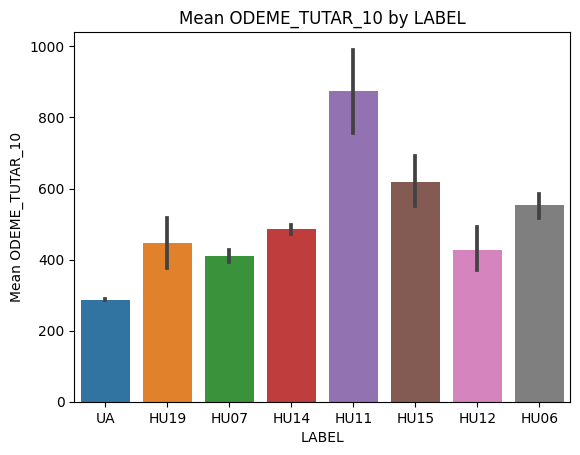

       VADE_TUTAR_11
LABEL               
HU06         612.845
HU07         441.146
HU11         893.663
HU12         491.598
HU14         509.090
HU15         677.810
HU19         505.279
UA           404.060





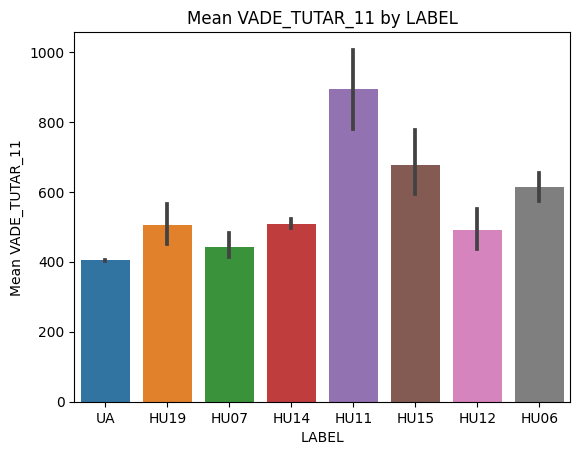

       ODEME_TUTAR_11
LABEL                
HU06          541.249
HU07          403.909
HU11          820.781
HU12          400.127
HU14          462.168
HU15          627.111
HU19          404.926
UA            279.100





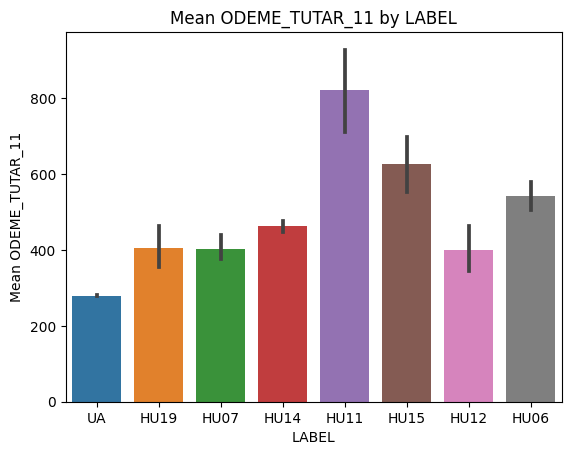

        ANAPARA
LABEL          
HU06  37560.683
HU07  14650.166
HU11  49108.613
HU12  21504.290
HU14  17737.779
HU15  43495.949
HU19  21703.826
UA    17307.502





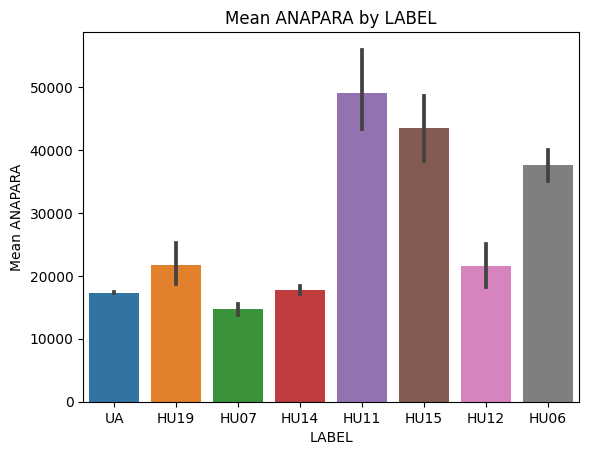

          GETIRI
LABEL           
HU06   64592.514
HU07   19079.304
HU11   66431.130
HU12   33420.030
HU14   22648.220
HU15  105719.441
HU19   31660.804
UA     32807.465





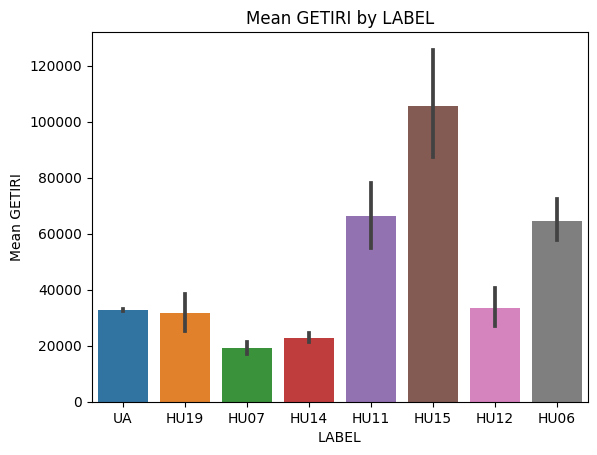

       AKTIF_ILK_POLICE_RG
LABEL                     
HU06                47.072
HU07                35.223
HU11                51.686
HU12                54.893
HU14                33.470
HU15                92.422
HU19                37.204
UA                  63.523





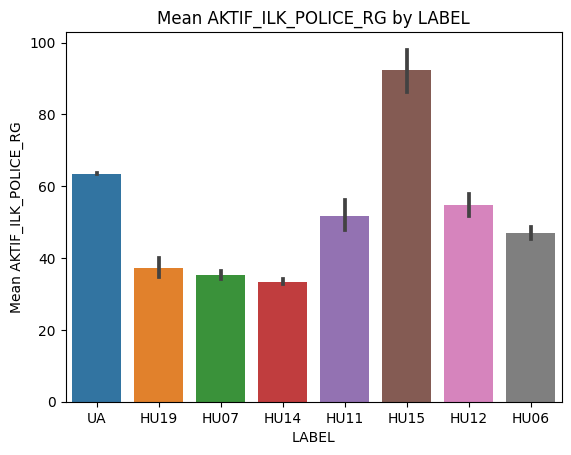

In [18]:

def target_analysis_num(dataframe, target, num_col, plot=False):
    print(dataframe.groupby(target).agg({num_col: "mean"}), end="\n\n\n\n")     
    
    if plot==True:
        sns.barplot(x=target, y=num_col, data=dataframe)
        plt.xlabel(target)
        plt.ylabel(f'Mean {col}')
        plt.title(f'Mean {col} by {target}')
        plt.show()

for col in train_num_cols:
    target_analysis_num(train, "LABEL", col, True)
    

              LABEL
LABEL LABEL        
HU06  HU06     3178
HU07  HU07     3728
HU11  HU11      439
HU12  HU12      676
HU14  HU14    10754
HU15  HU15      415
HU19  HU19      759
UA    UA     832770





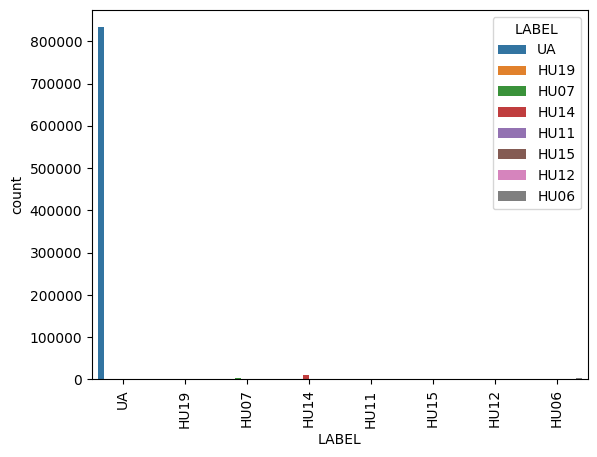

                LABEL
FLAG    LABEL        
AGUSTOS HU06      503
        HU07      626
        HU11       38
        HU12      116
        HU14     1863
        HU15       57
        HU19      133
        UA      81405
EKIM    HU06      438
        HU07      564
        HU11       90
        HU12      120
        HU14     1690
        HU15       64
        HU19      129
        UA      90671
EYLUL   HU06      474
        HU07      706
        HU11       75
        HU12      124
        HU14     2114
        HU15       53
        HU19      232
        UA      85392
HAZIRAN HU06      647
        HU07      757
        HU11       73
        HU12      124
        HU14     2066
        HU15      121
        HU19       83
        UA     248322
MAYIS   HU06      545
        HU07      518
        HU11       80
        HU12       91
        HU14     1416
        HU15       52
        HU19       79
        UA     243608
TEMMUZ  HU06      571
        HU07      557
        HU11       83
        HU

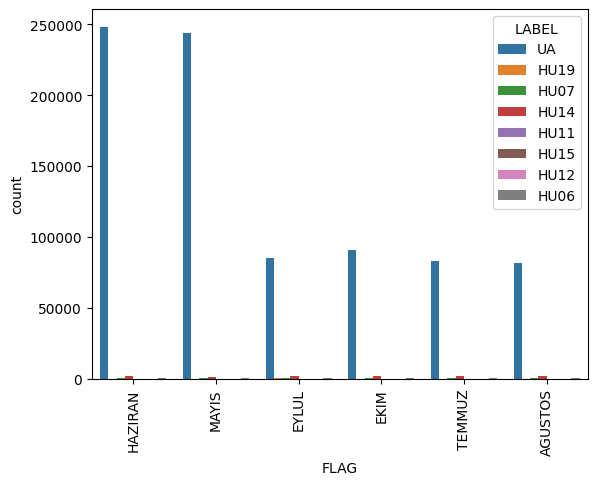

                                                   LABEL
PP_MESLEK                                  LABEL        
Akademisyen                                HU06       48
                                           HU07       64
                                           HU11        4
                                           HU12       10
                                           HU14       87
                                           HU15       10
                                           HU19        2
                                           UA       7243
Amiral                                     HU14        1
                                           UA          7
Analist                                    HU07        1
                                           HU11        1
                                           HU14        3
                                           UA        270
Antrenör                                   HU07        2
                               

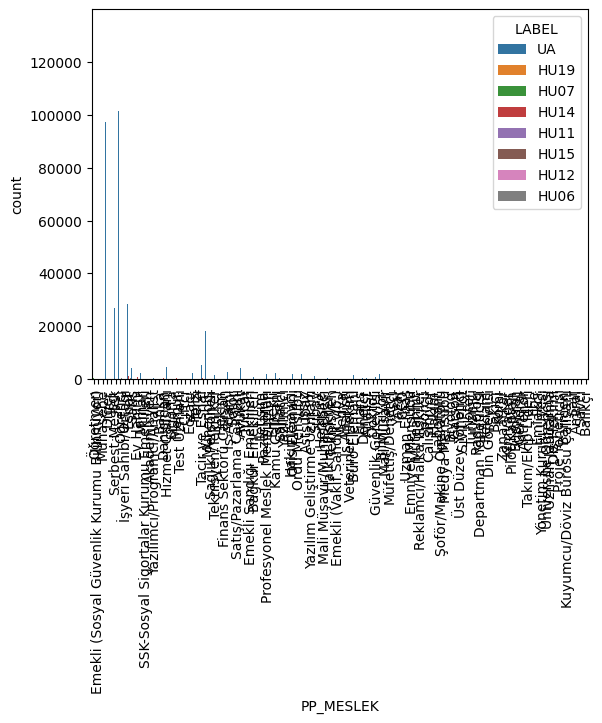

                                  LABEL
SORU_YATIRIM_KARAKTERI_CVP LABEL       
Bilge                      HU06     145
                           HU07      76
                           HU11      20
                           HU12      12
                           HU14     271
                           HU15      27
                           HU19      18
                           UA     17848
Cesur                      HU06     180
                           HU07     150
                           HU11      19
                           HU12      22
                           HU14     442
                           HU15      38
                           HU19      32
                           UA     32401
Dengeli                    HU06     126
                           HU07     117
                           HU11      19
                           HU12      13
                           HU14     299
                           HU15      32
                           HU19      15


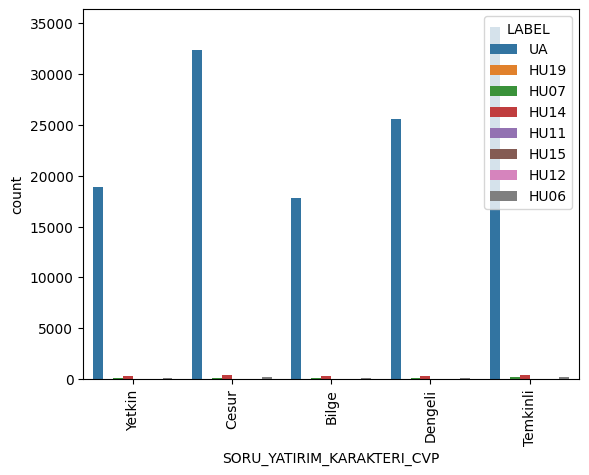

                            LABEL
SORU_MEDENI_HAL_CVP LABEL        
Divorced            HU06      218
                    HU07      323
                    HU11       19
                    HU12       39
                    HU14      481
                    HU15       13
                    HU19       35
                    UA      24218
Marriage Annulled   UA          2
Marriage Cancelled  UA          6
Married             HU06     1824
                    HU07     2299
                    HU11      354
                    HU12      517
                    HU14     6587
                    HU15      248
                    HU19      512
                    UA     464072
Other               UA         14
Single              HU06     1102
                    HU07     1067
                    HU11       65
                    HU12      105
                    HU14     3610
                    HU15      149
                    HU19      211
                    UA     336012
Widowed       

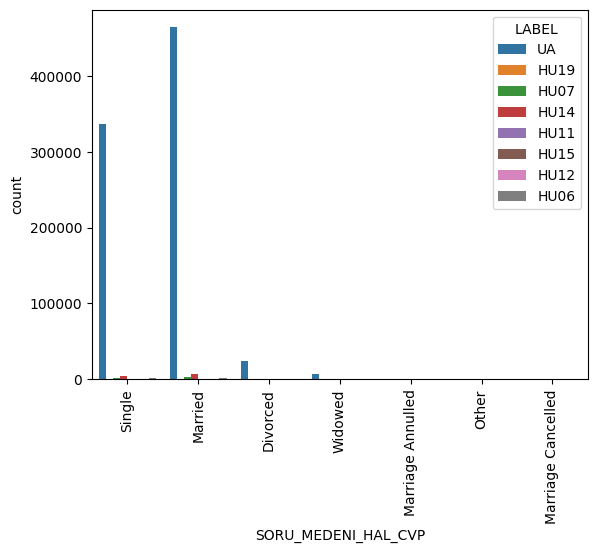

                        LABEL
SORU_EGITIM_CVP LABEL        
(Diğer)         HU06      406
                HU07      105
                HU11       56
                HU12      268
                HU14      692
                HU15       28
                HU19      107
                UA     134693
Doktora         HU06       27
                HU07       21
                HU11        1
                HU14       43
                HU15        7
                UA       3658
Lisans          HU06     1418
                HU07     1769
                HU11      195
                HU12       92
                HU14     3999
                HU15      238
                HU19      168
                UA     204131
Lise            HU06      854
                HU07     1496
                HU11      155
                HU12      227
                HU14     5043
                HU15       60
                HU19      439
                UA     232415
Yüksek Lisans   HU06       86
          

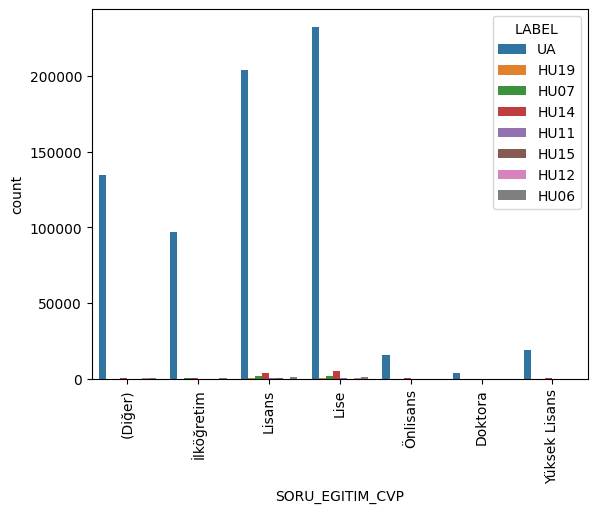

                    LABEL
PP_CINSIYET LABEL        
1           HU06     1848
            HU11      341
            HU12      532
            HU14     7390
            HU15      153
            HU19      618
            UA     420401
2           HU06     1330
            HU07     3728
            HU11       98
            HU12      144
            HU14     3364
            HU15      262
            HU19      141
            UA     412369





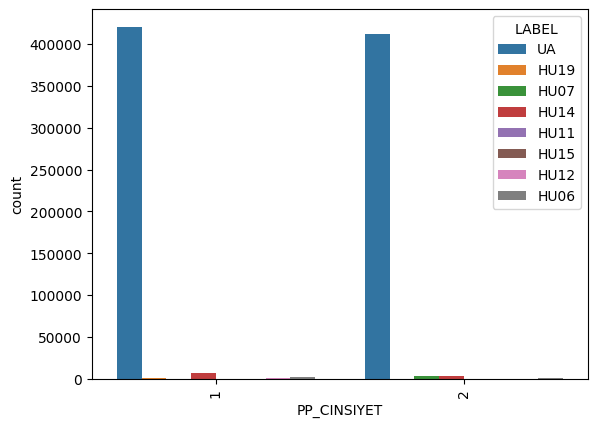

                            LABEL
PP_MUSTERI_SEGMENTI LABEL        
101                 HU06       61
                    HU07        2
                    HU11       19
                    HU12        1
                    HU14       16
                    HU19        1
                    UA        712
102                 HU06     1195
                    HU07      620
                    HU11      236
                    HU12      100
                    HU14     1732
                    HU15      146
                    HU19      174
                    UA     102893
103                 HU06      451
                    HU07      425
                    HU11      159
                    HU12       93
                    HU14     1465
                    HU15       78
                    HU19      149
                    UA      85825
104                 HU06      778
                    HU07      532
                    HU11       13
                    HU12      107
              

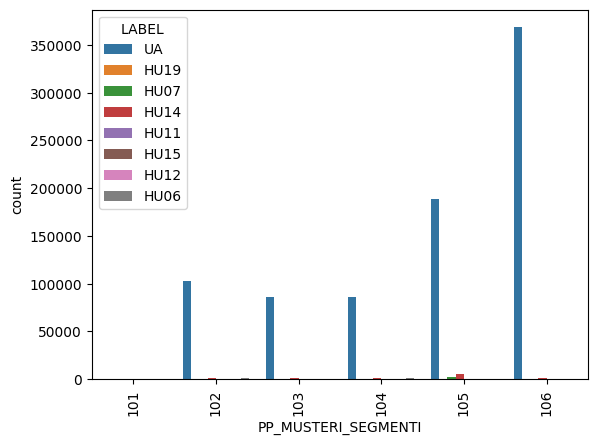

                 LABEL
PP_UYRUK LABEL        
1        HU06     3146
         HU07     3704
         HU11      438
         HU12      672
         HU14    10630
         HU15      412
         HU19      757
         UA     828576
2        HU06       25
         HU07        7
         HU12        1
         HU14       46
         HU15        2
         UA       2489
3        HU06        7
         HU07       17
         HU11        1
         HU12        3
         HU14       78
         HU15        1
         HU19        2
         UA       1705





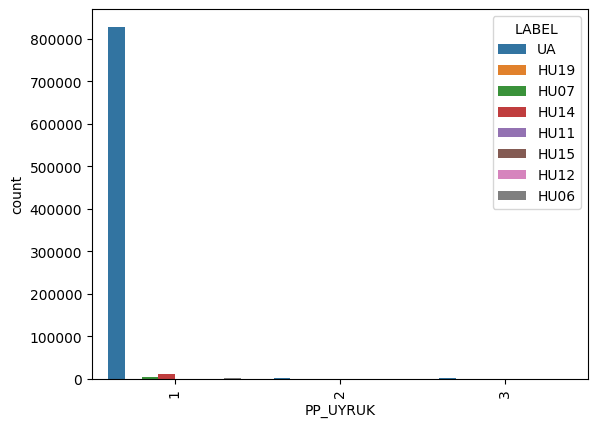

                               LABEL
BES_AYRILMA_TALEP_ADET LABEL        
0                      HU06     3146
                       HU07     3683
                       HU11      436
                       HU12      666
                       HU14    10585
                       HU15      415
                       HU19      749
                       UA     825344
1                      HU06       25
                       HU07       39
                       HU11        3
                       HU12       10
                       HU14      138
                       HU19        8
                       UA       6565
2                      HU06        7
                       HU07        5
                       HU14       26
                       HU19        2
                       UA        741
3                      HU07        1
                       HU14        4
                       UA         92
4                      HU14        1
                       UA         23
5

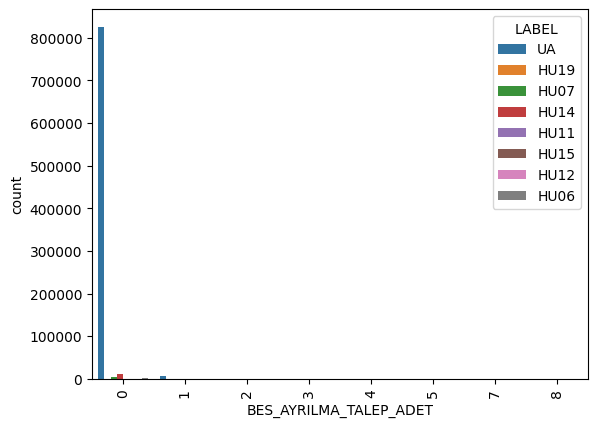

                           LABEL
ODEMEME_TALEP_ADET LABEL        
0                  HU06     3174
                   HU07     3725
                   HU11      437
                   HU12      676
                   HU14    10748
                   HU15      415
                   HU19      759
                   UA     832490
1                  HU06        2
                   HU07        3
                   HU11        1
                   HU14        5
                   UA        240
2                  HU06        1
                   HU11        1
                   HU14        1
                   UA         33
3                  HU06        1
                   UA          6
4                  UA          1





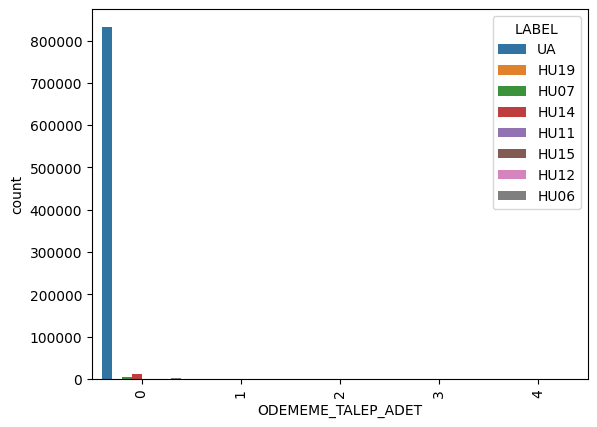

                                 LABEL
HAYAT_AYRILMA_TALEP_ADET LABEL        
0                        HU06     3165
                         HU07     3723
                         HU11      438
                         HU12      673
                         HU14    10733
                         HU15      415
                         HU19      758
                         UA     832387
1                        HU06       10
                         HU07        4
                         HU11        1
                         HU12        3
                         HU14       18
                         UA        343
2                        HU06        3
                         HU07        1
                         HU14        3
                         HU19        1
                         UA         35
3                        UA          1
4                        UA          3
5                        UA          1





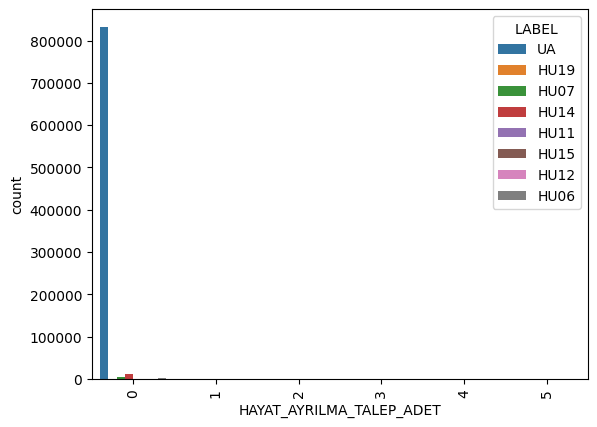

                         LABEL
BILGI_TALEP_ADET LABEL        
0                HU06     3166
                 HU07     3715
                 HU11      436
                 HU12      676
                 HU14    10735
                 HU15      414
                 HU19      756
                 UA     831687
1                HU06        9
                 HU07       11
                 HU11        3
                 HU14       15
                 HU15        1
                 HU19        3
                 UA        925
2                HU06        2
                 HU14        4
                 UA         62
3                HU06        1
                 UA         17
4                HU07        1
                 UA          8
5                UA          6
6                UA          7
7                UA         17
8                HU07        1
                 UA         10
9                UA          9
10               UA         15
11               UA          6
12      

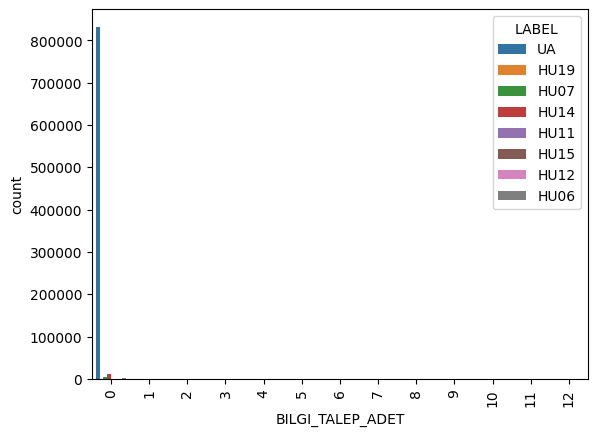

             LABEL
BU01 LABEL        
0    HU06     3107
     HU07     3691
     HU11      430
     HU12      603
     HU14    10534
     HU15      409
     HU19      739
     UA     794050
1    HU06       71
     HU07       37
     HU11        9
     HU12       73
     HU14      217
     HU15        6
     HU19       19
     UA      38477
2    HU14        3
     HU19        1
     UA        227
3    UA         14
4    UA          2





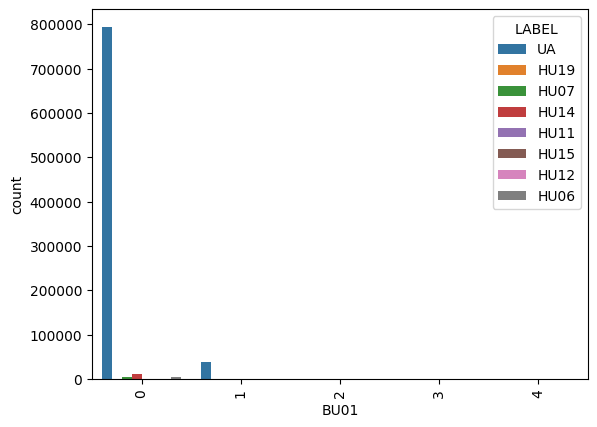

             LABEL
BU02 LABEL        
0    HU06     3001
     HU07     3161
     HU11      410
     HU12      609
     HU14     8774
     HU15      380
     HU19      653
     UA     759517
1    HU06      157
     HU07      525
     HU11       26
     HU12       64
     HU14     1785
     HU15       31
     HU19       92
     UA      70237
2    HU06       17
     HU07       40
     HU11        3
     HU12        3
     HU14      177
     HU15        4
     HU19       12
     UA       2881
3    HU06        3
     HU07        2
     HU14       14
     HU19        2
     UA        114
4    HU14        3
     UA         17
5    UA          3
6    HU14        1
     UA          1





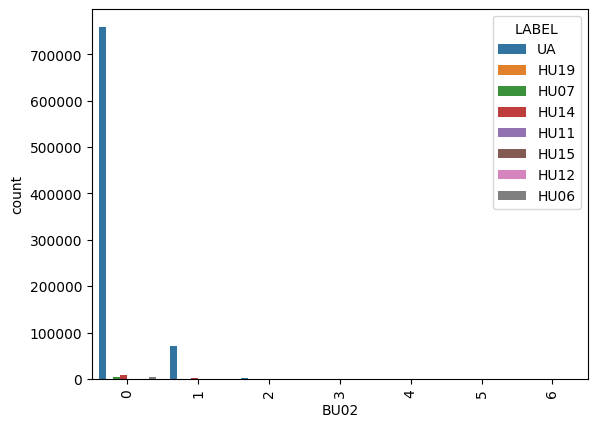

             LABEL
BU03 LABEL        
0    HU06     3157
     HU07     3715
     HU11      438
     HU12      669
     HU14    10702
     HU15      404
     HU19      756
     UA     827226
1    HU06       20
     HU07       13
     HU11        1
     HU12        6
     HU14       48
     HU15        9
     HU19        3
     UA       5385
2    HU06        1
     HU12        1
     HU14        3
     HU15        2
     UA        140
3    HU14        1
     UA         16
4    UA          3





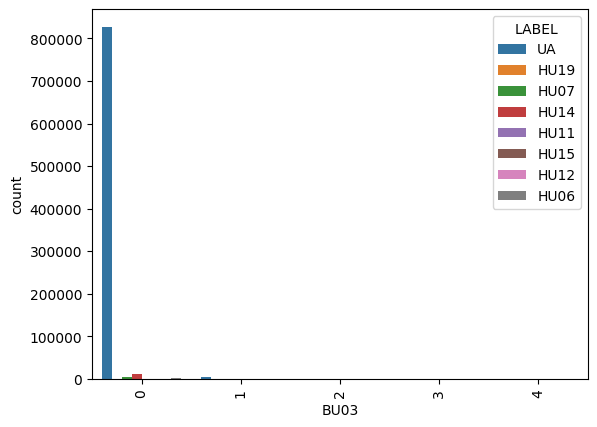

             LABEL
BU04 LABEL        
0    HU06     3174
     HU07     3728
     HU11      439
     HU12      676
     HU14    10753
     HU15      415
     HU19      759
     UA     832184
1    HU06        4
     HU14        1
     UA        570
2    UA         11
3    UA          4
4    UA          1





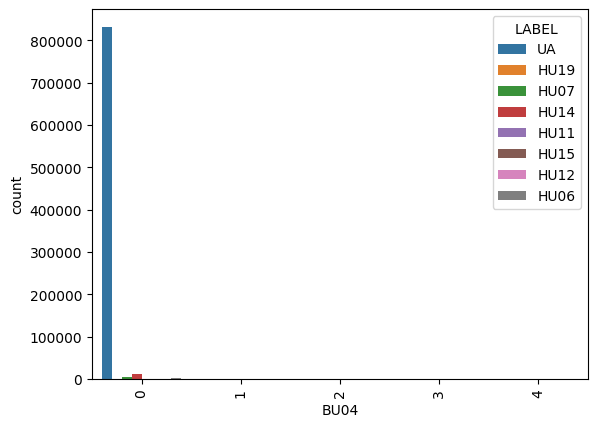

             LABEL
BU05 LABEL        
0    HU06     3177
     HU07     3724
     HU11      439
     HU12      676
     HU14    10750
     HU15      415
     HU19      759
     UA     832516
1    HU06        1
     HU07        4
     HU14        3
     UA        236
2    HU14        1
     UA         18





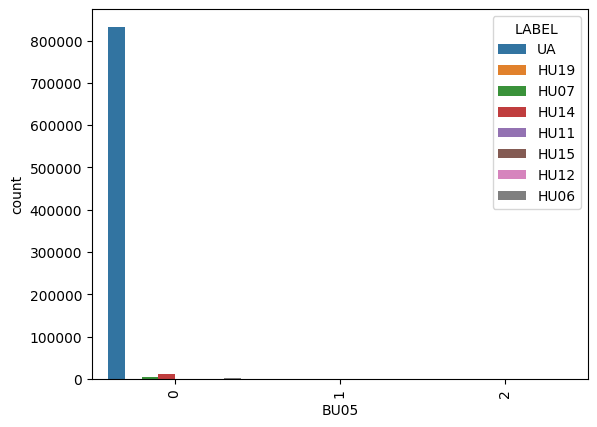

             LABEL
BU06 LABEL        
0    HU06     3178
     HU07     3728
     HU11      439
     HU12      676
     HU14    10754
     HU15      415
     HU19      759
     UA     832767
1    UA          3





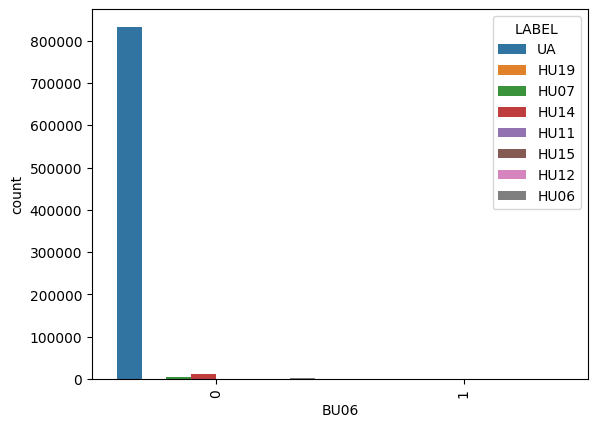

             LABEL
BU07 LABEL        
0    HU06     3171
     HU07     3726
     HU11      435
     HU12      675
     HU14    10741
     HU15      412
     HU19      759
     UA     828486
1    HU06        6
     HU07        2
     HU11        4
     HU12        1
     HU14       13
     HU15        2
     UA       4118
2    HU06        1
     HU15        1
     UA        144
3    UA         18
4    UA          2
5    UA          1
6    UA          1





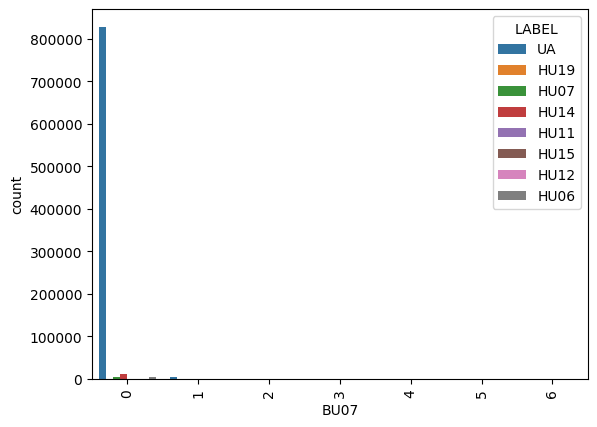

             LABEL
BU08 LABEL        
0    HU06     3021
     HU07     2718
     HU11      420
     HU12      650
     HU14     9989
     HU15      365
     HU19      736
     UA     756017
1    HU06      144
     HU07      927
     HU11       18
     HU12       24
     HU14      687
     HU15       47
     HU19       19
     UA      72439
2    HU06       11
     HU07       73
     HU11        1
     HU12        2
     HU14       73
     HU15        2
     HU19        3
     UA       3914
3    HU06        1
     HU07       10
     HU14        5
     UA        342
4    HU06        1
     HU15        1
     HU19        1
     UA         45
5    UA         10
6    UA          1
7    UA          1
8    UA          1





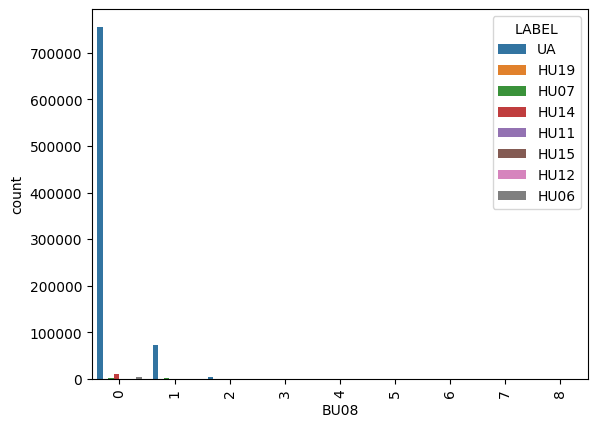

             LABEL
BU09 LABEL        
0    HU06     2354
     HU07     3234
     HU11      270
     HU12      480
     HU14     7461
     HU15      343
     HU19      517
     UA     708326
1    HU06      655
     HU07      427
     HU11      119
     HU12      158
     HU14     2789
     HU15       62
     HU19      203
     UA     110347
2    HU06      126
     HU07       61
     HU11       35
     HU12       29
     HU14      417
     HU15        6
     HU19       29
     UA      11779
3    HU06       28
     HU07        6
     HU11       12
     HU12        5
     HU14       66
     HU15        4
     HU19        9
     UA       1710
4    HU06        9
     HU11        2
     HU12        2
     HU14       14
     HU19        1
     UA        411
5    HU06        4
     HU12        2
     HU14        3
     UA        125
6    HU06        1
     HU14        2
     UA         34
7    HU14        1
     UA         20
8    HU06        1
     HU11        1
     UA          6
9    UA     

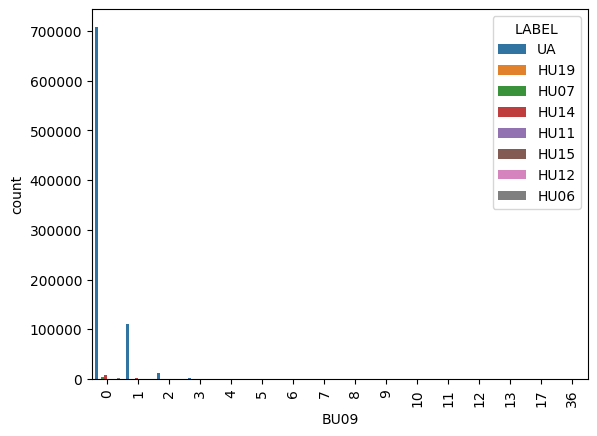

             LABEL
BU10 LABEL        
0    HU06     3108
     HU07     3718
     HU11      430
     HU12      660
     HU14    10618
     HU15      380
     HU19      743
     UA     797425
1    HU06       66
     HU07       10
     HU11        6
     HU12       16
     HU14      124
     HU15       34
     HU19       15
     UA      33817
2    HU06        4
     HU11        2
     HU14       11
     HU19        1
     UA       1305
3    HU11        1
     HU14        1
     HU15        1
     UA        170
4    UA         38
5    UA         11
6    UA          2
8    UA          2





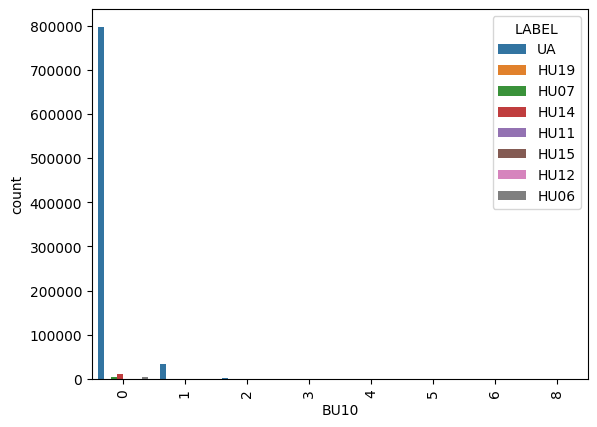

             LABEL
BU11 LABEL        
0    HU06     2978
     HU07     3594
     HU11      421
     HU12      658
     HU14    10538
     HU15      307
     HU19      749
     UA     775509
1    HU06      154
     HU07      120
     HU11       15
     HU12       15
     HU14      176
     HU15       92
     HU19        9
     UA      48938
2    HU06       42
     HU07       14
     HU11        3
     HU12        2
     HU14       33
     HU15       13
     UA       7369
3    HU06        3
     HU12        1
     HU14        6
     HU15        3
     HU19        1
     UA        797
4    HU06        1
     HU14        1
     UA        124
5    UA         23
6    UA          5
7    UA          1
8    UA          3
11   UA          1





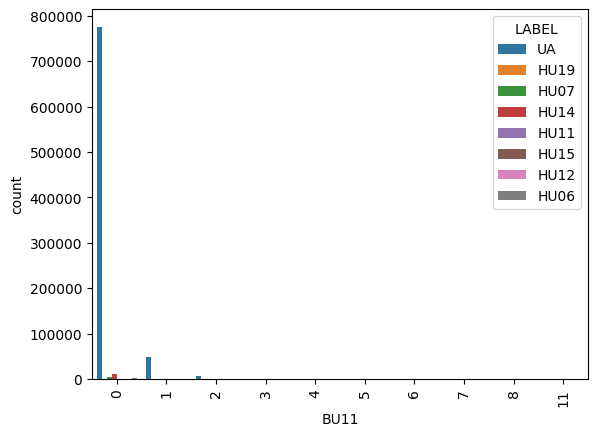

             LABEL
BU12 LABEL        
0    HU06     3178
     HU07     3728
     HU11      439
     HU12      676
     HU14    10754
     HU15      415
     HU19      759
     UA     832761
1    UA          9





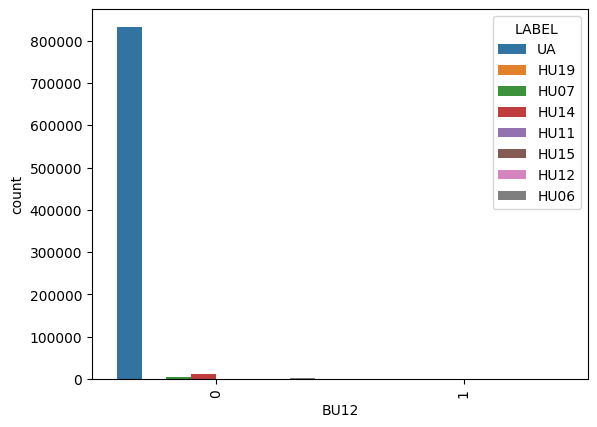

             LABEL
BU13 LABEL        
0    HU06     3055
     HU07     3594
     HU11      425
     HU12      657
     HU14    10197
     HU15      397
     HU19      729
     UA     796784
1    HU06      113
     HU07      125
     HU11       13
     HU12       19
     HU14      515
     HU15       17
     HU19       28
     UA      32459
2    HU06       10
     HU07        9
     HU11        1
     HU14       34
     HU15        1
     HU19        2
     UA       2941
3    HU14        6
     UA        416
4    HU14        2
     UA        101
5    UA         40
6    UA         12
7    UA          6
8    UA          4
9    UA          2
11   UA          3
12   UA          1
22   UA          1





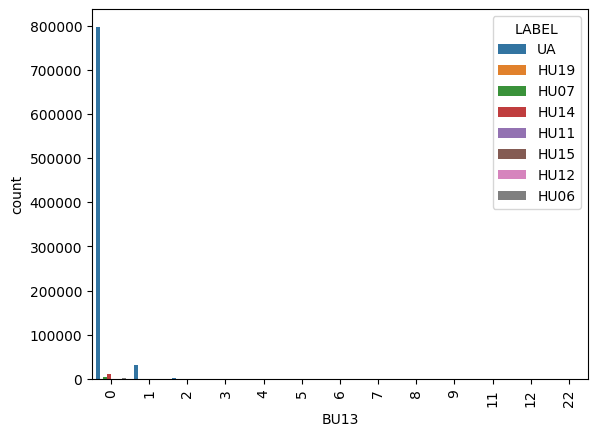

             LABEL
BU14 LABEL        
0    HU06     3175
     HU07     3728
     HU11      439
     HU12      676
     HU14    10753
     HU15      415
     HU19      759
     UA     832527
1    HU06        2
     HU14        1
     UA        211
2    HU06        1
     UA         27
3    UA          4
4    UA          1





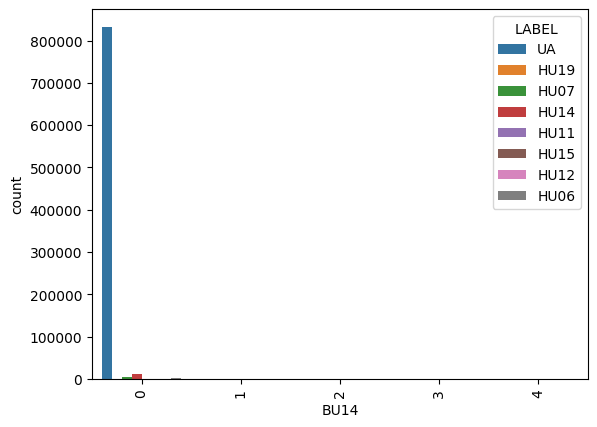

             LABEL
BU15 LABEL        
0    HU06     3172
     HU07     3726
     HU11      438
     HU12      676
     HU14    10749
     HU15      415
     HU19      759
     UA     831996
1    HU06        5
     HU07        2
     HU11        1
     HU14        3
     UA        733
2    HU06        1
     HU14        2
     UA         41





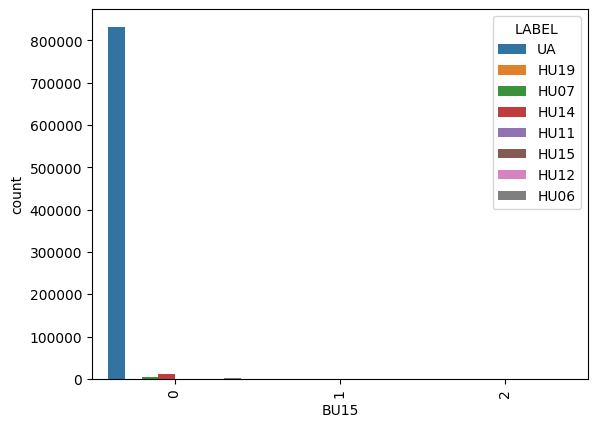

             LABEL
BU16 LABEL        
0    HU06     2498
     HU07     2859
     HU11      349
     HU12      565
     HU14     8902
     HU15      335
     HU19      606
     UA     745528
1    HU06      574
     HU07      708
     HU11       72
     HU12      100
     HU14     1603
     HU15       58
     HU19      140
     UA      78074
2    HU06       85
     HU07      138
     HU11        9
     HU12       11
     HU14      208
     HU15       18
     HU19       12
     UA       8071
3    HU06       17
     HU07       17
     HU11        8
     HU14       33
     HU15        4
     HU19        1
     UA        896
4    HU06        3
     HU07        6
     HU11        1
     HU14        7
     UA        157
5    HU14        1
     UA         28
6    HU06        1
     UA          9
7    UA          1
8    UA          2
10   UA          2
12   UA          1
13   UA          1





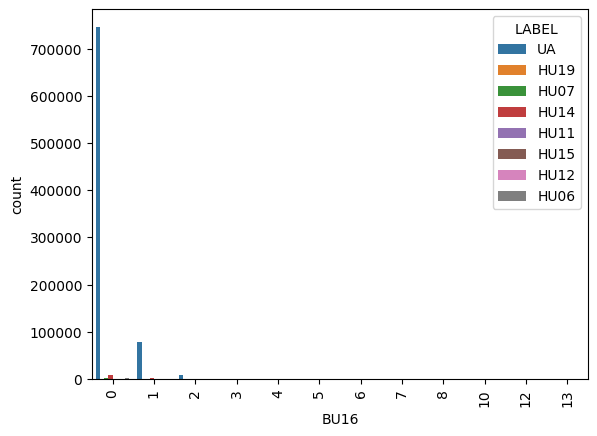

             LABEL
BU17 LABEL        
0    HU06     2665
     HU07     2822
     HU11      328
     HU12      484
     HU14     8050
     HU15      356
     HU19      584
     UA     686862
1    HU06      396
     HU07      784
     HU11       84
     HU12      167
     HU14     2335
     HU15       53
     HU19      146
     UA     129755
2    HU06      100
     HU07      106
     HU11       20
     HU12       17
     HU14      316
     HU15        5
     HU19       24
     UA      14046
3    HU06       14
     HU07       14
     HU11        4
     HU12        5
     HU14       43
     HU15        1
     HU19        5
     UA       1723
4    HU06        3
     HU07        1
     HU11        2
     HU12        3
     HU14        9
     UA        304
5    HU07        1
     UA         51
6    HU11        1
     HU14        1
     UA         17
7    UA          4
8    UA          2
9    UA          2
10   UA          2
11   UA          2





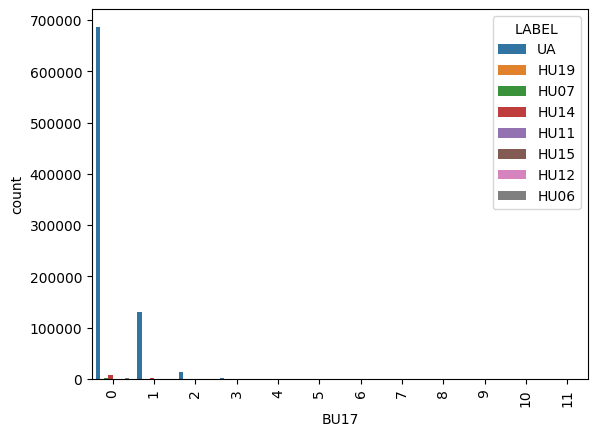

             LABEL
BU18 LABEL        
0    HU06     3079
     HU07     3721
     HU11      436
     HU12      673
     HU14    10680
     HU15      414
     HU19      752
     UA     825572
1    HU06       91
     HU07        7
     HU11        3
     HU12        3
     HU14       68
     HU15        1
     HU19        7
     UA       6862
2    HU06        8
     HU14        5
     UA        304
3    HU14        1
     UA         29
4    UA          2
5    UA          1





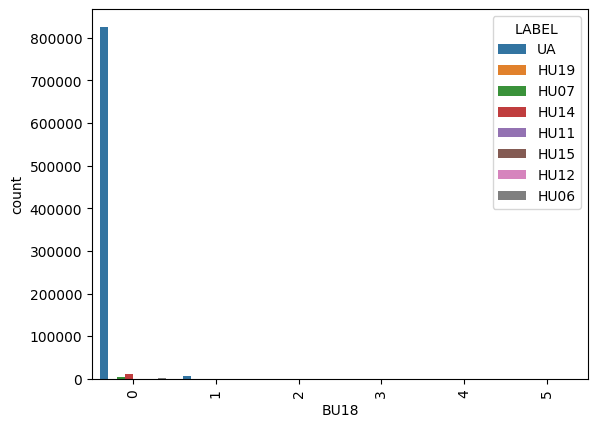

             LABEL
BU19 LABEL        
0    HU06     2663
     HU07     3585
     HU11      331
     HU12      622
     HU14     9899
     HU15      394
     HU19      663
     UA     799704
1    HU06      401
     HU07      120
     HU11       76
     HU12       42
     HU14      695
     HU15       19
     HU19       79
     UA      27475
2    HU06       74
     HU07       19
     HU11       25
     HU12        9
     HU14      131
     HU15        1
     HU19       14
     UA       4343
3    HU06       33
     HU07        3
     HU11        4
     HU12        1
     HU14       23
     HU19        2
     UA        913
4    HU06        4
     HU07        1
     HU11        2
     HU12        1
     HU14        4
     HU19        1
     UA        224
5    HU06        3
     HU11        1
     HU12        1
     HU14        1
     UA         76
6    HU15        1
     UA         16
7    HU14        1
     UA         10
8    UA          7
9    UA          1
10   UA          1





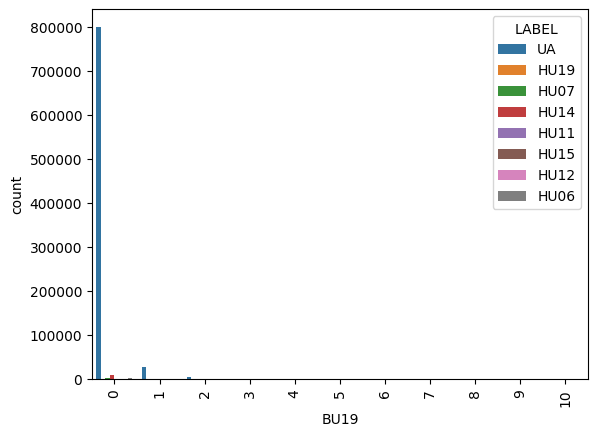

             LABEL
BU20 LABEL        
0    HU06     3168
     HU07     3724
     HU11      435
     HU12      668
     HU14    10738
     HU15      415
     HU19      751
     UA     812328
1    HU06        9
     HU07        4
     HU11        4
     HU12        8
     HU14       16
     HU19        8
     UA      19780
2    HU06        1
     UA        577
3    UA         59
4    UA         16
5    UA          6
6    UA          3
8    UA          1





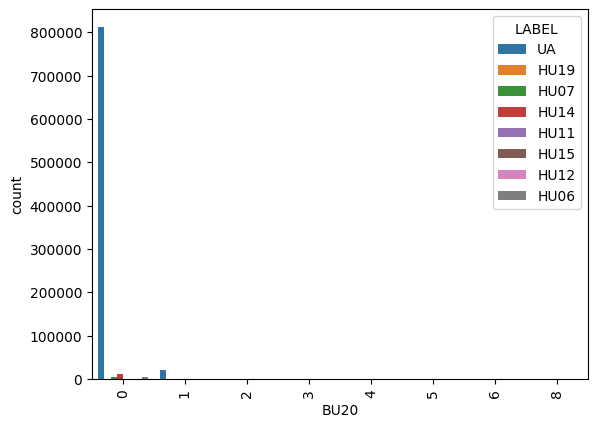

             LABEL
BU21 LABEL        
0    HU06     3177
     HU07     3728
     HU11      439
     HU12      675
     HU14    10746
     HU15      415
     HU19      759
     UA     829243
1    HU06        1
     HU12        1
     HU14        8
     UA       3441
2    UA         73
3    UA          7
4    UA          4
5    UA          1
8    UA          1





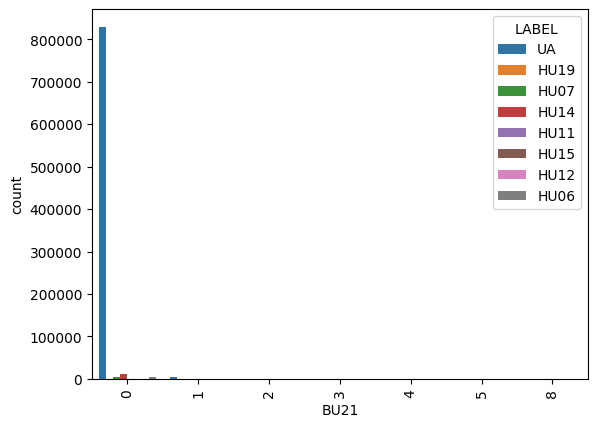

             LABEL
BU22 LABEL        
0    HU06     3165
     HU07     3720
     HU11      436
     HU12      674
     HU14    10734
     HU15      414
     HU19      758
     UA     831936
1    HU06       13
     HU07        8
     HU11        3
     HU12        2
     HU14       19
     HU15        1
     HU19        1
     UA        793
2    HU14        1
     UA         37
3    UA          3
4    UA          1





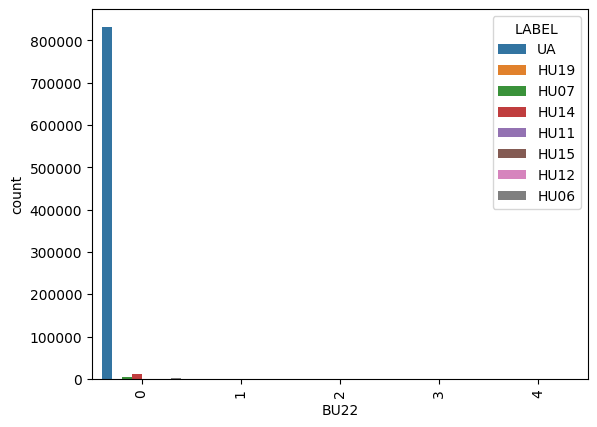

             LABEL
BU23 LABEL        
0    HU06     2692
     HU07     3723
     HU11      439
     HU12      676
     HU14    10742
     HU15      415
     HU19      758
     UA     684421
1    HU06      439
     HU07        5
     HU14       12
     HU19        1
     UA     143385
2    HU06       46
     UA       4746
3    HU06        1
     UA        186
4    UA         29
5    UA          3





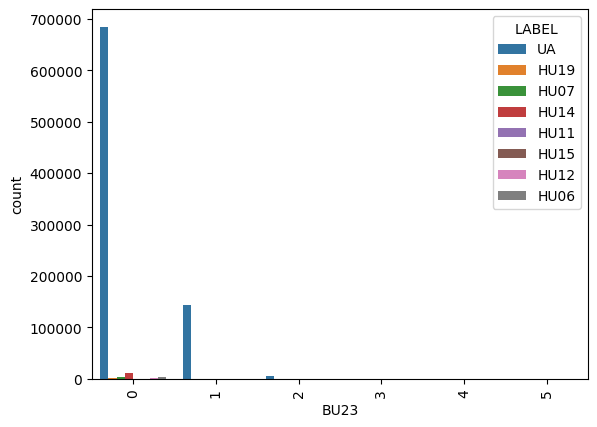

             LABEL
BU24 LABEL        
0    HU06     3130
     HU07     3682
     HU11      435
     HU12      673
     HU14    10540
     HU15      409
     HU19      739
     UA     808692
1    HU06       43
     HU07       44
     HU11        4
     HU12        2
     HU14      208
     HU15        6
     HU19       18
     UA      23076
2    HU06        5
     HU07        2
     HU14        6
     HU19        2
     UA        967
3    HU12        1
     UA         34
4    UA          1





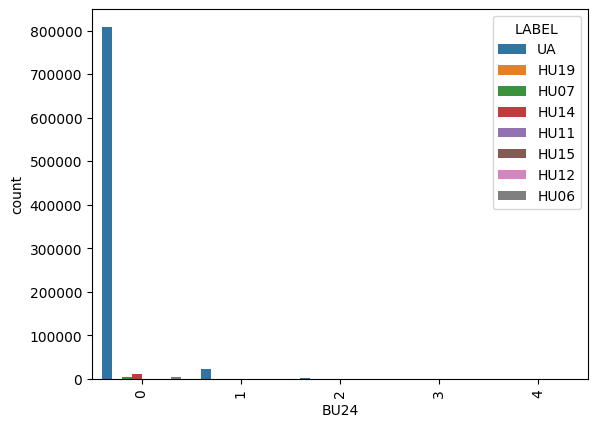

             LABEL
HU01 LABEL        
0    HU06     3177
     HU07     3727
     HU11      438
     HU12      676
     HU14    10747
     HU15      415
     HU19      759
     UA     832571
1    HU06        1
     HU07        1
     HU11        1
     HU14        7
     UA        184
2    UA         10
5    UA          1
10   UA          4





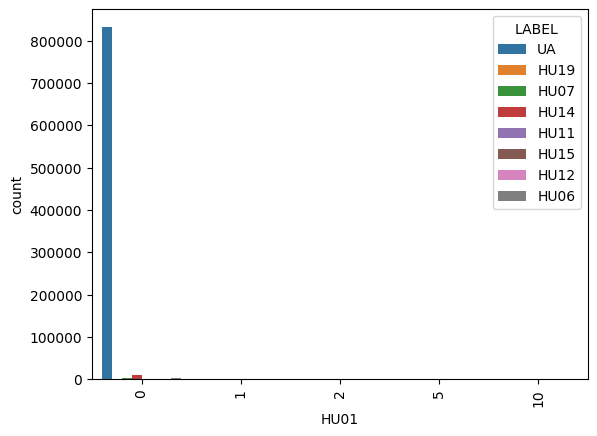

             LABEL
HU02 LABEL        
0    HU06     3178
     HU07     3727
     HU11      439
     HU12      676
     HU14    10754
     HU15      414
     HU19      759
     UA     832756
1    HU07        1
     HU15        1
     UA         14





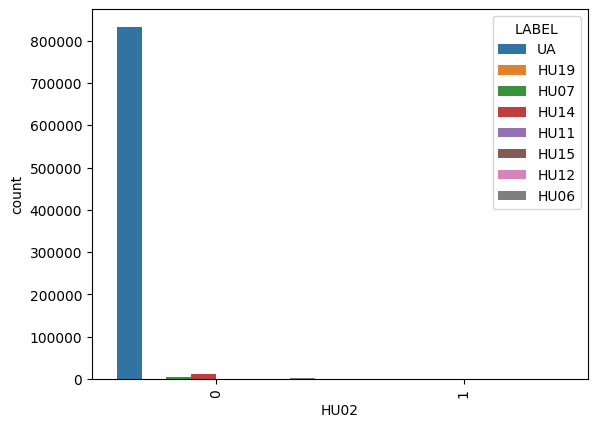

             LABEL
HU03 LABEL        
0    HU06     3174
     HU07     3727
     HU11      439
     HU12      676
     HU14    10750
     HU15      414
     HU19      759
     UA     832246
1    HU06        3
     HU07        1
     HU14        2
     HU15        1
     UA        459
2    HU06        1
     HU14        2
     UA         45
3    UA          9
4    UA          7
5    UA          1
6    UA          1
8    UA          1
9    UA          1





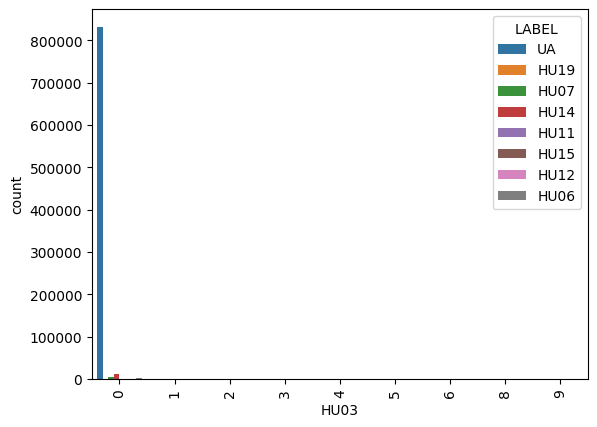

             LABEL
HU04 LABEL        
0    HU06     3039
     HU07     3715
     HU11      430
     HU12      667
     HU14    10639
     HU15      410
     HU19      742
     UA     823768
1    HU06      138
     HU07       13
     HU11        9
     HU12        9
     HU14      114
     HU15        5
     HU19       17
     UA       8978
2    HU06        1
     HU14        1
     UA         24





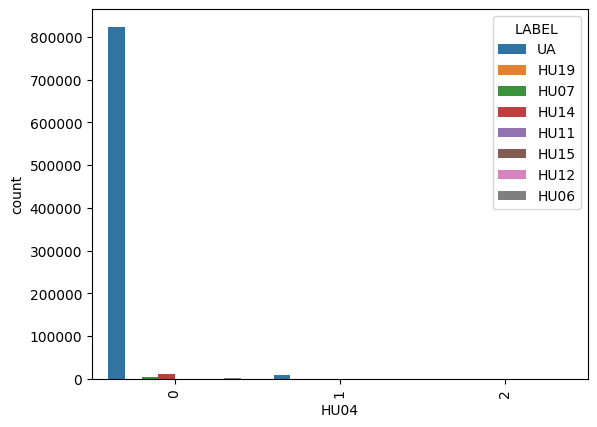

             LABEL
HU05 LABEL        
0    HU06     3058
     HU07     3663
     HU11      423
     HU12      674
     HU14    10684
     HU15      394
     HU19      756
     UA     829164
1    UA         86
2    HU06      120
     HU07       65
     HU11       16
     HU12        2
     HU14       70
     HU15       21
     HU19        3
     UA       3520





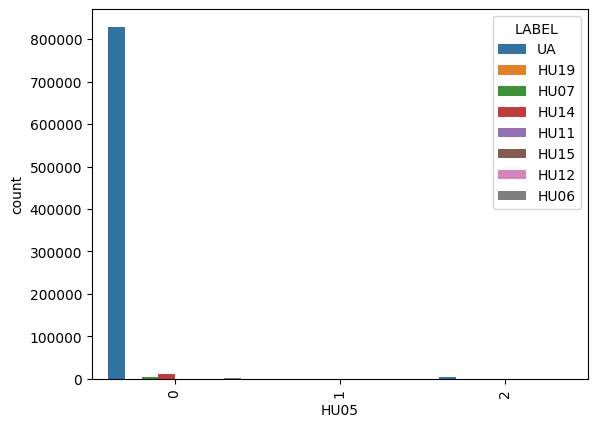

             LABEL
HU06 LABEL        
0    HU06     3100
     HU07     3620
     HU11      356
     HU12      638
     HU14    10249
     HU15      390
     HU19      683
     UA     821359
1    HU06       66
     HU07       98
     HU11       68
     HU12       30
     HU14      427
     HU15       22
     HU19       63
     UA      10262
2    HU06       11
     HU07        9
     HU11       11
     HU12        7
     HU14       67
     HU15        2
     HU19       12
     UA        992
3    HU06        1
     HU11        2
     HU14        7
     HU19        1
     UA        113
4    HU07        1
     HU11        1
     HU12        1
     HU14        3
     HU15        1
     UA         33
5    HU11        1
     HU14        1
     UA          6
6    UA          4
9    UA          1





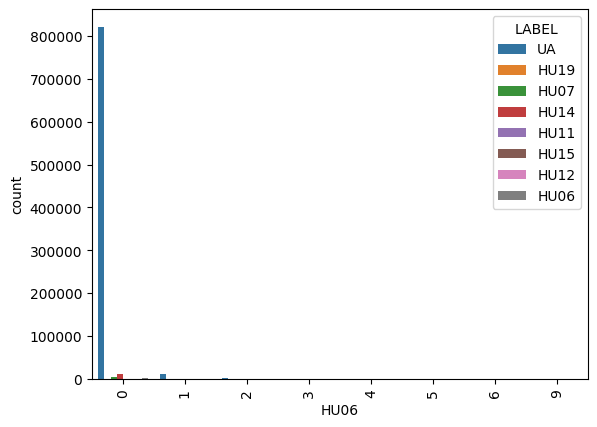

             LABEL
HU07 LABEL        
0    HU06     3141
     HU07     3728
     HU11      426
     HU12      665
     HU14    10593
     HU15      415
     HU19      753
     UA     827348
1    HU06       37
     HU11       13
     HU12       11
     HU14      161
     HU19        6
     UA       5422





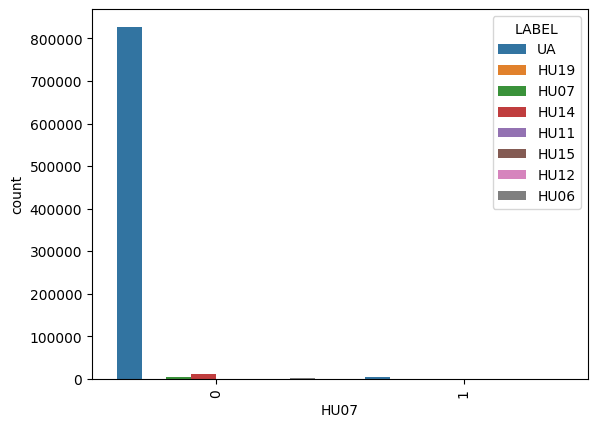

             LABEL
HU10 LABEL        
0    HU06     3150
     HU07     3701
     HU11      432
     HU12      652
     HU14    10632
     HU15      409
     HU19      752
     UA     828893
1    HU06       26
     HU07       25
     HU11        6
     HU12       23
     HU14      107
     HU15        6
     HU19        7
     UA       3569
2    HU06        2
     HU07        2
     HU11        1
     HU12        1
     HU14       14
     UA        293
3    UA         14
4    UA          1
8    HU14        1





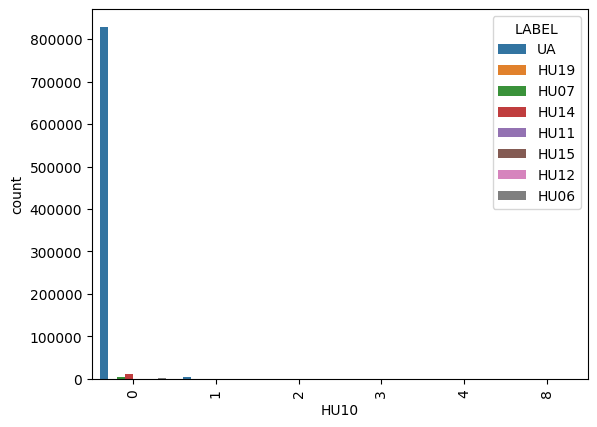

             LABEL
HU11 LABEL        
0    HU06     3122
     HU07     3719
     HU11      433
     HU12      665
     HU14    10563
     HU15      409
     HU19      732
     UA     831260
1    HU06       52
     HU07        9
     HU11        6
     HU12       10
     HU14      165
     HU15        6
     HU19       23
     UA       1388
2    HU06        3
     HU14       20
     HU19        3
     UA        104
3    HU14        5
     HU19        1
     UA         15
4    HU06        1
     HU12        1
     UA          2
5    HU14        1
     UA          1





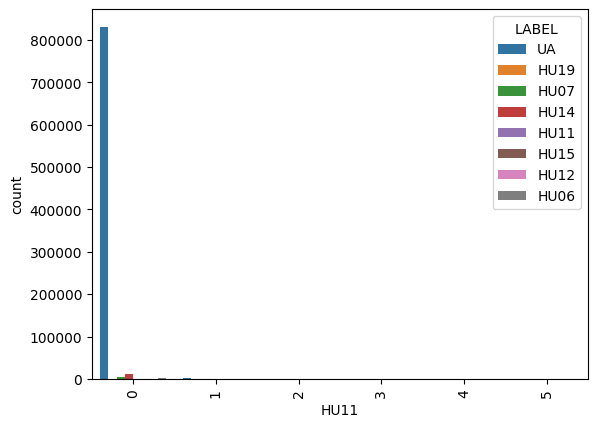

             LABEL
HU12 LABEL        
0    HU06     3167
     HU07     3727
     HU11      433
     HU12      639
     HU14    10712
     HU15      415
     HU19      750
     UA     832120
1    HU06       10
     HU07        1
     HU11        5
     HU12       28
     HU14       36
     HU19        6
     UA        625
2    HU11        1
     HU12        6
     HU14        6
     HU19        3
     UA         23
3    HU06        1
     HU12        1
     UA          2
4    HU12        1
5    HU12        1





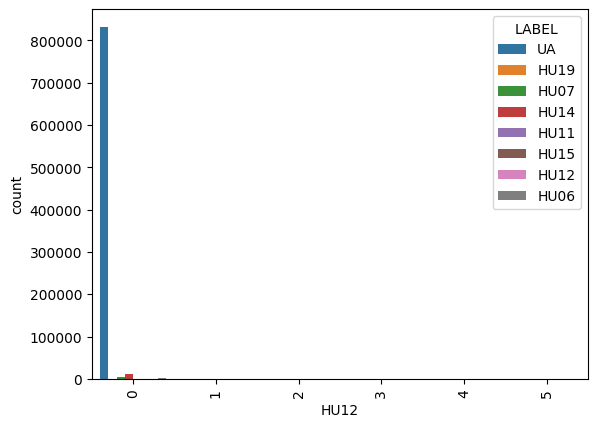

             LABEL
HU13 LABEL        
0    HU06     3177
     HU07     3728
     HU11      439
     HU12      671
     HU14    10745
     HU15      415
     HU19      759
     UA     832700
1    HU06        1
     HU12        5
     HU14        9
     UA         70





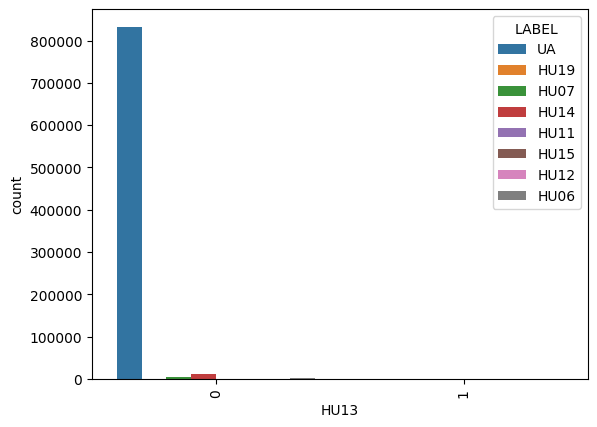

             LABEL
HU14 LABEL        
0    HU06     2906
     HU07     3433
     HU11      346
     HU12      577
     HU14     9953
     HU15      382
     HU19      640
     UA     818062
1    HU06      231
     HU07      260
     HU11       80
     HU12       82
     HU14      628
     HU15       27
     HU19       98
     UA      14270
2    HU06       31
     HU07       30
     HU11       10
     HU12       14
     HU14      122
     HU15        5
     HU19       15
     UA        377
3    HU06        6
     HU07        3
     HU11        2
     HU14       35
     HU15        1
     HU19        4
     UA         48
4    HU06        2
     HU11        1
     HU12        2
     HU14        8
     HU19        2
     UA         13
5    HU06        1
     HU07        1
     HU12        1
     HU14        5
7    HU07        1
     HU14        1
8    HU06        1
9    HU14        2





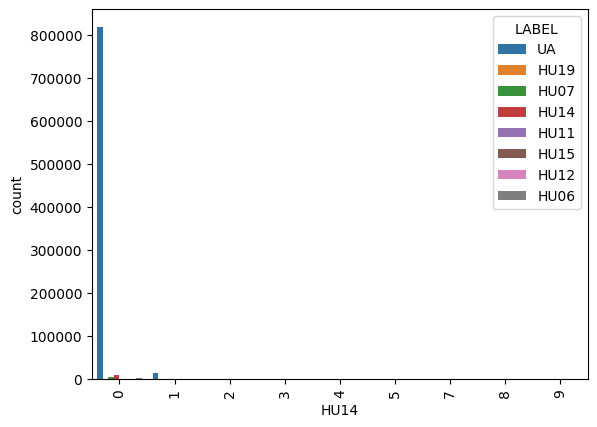

             LABEL
HU15 LABEL        
0    HU06     3173
     HU07     3728
     HU11      433
     HU12      673
     HU14    10736
     HU15      129
     HU19      759
     UA     832432
1    HU06        5
     HU11        6
     HU12        3
     HU14       18
     HU15      286
     UA        337
2    UA          1





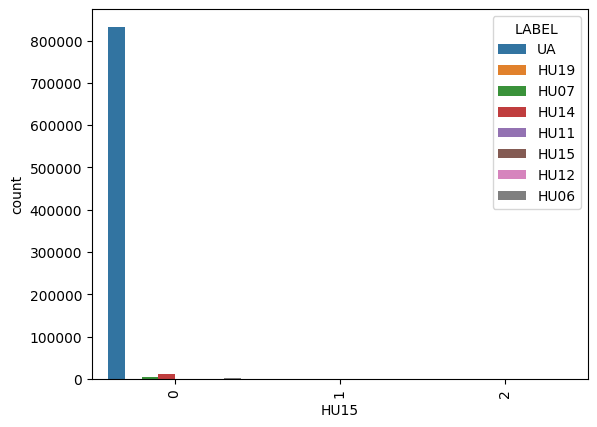

             LABEL
HU16 LABEL        
0    HU06     3172
     HU07     3725
     HU11      438
     HU12      676
     HU14    10739
     HU15      415
     HU19      757
     UA     832476
1    HU06        6
     HU07        2
     HU11        1
     HU14       15
     HU19        2
     UA        274
2    HU07        1
     UA         19
3    UA          1





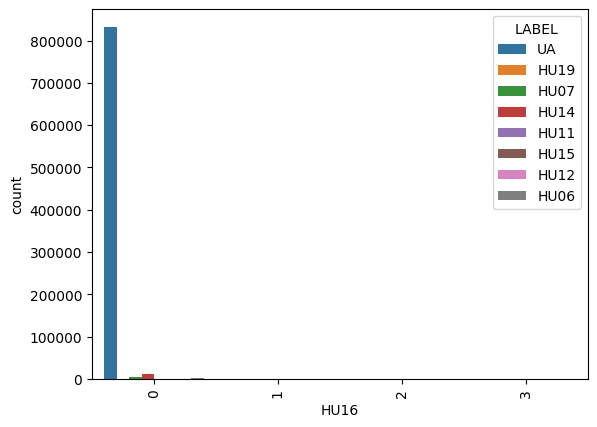

             LABEL
HU17 LABEL        
0    HU06     3003
     HU07     3703
     HU11      376
     HU12      545
     HU14    10116
     HU15      406
     HU19      570
     UA     826522
1    HU06      117
     HU07       18
     HU11       39
     HU12       81
     HU14      433
     HU15        5
     HU19      112
     UA       4780
2    HU06       33
     HU07        6
     HU11       10
     HU12       27
     HU14      129
     HU15        2
     HU19       46
     UA        951
3    HU06       13
     HU07        1
     HU11       11
     HU12       11
     HU14       45
     HU15        1
     HU19       20
     UA        300
4    HU06        9
     HU11        1
     HU12        8
     HU14       11
     HU15        1
     HU19        3
     UA        110
5    HU11        2
     HU12        2
     HU14        7
     HU19        1
     UA         46
6    HU06        1
     HU14        8
     HU19        4
     UA         20
7    HU12        2
     HU14        2
     HU19   

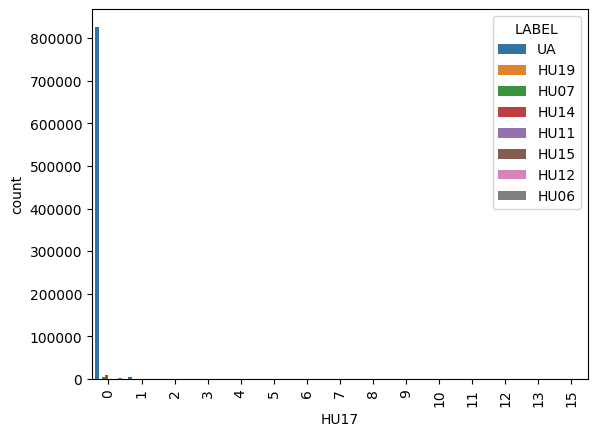

             LABEL
HU18 LABEL        
0    HU06     2882
     HU07     3545
     HU11      408
     HU12      670
     HU14    10395
     HU15      372
     HU19      741
     UA     816792
1    HU06      291
     HU07      183
     HU11       31
     HU12        6
     HU14      359
     HU15       43
     HU19       17
     UA      15911
2    HU06        5
     HU19        1
     UA         65
3    UA          2





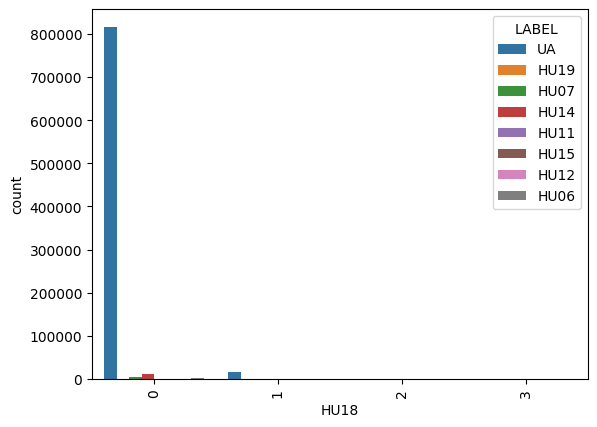

             LABEL
HU19 LABEL        
0    HU06     3117
     HU07     3704
     HU11      414
     HU12      638
     HU14    10570
     HU15      413
     HU19      705
     UA     828131
1    HU06       55
     HU07       20
     HU11       21
     HU12       33
     HU14      145
     HU15        2
     HU19       29
     UA       4219
2    HU06        5
     HU07        1
     HU12        2
     HU14       26
     HU19       11
     UA        291
3    HU06        1
     HU11        1
     HU12        2
     HU14        9
     HU19        9
     UA         75
4    HU07        1
     HU11        2
     HU12        1
     HU14        2
     HU19        2
     UA         24
5    HU14        1
     HU19        2
     UA         13
6    HU11        1
     HU19        1
     UA          8
7    HU07        2
     HU14        1
     UA          4
8    UA          4
10   UA          1





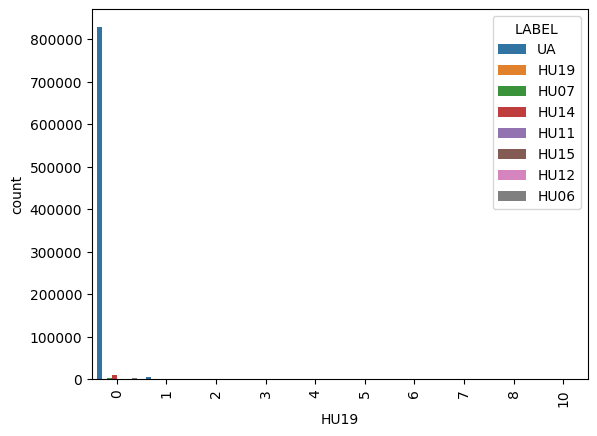

In [19]:

def target_analysis_cat(dataframe, target, cat_col, plot=False):
    print(dataframe.groupby([cat_col, target]).agg({target: "count"}), end="\n\n\n\n")
    
    if plot==True:
        sns.countplot(x=cat_col, hue="LABEL", data=dataframe)
        plt.xticks(rotation=90)
        plt.show()

for col in train_cat_cols:
    target_analysis_cat(train, "LABEL", col, True)
    

**Eksik Değer Analizi**

In [20]:
#O'dan küçük olamayan özellik var mı? (Getiri zarar ettiyse 0'dan küçük olabilir.)
train_0dan_kucuk = [col for col in train_num_cols if (train[col].min() < 0)]
test_0dan_kucuk = [col for col in test_num_cols if (test[col].min() < 0)]
print(train_0dan_kucuk)
print(test_0dan_kucuk)


['SORU_GELIR_CVP', 'GETIRI']
['SORU_GELIR_CVP', 'GETIRI']


In [21]:
train["SORU_GELIR_CVP"] = np.where(train["SORU_GELIR_CVP"]<0, np.nan, train["SORU_GELIR_CVP"])
test["SORU_GELIR_CVP"] = np.where(test["SORU_GELIR_CVP"]<0, np.nan, test["SORU_GELIR_CVP"])

In [22]:
#Müşteri segmentine göre yatırım karakteri
train["SORU_YATIRIM_KARAKTERI_CVP"] = train["SORU_YATIRIM_KARAKTERI_CVP"].fillna(train.groupby("PP_MUSTERI_SEGMENTI")["SORU_YATIRIM_KARAKTERI_CVP"].transform(lambda x: x.mode()[0]))
test["SORU_YATIRIM_KARAKTERI_CVP"] = test["SORU_YATIRIM_KARAKTERI_CVP"].fillna(test.groupby("PP_MUSTERI_SEGMENTI")["SORU_YATIRIM_KARAKTERI_CVP"].transform(lambda x: x.mode()[0]))

In [23]:
#Cinsiyete göre eğitim doldurma
train["SORU_EGITIM_CVP"] = train["SORU_EGITIM_CVP"].fillna(train.groupby(["PP_CINSIYET","PP_MUSTERI_SEGMENTI"])["SORU_EGITIM_CVP"].transform(lambda x: x.mode()[0]))
test["SORU_EGITIM_CVP"] = test["SORU_EGITIM_CVP"].fillna(test.groupby(["PP_CINSIYET","PP_MUSTERI_SEGMENTI"])["SORU_EGITIM_CVP"].transform(lambda x: x.mode()[0]))

In [24]:
#Eğitime göre Meslek doldurma
train["PP_MESLEK"] = train["PP_MESLEK"].fillna(train.groupby(["SORU_EGITIM_CVP","PP_CINSIYET"])["PP_MESLEK"].transform(lambda x: x.mode()[0]))
test["PP_MESLEK"] = test["PP_MESLEK"].fillna(test.groupby(["SORU_EGITIM_CVP","PP_CINSIYET"])["PP_MESLEK"].transform(lambda x: x.mode()[0]))

In [25]:
#Eğitime göre Eğitiö_RG doldurma
train["SORU_EGITIM_RG"] = train["SORU_EGITIM_RG"].fillna(train.groupby("SORU_EGITIM_CVP")["SORU_EGITIM_RG"].transform("mean"))
test["SORU_EGITIM_RG"] = test["SORU_EGITIM_RG"].fillna(test.groupby("SORU_EGITIM_CVP")["SORU_EGITIM_RG"].transform("mean"))

In [26]:
#Cinsiyete göre medeni hal doldurma
train["SORU_MEDENI_HAL_CVP"] = train["SORU_MEDENI_HAL_CVP"].fillna(train.groupby(["SORU_EGITIM_CVP","PP_CINSIYET"])["SORU_MEDENI_HAL_CVP"].transform(lambda x: x.mode()[0]))
test["SORU_MEDENI_HAL_CVP"] = test["SORU_MEDENI_HAL_CVP"].fillna(test.groupby(["SORU_EGITIM_CVP","PP_CINSIYET"])["SORU_MEDENI_HAL_CVP"].transform(lambda x: x.mode()[0]))

In [27]:
#Medeni Hale göre medeni hal_RG doldurma
train["SORU_MEDENI_HAL_RG"] = train["SORU_MEDENI_HAL_RG"].fillna(train.groupby("PP_CINSIYET")["SORU_MEDENI_HAL_RG"].transform("mean"))
test["SORU_MEDENI_HAL_RG"] = test["SORU_MEDENI_HAL_RG"].fillna(test.groupby("PP_CINSIYET")["SORU_MEDENI_HAL_RG"].transform("mean"))

In [28]:
#Mesleğe göre gelir
train["SORU_GELIR_CVP"] = train["SORU_GELIR_CVP"].fillna(train.groupby("PP_MESLEK")["SORU_GELIR_CVP"].transform("mean"))
test["SORU_GELIR_CVP"] = test["SORU_GELIR_CVP"].fillna(test.groupby("PP_MESLEK")["SORU_GELIR_CVP"].transform("mean"))

**Aykırı Değer Analizi**

In [29]:
threshold_cols = ["PP_YAS","SORU_GELIR_CVP"]

In [30]:
def outlier_threshold(dataframe, col_name, q1=0.2, q3=0.8):
    quartile1 = dataframe[col].quantile(q1)
    quartile3 = dataframe[col].quantile(q3)
    interguantile = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interguantile
    upp_limit = quartile3 + 1.5 * interguantile
    return low_limit, upp_limit

In [31]:
def check_outlier(dataframe, col_name):
    low_limit, upp_limit = outlier_threshold(dataframe, col_name)
    if dataframe[(dataframe[col] < low_limit) | (dataframe[col] > upp_limit)].any(axis=None):
        return True
    else:
        return False
    
for col in threshold_cols:
    print(col,":", check_outlier(train, col))
print("#########")
for col in threshold_cols:
    print(col,":", check_outlier(test, col))

PP_YAS : True
SORU_GELIR_CVP : True
#########
PP_YAS : True
SORU_GELIR_CVP : True


In [32]:
#Aykırı değerleri sınır değerleri ile doldurdum.
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = int(low_limit)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = int(up_limit)

for col in threshold_cols:
    replace_with_thresholds(train, col)
    
for col in threshold_cols:
    replace_with_thresholds(test, col)

In [33]:
for col in threshold_cols:
    print(col,":", check_outlier(train, col))
print("#########")
for col in threshold_cols:
    print(col,":", check_outlier(test, col))

PP_YAS : False
SORU_GELIR_CVP : False
#########
PP_YAS : False
SORU_GELIR_CVP : False


**Özellik Çıkarımları**

In [34]:
print(pd.DataFrame({"PP-MESLEK": train["PP_MESLEK"].value_counts(),
                       "Ratio": 100 * train["PP_MESLEK"].value_counts() / len(train["PP_MESLEK"])}))
    

                                            PP-MESLEK  Ratio
PP_MESLEK                                                   
İşçi                                           150799 17.684
Diğer                                          128651 15.087
Ev Hanımı                                      123321 14.462
Öğrenci                                        118350 13.879
Öğretmen                                        41501  4.867
Esnaf                                           30173  3.538
Memur                                           29595  3.471
Serbest Meslek                                  27226  3.193
Mühendis                                        18972  2.225
Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)      12942  1.518
Danışman                                         8872  1.040
SSK-Sosyal Sigortalar Kurumu Emeklileri          8284  0.971
Emekli                                           7886  0.925
Akademisyen                                      7519  0.882
Banka                   

In [35]:
print(pd.DataFrame({"PP-MESLEK": test["PP_MESLEK"].value_counts(),
                       "Ratio": 100 * test["PP_MESLEK"].value_counts() / len(test["PP_MESLEK"])}))
    

                                            PP-MESLEK  Ratio
PP_MESLEK                                                   
Öğrenci                                         35814 18.307
İşçi                                            34674 17.724
Diğer                                           28102 14.365
Ev Hanımı                                       21596 11.039
Öğretmen                                         9043  4.622
Esnaf                                            6210  3.174
Memur                                            6029  3.082
Serbest Meslek                                   4718  2.412
Mühendis                                         4162  2.127
Tacir ve Esnaf                                   2842  1.453
Hizmet Çalışanı                                  2680  1.370
Emekli                                           2529  1.293
Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)       2505  1.280
Ordu Mensubu                                     2120  1.084
Danışman                

In [36]:
train.loc[train["PP_MESLEK"] == "İşçi", "PP_MESLEK_İşçi"] = 1
train.loc[train["PP_MESLEK"] != "İşçi", "PP_MESLEK_İşçi"] = 0
train.loc[train["PP_MESLEK"] == "Diğer", "PP_MESLEK_Diğer"] = 1
train.loc[train["PP_MESLEK"] != "Diğer", "PP_MESLEK_Diğer"] = 0
train.loc[train["PP_MESLEK"] == "Ev Hanımı", "PP_MESLEK_Ev_Hanımı"] = 1
train.loc[train["PP_MESLEK"] != "Ev Hanımı", "PP_MESLEK_Ev_Hanımı"] = 0
train.loc[train["PP_MESLEK"] == "Öğrenci", "PP_MESLEK_Öğrenci"] = 1
train.loc[train["PP_MESLEK"] != "Öğrenci", "PP_MESLEK_Öğrenci"] = 0
train.loc[train["PP_MESLEK"] == "Öğretmen", "PP_MESLEK_Öğretmen"] = 1
train.loc[train["PP_MESLEK"] != "Öğretmen", "PP_MESLEK_Öğretmen"] = 0
train.loc[train["PP_MESLEK"] == "Esnaf", "PP_MESLEK_Esnaf"] = 1
train.loc[train["PP_MESLEK"] != "Esnaf", "PP_MESLEK_Esnaf"] = 0
train.loc[train["PP_MESLEK"] == "Memur", "PP_MESLEK_Memur"] = 1
train.loc[train["PP_MESLEK"] != "Memur", "PP_MESLEK_Memur"] = 0
train.loc[train["PP_MESLEK"] == "Serbest Meslek", "PP_MESLEK_Serbest_Meslek"] = 1
train.loc[train["PP_MESLEK"] != "Serbest Meslek", "PP_MESLEK_Serbest_Meslek"] = 0
train.loc[train["PP_MESLEK"] == "Mühendis", "PP_MESLEK_Mühendis"] = 1
train.loc[train["PP_MESLEK"] != "Mühendis", "PP_MESLEK_Mühendis"] = 0
train.loc[train["PP_MESLEK"] == "Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)", "PP_MESLEK_Emekli_Sgkbilinmiyor"] = 1
train.loc[train["PP_MESLEK"] != "Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)", "PP_MESLEK_Emekli_Sgkbilinmiyor"] = 0
train.loc[train["PP_MESLEK"] == "Danışman", "PP_MESLEK_Danışman"] = 1
train.loc[train["PP_MESLEK"] != "Danışman", "PP_MESLEK_Danışman"] = 0
train.loc[train["PP_MESLEK"] == "Tacir ve Esnaf", "PP_MESLEK_Tacir_Esnaf"] = 1
train.loc[train["PP_MESLEK"] != "Tacir ve Esnaf", "PP_MESLEK_Tacir_Esnaf"] = 0
train.loc[train["PP_MESLEK"] == "Hizmet Çalışanı", "PP_MESLEK_Hizmet_Çalışanı"] = 1
train.loc[train["PP_MESLEK"] != "Hizmet Çalışanı", "PP_MESLEK_Hizmet_Çalışanı"] = 0
train.loc[train["PP_MESLEK"] == "Emekli", "PP_MESLEK_Emekli"] = 1
train.loc[train["PP_MESLEK"] != "Emekli", "PP_MESLEK_Emekli"] = 0
train.loc[train["PP_MESLEK"] == "Ordu Mensubu", "PP_MESLEK_Ordu"] = 1
train.loc[train["PP_MESLEK"] != "Ordu Mensubu", "PP_MESLEK_Ordu"] = 0
train.loc[train["PP_MESLEK"] == "SSK-Sosyal Sigortalar Kurumu Emeklileri", "PP_MESLEK_SSK"] = 1
train.loc[train["PP_MESLEK"] != "SSK-Sosyal Sigortalar Kurumu Emeklileri", "PP_MESLEK_SSK"] = 0
train.loc[train["PP_MESLEK"] == "Akademisyen", "PP_MESLEK_Akademisyen"] = 1
train.loc[train["PP_MESLEK"] != "Akademisyen", "PP_MESLEK_Akademisyen"] = 0


In [37]:
test.loc[test["PP_MESLEK"] == "İşçi", "PP_MESLEK_İşçi"] = 1
test.loc[test["PP_MESLEK"] != "İşçi", "PP_MESLEK_İşçi"] = 0
test.loc[test["PP_MESLEK"] == "Diğer", "PP_MESLEK_Diğer"] = 1
test.loc[test["PP_MESLEK"] != "Diğer", "PP_MESLEK_Diğer"] = 0
test.loc[test["PP_MESLEK"] == "Ev Hanımı", "PP_MESLEK_Ev_Hanımı"] = 1
test.loc[test["PP_MESLEK"] != "Ev Hanımı", "PP_MESLEK_Ev_Hanımı"] = 0
test.loc[test["PP_MESLEK"] == "Öğrenci", "PP_MESLEK_Öğrenci"] = 1
test.loc[test["PP_MESLEK"] != "Öğrenci", "PP_MESLEK_Öğrenci"] = 0
test.loc[test["PP_MESLEK"] == "Öğretmen", "PP_MESLEK_Öğretmen"] = 1
test.loc[test["PP_MESLEK"] != "Öğretmen", "PP_MESLEK_Öğretmen"] = 0
test.loc[test["PP_MESLEK"] == "Esnaf", "PP_MESLEK_Esnaf"] = 1
test.loc[test["PP_MESLEK"] != "Esnaf", "PP_MESLEK_Esnaf"] = 0
test.loc[test["PP_MESLEK"] == "Memur", "PP_MESLEK_Memur"] = 1
test.loc[test["PP_MESLEK"] != "Memur", "PP_MESLEK_Memur"] = 0
test.loc[test["PP_MESLEK"] == "Serbest Meslek", "PP_MESLEK_Serbest_Meslek"] = 1
test.loc[test["PP_MESLEK"] != "Serbest Meslek", "PP_MESLEK_Serbest_Meslek"] = 0
test.loc[test["PP_MESLEK"] == "Mühendis", "PP_MESLEK_Mühendis"] = 1
test.loc[test["PP_MESLEK"] != "Mühendis", "PP_MESLEK_Mühendis"] = 0
test.loc[test["PP_MESLEK"] == "Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)", "PP_MESLEK_Emekli_Sgkbilinmiyor"] = 1
test.loc[test["PP_MESLEK"] != "Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)", "PP_MESLEK_Emekli_Sgkbilinmiyor"] = 0
test.loc[test["PP_MESLEK"] == "Danışman", "PP_MESLEK_Danışman"] = 1
test.loc[test["PP_MESLEK"] != "Danışman", "PP_MESLEK_Danışman"] = 0
test.loc[test["PP_MESLEK"] == "Tacir ve Esnaf", "PP_MESLEK_Tacir_Esnaf"] = 1
test.loc[test["PP_MESLEK"] != "Tacir ve Esnaf", "PP_MESLEK_Tacir_Esnaf"] = 0
test.loc[test["PP_MESLEK"] == "Hizmet Çalışanı", "PP_MESLEK_Hizmet_Çalışanı"] = 1
test.loc[test["PP_MESLEK"] != "Hizmet Çalışanı", "PP_MESLEK_Hizmet_Çalışanı"] = 0
test.loc[test["PP_MESLEK"] == "Emekli", "PP_MESLEK_Emekli"] = 1
test.loc[test["PP_MESLEK"] != "Emekli", "PP_MESLEK_Emekli"] = 0
test.loc[test["PP_MESLEK"] == "Ordu Mensubu", "PP_MESLEK_Ordu"] = 1
test.loc[test["PP_MESLEK"] != "Ordu Mensubu", "PP_MESLEK_Ordu"] = 0
test.loc[test["PP_MESLEK"] == "SSK-Sosyal Sigortalar Kurumu Emeklileri", "PP_MESLEK_SSK"] = 1
test.loc[test["PP_MESLEK"] != "SSK-Sosyal Sigortalar Kurumu Emeklileri", "PP_MESLEK_SSK"] = 0
test.loc[test["PP_MESLEK"] == "Akademisyen", "PP_MESLEK_Akademisyen"] = 1
test.loc[test["PP_MESLEK"] != "Akademisyen", "PP_MESLEK_Akademisyen"] = 0


In [38]:
meslekler =["İşçi","Diğer","Ev Hanımı","Öğrenci","Öğretmen","Esnaf","Memur","Serbest Meslek",
            "Serbest Meslek","Mühendis","Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)","Danışman",
            "Tacir ve Esnaf","Hizmet Çalışanı","Emekli","Ordu Mensubu",
           "SSK-Sosyal Sigortalar Kurumu Emeklileri","Akademisyen"]

rare_meslekler = [meslek for meslek in train["PP_MESLEK"].unique() if meslek not in meslekler]

train["PP_MESLEK_Rare"] = train["PP_MESLEK"].apply(lambda x: 1 if x in rare_meslekler else 0)
test["PP_MESLEK_Rare"] = test["PP_MESLEK"].apply(lambda x: 1 if x in rare_meslekler else 0)

In [39]:
#0-17 yaş arası: ERGEN
#18-65 yaş arası :GENÇ
#66-79 yaş arası :ORTA YAŞ
#80-99 yaş arası :YAŞLI

#Dünya Sağlık Örgütü Yaş dilimleri

train.loc[((train["PP_YAS"] / 12) < 18), "NEW_AGE_CAT"] = "ergen"
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 66), "NEW_AGE_CAT"] = "genc"
train.loc[((train["PP_YAS"] / 12) >= 66) & ((train["PP_YAS"] / 12) < 80), "NEW_AGE_CAT"] = "ortayasli"
train.loc[((train["PP_YAS"] / 12) >= 80 ), "NEW_AGE_CAT"] = "yasli"

test.loc[((test["PP_YAS"] / 12) < 18), "NEW_AGE_CAT"] = "ergen"
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 66), "NEW_AGE_CAT"] = "genc"
test.loc[((test["PP_YAS"] / 12) >= 66) & ((test["PP_YAS"] / 12) < 80), "NEW_AGE_CAT"] = "ortayasli"
test.loc[((test["PP_YAS"] / 12) >= 80 ), "NEW_AGE_CAT"] = "yasli"

In [40]:
#Alabilir mi kontrol
train.loc[((train["PP_YAS"] / 12) >= 0) & ((train["PP_YAS"] / 12) < 71), "HU06_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) >= 71 ), "HU06_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 51), "HU07_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) < 18), "HU07_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 51), "HU07_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 51), "HU11_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) < 18), "HU11_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 51), "HU11_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 70), "HU12_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) < 18), "HU12_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 70), "HU12_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 70), "HU14_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) < 18), "HU14_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 70), "HU14_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 61), "HU15_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) < 18), "HU15_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 61), "HU15_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 18) & ((train["PP_YAS"] / 12) < 66), "HU19_alabilir"] = 1
train.loc[((train["PP_YAS"] / 12) < 18), "HU19_alabilir"] = 0
train.loc[((train["PP_YAS"] / 12) >= 66), "HU19_alabilir"] = 0


test.loc[((test["PP_YAS"] / 12) >= 0) & ((test["PP_YAS"] / 12) < 71), "HU06_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) >= 71 ), "HU06_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 51), "HU07_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) < 18), "HU07_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 51), "HU07_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 51), "HU11_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) < 18), "HU11_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 51), "HU11_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 70), "HU12_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) < 18), "HU12_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 70), "HU12_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 70), "HU14_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) < 18), "HU14_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 70), "HU14_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 61), "HU15_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) < 18), "HU15_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 61), "HU15_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 18) & ((test["PP_YAS"] / 12) < 66), "HU19_alabilir"] = 1
test.loc[((test["PP_YAS"] / 12) < 18), "HU19_alabilir"] = 0
test.loc[((test["PP_YAS"] / 12) >= 66), "HU19_alabilir"] = 0


In [41]:
#Son 5 yılın ortalama enflasyonu

train.loc[train["FLAG"]=='MAYIS', "Enflasyon"] = 31.950
train.loc[train["FLAG"]=='HAZIRAN', "Enflasyon"] = 32.540
train.loc[train["FLAG"]=='TEMMUZ', "Enflasyon"] = 34.958
train.loc[train["FLAG"]=='AGUSTOS', "Enflasyon"] = 37.036
train.loc[train["FLAG"]=='EYLUL', "Enflasyon"] = 37.114
train.loc[train["FLAG"]=='EKIM', "Enflasyon"] = 37.440


test.loc[test["FLAG"]=='KASIM', "Enflasyon"] = 38.454
test.loc[test["FLAG"]=='ARALIK', "Enflasyon"] = 38.310



In [42]:
#Reel getiri durumu
train.loc[(train["GETIRI"] / train["ANAPARA"]) < train["Enflasyon"], "REEL_GETIRI_DURUMU"] = "zarar"
train.loc[(train["GETIRI"] / train["ANAPARA"]) == train["Enflasyon"], "REEL_GETIRI_DURUMU"] = "sabit"
train.loc[(train["GETIRI"] / train["ANAPARA"]) > train["Enflasyon"], "REEL_GETIRI_DURUMU"] = "kar"

test.loc[(test["GETIRI"] / test["ANAPARA"]) < test["Enflasyon"], "REEL_GETIRI_DURUMU"] = "zarar"
test.loc[(test["GETIRI"] / test["ANAPARA"]) == test["Enflasyon"], "REEL_GETIRI_DURUMU"] = "sabit"
test.loc[(test["GETIRI"] / test["ANAPARA"]) > test["Enflasyon"], "REEL_GETIRI_DURUMU"] = "kar"

In [43]:
train["REEL_GETIRI_DURUMU"] = train["REEL_GETIRI_DURUMU"].fillna("sabit")
test["REEL_GETIRI_DURUMU"] = test["REEL_GETIRI_DURUMU"].fillna("sabit")

In [44]:
Vade = [col for col in train.columns if 'VADE_TUTAR' in col]

toplam = 0
for col in Vade:
    toplam =  toplam + train[col]
train["Toplam_Vade"] = toplam

toplam = 0
for col in Vade:
    toplam =  toplam + test[col]
test["Toplam_Vade"] = toplam

In [45]:
Odeme = [col for col in train.columns if 'ODEME_TUTAR' in col]

toplam = 0
for col in Odeme:
    toplam =  toplam + train[col]
train["Toplam_Odeme"] =toplam

toplam = 0
for col in Odeme:
    toplam =  toplam + test[col]
test["Toplam_Odeme"] = toplam

In [46]:
train.loc[(train["Toplam_Vade"] == train["Toplam_Odeme"]), "Vade_Odeme_Durum"] = "tam"
train.loc[(train["Toplam_Vade"] > train["Toplam_Odeme"]), "Vade_Odeme_Durum"] = "eksik"
train.loc[(train["Toplam_Vade"] < train["Toplam_Odeme"]), "Vade_Odeme_Durum"] = "fazla"

test.loc[(test["Toplam_Vade"] == test["Toplam_Odeme"]), "Vade_Odeme_Durum"] = "tam"
test.loc[(test["Toplam_Vade"] > test["Toplam_Odeme"]), "Vade_Odeme_Durum"] = "eksik"
test.loc[(test["Toplam_Vade"] < test["Toplam_Odeme"]), "Vade_Odeme_Durum"] = "fazla"

In [47]:
BU = [col for col in train.columns if 'BU' in col]

toplam = 0
for col in BU:
    toplam =  toplam + train[col]
train["BU_Adet"] = toplam

toplam = 0
for col in BU:
    toplam =  toplam + test[col]
test["BU_Adet"] = toplam

In [48]:
HU = [col for col in train.columns if 'HU' in col]
HU = [col for col in HU if not 'alabilir' in col]
toplam = 0
for col in HU:
    toplam =  toplam + train[col]
train["HU_Adet"] = toplam

toplam = 0
for col in HU:
    toplam =  toplam + test[col]
test["HU_Adet"] = toplam

In [49]:
train.drop(columns= ["SORU_MEDENI_HAL_RG", "SORU_EGITIM_RG"], inplace=True)
test.drop(columns= ["SORU_MEDENI_HAL_RG", "SORU_EGITIM_RG"], inplace=True)

In [50]:
train.drop(columns= ["FLAG","PP_MESLEK"], inplace=True)
test.drop(columns= ["FLAG","PP_MESLEK"], inplace=True)

In [51]:
train["Kazanc"] = train["GETIRI"] / train["ANAPARA"] * 100
test["Kazanc"] = test["GETIRI"] / test["ANAPARA"] * 100

In [52]:
train["Kazanc"] = train["Kazanc"] / 100
test["Kazanc"] = test["Kazanc"] / 100

In [53]:
train["Kazanc"] = train["Kazanc"].fillna(0)
test["Kazanc"] = test["Kazanc"].fillna(0)

In [54]:
train["Kazanc"] = train["Kazanc"].replace([np.inf, -np.inf], 0)
test["Kazanc"] = test["Kazanc"].replace([np.inf, -np.inf], 0)

In [55]:
train.head()

MUSTERI_ID LABEL  PP_CINSIYET  PP_YAS  PP_MUSTERI_SEGMENTI  PP_UYRUK  IL SORU_YATIRIM_KARAKTERI_CVP SORU_MEDENI_HAL_CVP SORU_EGITIM_CVP  SORU_GELIR_CVP  BES_AYRILMA_TALEP_ADET  ODEMEME_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  BILGI_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...    UA            2     505                  105         1  34                   Temkinli              Single         (Diğer)       16004.000                       0                   0                         0                 0           405            405           405            405           405            405           405            405           405            405           220            220           220            220   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...    UA            2     889                  102         1  20                      Cesur             Married      İlköğretim        7500.000                       0                   0                         0                 0          5720           5720          5720           5720          4763           4763          4763           4763          4763           4763          2871           2871          2871           2871   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...  HU19            2     578                  104         1   6                     Yetkin              Single          Lisans       16004.000                       0                   0                         0                 0          1172           1172          1172           1172          1172           1172          1172           1172          1172           1172           631            631           631            631   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...    UA            2     648                  106         1  34                   Temkinli             Married            Lise           1.000                       0                   0                         0                 0           574              0           574              0           574              0           574              0           306              0           306              0           306              0   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c8...    UA            2     487                  103         1  77                   Temkinli             Married          Lisans        1500.000                       0                   0                         0                 0           459              0           459              0           459              0           459            459           459            459           459            459           459              0   

   VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  ODEME_TUTAR_9  VADE_TUTAR_10  ODEME_TUTAR_10  VADE_TUTAR_11  ODEME_TUTAR_11  ANAPARA  GETIRI  BU01  BU02  BU03  BU04  BU05  BU06  BU07  BU08  BU09  BU10  BU11  BU12  BU13  BU14  BU15  BU16  BU17  BU18  BU19  BU20  BU21  BU22  BU23  BU24  HU01  HU02  HU03  HU04  HU05  HU06  HU07  HU10  HU11  HU12  HU13  HU14  HU15  HU16  HU17  HU18  HU19  AKTIF_ILK_POLICE_RG  PP_MESLEK_İşçi  PP_MESLEK_Diğer  PP_MESLEK_Ev_Hanımı  \
0           220            220           220            220           220            220              0               0              0               0     2654     132     1     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0                    9           0.000            0.000                0.000   
1          2871           2871          2871           2871           957            957           1914            3828          

In [56]:
train["Kac_Yıllık"] = train["AKTIF_ILK_POLICE_RG"] / 12
test["Kac_Yıllık"] = test["AKTIF_ILK_POLICE_RG"] / 12
train.drop(columns= ["AKTIF_ILK_POLICE_RG"], inplace=True)
test.drop(columns= ["AKTIF_ILK_POLICE_RG"], inplace=True)

In [57]:
train.loc[(train["Kac_Yıllık"] < 5), "Yıllık_Cat"] = "yeni"
train.loc[(train["Kac_Yıllık"] >= 5) & (train["Kac_Yıllık"] < 15), "Yıllık_Cat"] = "orta"
train.loc[(train["Kac_Yıllık"] >= 15), "Yıllık_Cat"] = "eski"

test.loc[(test["Kac_Yıllık"] < 5), "Yıllık_Cat"] = "yeni"
test.loc[(test["Kac_Yıllık"] >= 5) & (test["Kac_Yıllık"] < 15), "Yıllık_Cat"] = "orta"
test.loc[(test["Kac_Yıllık"] >= 15), "Yıllık_Cat"] = "eski"

In [58]:
train.loc[(train["ANAPARA"] + train["GETIRI"] > train["Toplam_Odeme"]), "Farklı_Ürün"] = "var"
train.loc[(train["ANAPARA"] + train["GETIRI"] <= train["Toplam_Odeme"]), "Farklı_Ürün"] = "yok"
test.loc[(test["ANAPARA"] + test["GETIRI"] > test["Toplam_Odeme"]), "Farklı_Ürün"] = "var"
test.loc[(test["ANAPARA"] + test["GETIRI"] <= test["Toplam_Odeme"]), "Farklı_Ürün"] = "yok"

In [59]:
train.loc[(train["Toplam_Odeme"] == 0), "Hesap_Durumu"] = "pasif"
train.loc[(train["Toplam_Odeme"] != 0), "Hesap_Durumu"] = "aktif"
test.loc[(test["Toplam_Odeme"] == 0), "Hesap_Durumu"] = "pasif"
test.loc[(test["Toplam_Odeme"] != 0), "Hesap_Durumu"] = "aktif"

In [60]:
train.loc[(train["PP_MUSTERI_SEGMENTI"] == 101), "PP_MUSTERI_SEGMENTI"] = "A"
train.loc[(train["PP_MUSTERI_SEGMENTI"] == 102), "PP_MUSTERI_SEGMENTI"] = "B"
train.loc[(train["PP_MUSTERI_SEGMENTI"] == 103), "PP_MUSTERI_SEGMENTI"] = "C"
train.loc[(train["PP_MUSTERI_SEGMENTI"] == 104), "PP_MUSTERI_SEGMENTI"] = "D"
train.loc[(train["PP_MUSTERI_SEGMENTI"] == 105), "PP_MUSTERI_SEGMENTI"] = "E"
train.loc[(train["PP_MUSTERI_SEGMENTI"] == 106), "PP_MUSTERI_SEGMENTI"] = "F"

test.loc[(test["PP_MUSTERI_SEGMENTI"] == 101), "PP_MUSTERI_SEGMENTI"] = "A"
test.loc[(test["PP_MUSTERI_SEGMENTI"] == 102), "PP_MUSTERI_SEGMENTI"] = "B"
test.loc[(test["PP_MUSTERI_SEGMENTI"] == 103), "PP_MUSTERI_SEGMENTI"] = "C"
test.loc[(test["PP_MUSTERI_SEGMENTI"] == 104), "PP_MUSTERI_SEGMENTI"] = "D"
test.loc[(test["PP_MUSTERI_SEGMENTI"] == 105), "PP_MUSTERI_SEGMENTI"] = "E"
test.loc[(test["PP_MUSTERI_SEGMENTI"] == 106), "PP_MUSTERI_SEGMENTI"] = "F"

/tmp/ipykernel_19/1217028337.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[(train["PP_MUSTERI_SEGMENTI"] == 101), "PP_MUSTERI_SEGMENTI"] = "A"
/tmp/ipykernel_19/1217028337.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test.loc[(test["PP_MUSTERI_SEGMENTI"] == 101), "PP_MUSTERI_SEGMENTI"] = "A"


In [61]:

train.drop(columns= ["IL"], inplace=True)
test.drop(columns= ["IL"], inplace=True)


In [62]:
train["Yas_Yıllık"] = train["PP_YAS"] / 12
test["Yas_Yıllık"] = test["PP_YAS"] / 12
train.drop(columns= ["PP_YAS"], inplace=True)
test.drop(columns= ["PP_YAS"], inplace=True)

In [63]:
train.loc[train["Kac_Yıllık"] < 3, "Devlet_kat_Oran"] = 0
train.loc[(train["Kac_Yıllık"] >= 3) & (train["Kac_Yıllık"] < 6), "Devlet_kat_Oran"] = 0.15
train.loc[(train["Kac_Yıllık"] >= 6) & (train["Kac_Yıllık"] < 10), "Devlet_kat_Oran"] = 0.35
train.loc[(train["Kac_Yıllık"] >= 10) & (train["Yas_Yıllık"] < 56), "Devlet_kat_Oran"] = 0.60
train.loc[(train["Kac_Yıllık"] >= 10) & (train["Yas_Yıllık"] >= 56), "Devlet_kat_Oran"] = 1.0

test.loc[test["Kac_Yıllık"] < 3, "Devlet_kat_Oran"] = 0
test.loc[(test["Kac_Yıllık"] >= 3) & (test["Kac_Yıllık"] < 6), "Devlet_kat_Oran"] = 0.15
test.loc[(test["Kac_Yıllık"] >= 6) & (test["Kac_Yıllık"] < 10), "Devlet_kat_Oran"] = 0.35
test.loc[(test["Kac_Yıllık"] >= 10) & (test["Yas_Yıllık"] < 56), "Devlet_kat_Oran"] = 0.60
test.loc[(test["Kac_Yıllık"] >= 10) & (test["Yas_Yıllık"] >= 56), "Devlet_kat_Oran"] = 1.0

In [64]:
train.loc[(train["Kac_Yıllık"] >= 10) & (train["Yas_Yıllık"] >= 56), "BES_Emekli"] = 1
test.loc[(test["Kac_Yıllık"] >= 10) & (test["Yas_Yıllık"] >= 56), "BES_Emekli"] = 1

In [65]:
train["BES_Emekli"] = train["BES_Emekli"].fillna(0)
test["BES_Emekli"] = test["BES_Emekli"].fillna(0)

In [66]:
train.drop(columns= ["ODEMEME_TALEP_ADET","BILGI_TALEP_ADET",], inplace=True)
test.drop(columns= ["ODEMEME_TALEP_ADET","BILGI_TALEP_ADET",], inplace=True)

In [67]:
train.isnull().sum()

MUSTERI_ID                        0
LABEL                             0
PP_CINSIYET                       0
PP_MUSTERI_SEGMENTI               0
PP_UYRUK                          0
SORU_YATIRIM_KARAKTERI_CVP        0
SORU_MEDENI_HAL_CVP               0
SORU_EGITIM_CVP                   0
SORU_GELIR_CVP                    0
BES_AYRILMA_TALEP_ADET            0
HAYAT_AYRILMA_TALEP_ADET          0
VADE_TUTAR_0                      0
ODEME_TUTAR_0                     0
VADE_TUTAR_1                      0
ODEME_TUTAR_1                     0
VADE_TUTAR_2                      0
ODEME_TUTAR_2                     0
VADE_TUTAR_3                      0
ODEME_TUTAR_3                     0
VADE_TUTAR_4                      0
ODEME_TUTAR_4                     0
VADE_TUTAR_5                      0
ODEME_TUTAR_5                     0
VADE_TUTAR_6                      0
ODEME_TUTAR_6                     0
VADE_TUTAR_7                      0
ODEME_TUTAR_7                     0
VADE_TUTAR_8                

In [68]:

reel_getiri_size = ['zarar', 'sabit', 'kar']
Yıllık_Cat_size = ['eski', 'orta', 'yeni']
Farklı_Ürün_size = ['yok','var']
Hesap_Durumu_size = ['pasif','aktif']
Vade_Odeme_Durum_size = ['eksik', 'tam', 'fazla']
Segment_size =['F','E','D','C','B','A']
enc = OrdinalEncoder(categories=[reel_getiri_size, Vade_Odeme_Durum_size, Yıllık_Cat_size, Farklı_Ürün_size, Hesap_Durumu_size,Segment_size])
columns_to_encode = ["REEL_GETIRI_DURUMU", "Vade_Odeme_Durum", "Yıllık_Cat", "Farklı_Ürün", "Hesap_Durumu","PP_MUSTERI_SEGMENTI"]
train[columns_to_encode] = enc.fit_transform(train[columns_to_encode])


In [69]:

reel_getiri_size = ['zarar', 'sabit', 'kar']
Yıllık_Cat_size = ['eski', 'orta', 'yeni']
Farklı_Ürün_size = ['yok','var']
Hesap_Durumu_size = ['pasif','aktif']
Vade_Odeme_Durum_size = ['eksik', 'tam', 'fazla']
Segment_size =['F','E','D','C','B','A']
enc = OrdinalEncoder(categories=[reel_getiri_size, Vade_Odeme_Durum_size, Yıllık_Cat_size, Farklı_Ürün_size, Hesap_Durumu_size,Segment_size])
columns_to_encode = ["REEL_GETIRI_DURUMU", "Vade_Odeme_Durum", "Yıllık_Cat", "Farklı_Ürün", "Hesap_Durumu","PP_MUSTERI_SEGMENTI"]
test[columns_to_encode] = enc.fit_transform(test[columns_to_encode])



In [70]:

fake_cat_cols = [col for col in train.columns if train[col].dtypes =='O']
fake_cat_cols = [col for col in fake_cat_cols if col not in 'LABEL' and col not in 'MUSTERI_ID']
fake_cat_cols


['SORU_YATIRIM_KARAKTERI_CVP',
 'SORU_MEDENI_HAL_CVP',
 'SORU_EGITIM_CVP',
 'NEW_AGE_CAT']

In [71]:

def One_Hot_Encoding(dataframe, col):
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    encoded_cols = ohe.fit_transform(dataframe[[col]])
    new_columns = [f"{category}" for category in ohe.get_feature_names_out([col])]
    dataframe[new_columns] = encoded_cols
    dataframe.drop([col], axis=1, inplace=True)


for col in fake_cat_cols:
    One_Hot_Encoding(train, col)
    
for col in fake_cat_cols:
    One_Hot_Encoding(test, col)


In [72]:

fake_num_cols_train = [col for col in train.columns if train[col].dtypes !='O']
scaler = StandardScaler()
train[fake_num_cols_train] = scaler.fit_transform(train[fake_num_cols_train])
fake_num_cols_test = [col for col in test.columns if test[col].dtypes !='O']
test[fake_num_cols_test] = scaler.fit_transform(test[fake_num_cols_test])


In [73]:
train.head()

MUSTERI_ID LABEL  PP_CINSIYET  PP_MUSTERI_SEGMENTI  PP_UYRUK  SORU_GELIR_CVP  BES_AYRILMA_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  ODEME_TUTAR_9  VADE_TUTAR_10  ODEME_TUTAR_10  \
0  61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...    UA        1.012               -0.182    -0.068           2.429                  -0.089                    -0.021        -0.178         -0.088        -0.378         -0.164        -0.372         -0.162        -0.367         -0.162        -0.309         -0.113        -0.412         -0.235        -0.363         -0.204        -0.354         -0.182        -0.331         -0.158        -0.299         -0.126         -0.623          -0.455   
1  8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...    UA        1.012                1.922    -0.068           0.574                  -0.089                    -0.021         1.060          1.572         3.720          4.252         3.114          3.545         3.079          3.565         3.528          3.946         2.305          2.625         2.256          2.631         2.775          3.086         3.111          3.467         0.714          0.948          2.239           5.507   
2  6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...  HU19        1.012                0.520    -0.068           2.429                  -0.089                    -0.021         0.001          0.151         0.213          0.474         0.241          0.491         0.240          0.494         0.366          0.601         0.009          0.208         0.043          0.235         0.131          0.324         0.203          0.404         0.266          0.473          0.321           0.528   
3  fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...    UA        1.012               -0.883    -0.068          -1.061                  -0.089                    -0.021        -0.138         -0.215        -0.248         -0.500        -0.237         -0.506        -0.233         -0.509        -0.396         -0.490        -0.324         -0.472        -0.278         -0.440        -0.253         -0.454        -0.219         -0.459        -0.180         -0.447         -0.165          -0.455   
4  aae8411e2c335e94922290314abe1fcc81044e8071e1c8...    UA        1.012                1.221    -0.068          -0.734                  -0.089                    -0.021        -0.165         -0.215        -0.336         -0.500        -0.329         -0.506        -0.324         -0.116        -0.262         -0.063        -0.167          0.023        -0.127         -0.440        -0.072         -0.454        -0.294         -0.459        -0.260         -0.447         -0.252          -0.455   

   VADE_TUTAR_11  ODEME_TUTAR_11  ANAPARA  GETIRI   BU01   BU02   BU03   BU04   BU05   BU06   BU07   BU08   BU09   BU10   BU11   BU12   BU13   BU14   BU15   BU16   BU17   BU18   BU19   BU20   BU21   BU22   BU23   BU24   HU01   HU02   HU03   HU04   HU05   HU06   HU07   HU10   HU11   HU12   HU13   HU14   HU15   HU16   HU17   HU18   HU19  PP_MESLEK_İşçi  PP_MESLEK_Diğer  PP_MESLEK_Ev_Hanımı  PP_MESLEK_Öğrenci  PP_MESLEK_Öğretmen  PP_MESLEK_Esnaf  PP_MESLEK_Memur  PP_MESLEK_Serbest_Meslek  \
0         -0.576          -0.432   -0.377  -0.299  4.508 -0.306 -0.080 -0.026 -0.017 -0.002 -0.069 -0.308 -0.388 -0.202 -0.252 -0.003 -0.197 -0.016 -0.030 -0.325 -0.431 -0.091 -0.186 -0.153 -0.063 -0.031 -0.450 -0.168 -0.011 -0.004 -0.021 -0.105 -0.068 -0.114 -0.082 -0.067 -0.044 -0.029 -0.010 -0.134 -0.028 -0.019 -0.077 -0.142 -0.068          -0.464           -0.422               -0.411             -0.401               4.421           -0.192           -0.190                    -0.182   
1         -0.576          -0.432    1.162   0.390 -0.219 -0.306 -0.080 -0.026 -0.017 -0.002 -0.06

In [74]:

label_list = ["UA", "HU06", "HU07", "HU11", "HU12", "HU14", "HU15", "HU19"]
sample_sizes = [100000, 3178, 3728, 439, 676, 10754, 415, 759]

dfs = []
for label, sample_size in zip(label_list, sample_sizes):
    df_label = train[train["LABEL"] == label]
    if sample_size > 0:
        df_label_sampled = df_label.sample(min(sample_size, len(df_label)), random_state=10)
        dfs.append(df_label_sampled)
    else:
        print(f"Warning: No samples taken for label '{label}'")
np.random.shuffle(dfs)
dff = pd.concat(dfs)


In [75]:
dff = dff.sample(frac=1, random_state=4)
dff.head(20)

MUSTERI_ID LABEL  PP_CINSIYET  PP_MUSTERI_SEGMENTI  PP_UYRUK  SORU_GELIR_CVP  BES_AYRILMA_TALEP_ADET  HAYAT_AYRILMA_TALEP_ADET  VADE_TUTAR_0  ODEME_TUTAR_0  VADE_TUTAR_1  ODEME_TUTAR_1  VADE_TUTAR_2  ODEME_TUTAR_2  VADE_TUTAR_3  ODEME_TUTAR_3  VADE_TUTAR_4  ODEME_TUTAR_4  VADE_TUTAR_5  ODEME_TUTAR_5  VADE_TUTAR_6  ODEME_TUTAR_6  VADE_TUTAR_7  ODEME_TUTAR_7  VADE_TUTAR_8  ODEME_TUTAR_8  VADE_TUTAR_9  ODEME_TUTAR_9  VADE_TUTAR_10  ODEME_TUTAR_10  \
18881   1bdf062745ce92f1addda47b0eb8b8b242999373339bb0...    UA        1.012               -0.883    -0.068          -0.456                  -0.089                    -0.021         0.071         -0.215         0.446         -0.500         0.482         -0.506         0.478         -0.509         0.033         -0.490         0.176         -0.472         0.204         -0.440         0.323         -0.454         0.415         -0.459         0.490         -0.447          0.564          -0.455   
95084   b7b1b8446b8a6aa6f3fbfe383c4794b3fcf1e2947acfd4...    UA       -0.989               -0.182    -0.068          -0.189                  -0.089                    -0.021        -0.147         -0.048        -0.278         -0.056        -0.268         -0.051        -0.264         -0.051        -0.195          0.008        -0.343         -0.163        -0.297         -0.133        -0.275         -0.100        -0.244         -0.066        -0.207         -0.029         -0.194          -0.008   
448443  f96237f3a8191f343b8d5c6e10db3d626efdb94c2f9b71...    UA       -0.989               -0.883    -0.068          -1.061                  -0.089                    -0.021        -0.074         -0.215        -0.034         -0.500        -0.015         -0.506        -0.014         -0.509        -0.262         -0.490        -0.167         -0.472        -0.127         -0.440        -0.072         -0.454        -0.020         -0.459         0.030         -0.447          0.063          -0.455   
460475  535d6893f4285b08436a4549cdc1de4ff0ccee055e909f...    UA       -0.989               -0.883    -0.068          -0.638                  -0.089                    -0.021        -0.152         -0.215        -0.292         -0.500        -0.283         -0.506        -0.279         -0.509        -0.422         -0.490        -0.353         -0.472        -0.307         -0.440        -0.287         -0.454        -0.257         -0.459        -0.220         -0.447         -0.209          -0.455   
246029  ec4fc8aa5d540608d2bd606bb90087b6b5b9428d65cadb...    UA        1.012               -0.883    -0.068           0.069                  -0.089                    -0.021        -0.183         -0.096        -0.418         -0.207        -0.414         -0.206        -0.408         -0.207        -0.355         -0.161        -0.343         -0.163        -0.297         -0.133        -0.614         -0.454        -0.616         -0.459        -0.601         -0.447         -0.623          -0.455   
186535  4bca65d12ca06012b199f36bab25f2109130b09c40508e...    UA       -0.989                1.221    -0.068          -0.734                  -0.089                    -0.021        -0.201         -0.119        -0.454         -0.246        -0.451         -0.246        -0.445         -0.247        -0.396         -0.205        -0.471         -0.298        -0.420         -0.266        -0.423         -0.254        -0.406         -0.237        -0.378         -0.211         -0.381          -0.202   
507636  9fa5f48f69a6d7641d919d07e35f469e4c0a91b23d1279...    UA       -0.989                1.221    -0.068           0.029                  -0.089                    -0.021        -0.172         -0.081        -0.359         -0.143        -0.352         -0.141        -0.347         -0.141        -0.287         -0.090        -0.403         -0.225        -0.354         -0.195        -0.344         -0.171        -0.319         -0.146        -0.286         -0.113         -0.280          -0.098   
739312  438f949517043d1b8bca7a5d1bbd86e8e3cbb69c75d767...    UA

In [76]:

y = dff["LABEL"]
X = dff.drop(["MUSTERI_ID","LABEL","SORU_MEDENI_HAL_CVP_Marriage Annulled"], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=15)


In [77]:
test_X = test.drop(["MUSTERI_ID"], axis=1)

In [78]:
def farkli_sutunlar(df1, df2):
    # İki DataFrame'deki sütunlar
    sutunlar_df1 = set(df1.columns)
    sutunlar_df2 = set(df2.columns)
    
    # Farklı sütunları bul
    farkli_sutunlar_df1 = sutunlar_df1 - sutunlar_df2
    farkli_sutunlar_df2 = sutunlar_df2 - sutunlar_df1
    
    return farkli_sutunlar_df1, farkli_sutunlar_df2
farkli_sutunlar(X, test_X)

(set(), set())

In [79]:
"""
params = dict(
    max_depth = 5,
    n_estimators = 700,
    eval_metric="AUC",
)
"""

'\nparams = dict(\n    max_depth = 5,\n    n_estimators = 700,\n    eval_metric="AUC",\n)\n'

In [80]:
"""
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier

ct=CatBoostClassifier(**params, verbose=False)

ct.fit(X_train,y_train)
y_pred_5 = ct.predict(X_val)
"""

'\nfrom sklearn.metrics import accuracy_score, confusion_matrix, classification_report\nfrom catboost import CatBoostClassifier\n\nct=CatBoostClassifier(**params, verbose=False)\n\nct.fit(X_train,y_train)\ny_pred_5 = ct.predict(X_val)\n'

In [81]:
"""
classes = ['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19', 'UA']
weights = np.array([0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001])

def competition_metric(y_val, y_pred_1):
    return np.sum(f1_score(y_val, y_pred_5, average=None, labels=classes) * weights)
competition_metric(y_val, y_pred_5)
"""

"\nclasses = ['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19', 'UA']\nweights = np.array([0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001])\n\ndef competition_metric(y_val, y_pred_1):\n    return np.sum(f1_score(y_val, y_pred_5, average=None, labels=classes) * weights)\ncompetition_metric(y_val, y_pred_5)\n"

In [82]:
"""
y_pred_gercek2 = ct.predict(test_X)
y_pred_gercek2 = y_pred_gercek2.ravel()
submission["LABEL"] = y_pred_gercek2
submission.to_csv('/kaggle/working/submission27.csv', index=False)
"""

'\ny_pred_gercek2 = ct.predict(test_X)\ny_pred_gercek2 = y_pred_gercek2.ravel()\nsubmission["LABEL"] = y_pred_gercek2\nsubmission.to_csv(\'/kaggle/working/submission27.csv\', index=False)\n'

**Tuning**

In [83]:
"""from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

cbc1 = CatBoostClassifier()
grid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300,500]}
gscv = GridSearchCV (estimator = cbc1, param_grid = grid, scoring ='accuracy', cv = 5)
gscv.fit(X_train,y_train)

print(gscv.best_estimator_)
print(gscv.best_score_)
print(gscv.best_params_)
"""

"from catboost import CatBoostClassifier\nfrom sklearn.model_selection import GridSearchCV\n\ncbc1 = CatBoostClassifier()\ngrid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300,500]}\ngscv = GridSearchCV (estimator = cbc1, param_grid = grid, scoring ='accuracy', cv = 5)\ngscv.fit(X_train,y_train)\n\nprint(gscv.best_estimator_)\nprint(gscv.best_score_)\nprint(gscv.best_params_)\n"

In [84]:
"""
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

cbc1 = CatBoostClassifier()
grid = {'learning_rate': [0, 0.05, 0.1, 0.15, 0.2]}
gscv = GridSearchCV (estimator = cbc1, param_grid = grid, scoring ='accuracy', cv = 5)
gscv.fit(X_train,y_train)

print(gscv.best_estimator_)
print(gscv.best_score_)
print(gscv.best_params_)
"""

"\nfrom catboost import CatBoostClassifier\nfrom sklearn.model_selection import GridSearchCV\n\ncbc1 = CatBoostClassifier()\ngrid = {'learning_rate': [0, 0.05, 0.1, 0.15, 0.2]}\ngscv = GridSearchCV (estimator = cbc1, param_grid = grid, scoring ='accuracy', cv = 5)\ngscv.fit(X_train,y_train)\n\nprint(gscv.best_estimator_)\nprint(gscv.best_score_)\nprint(gscv.best_params_)\n"

# **NEURAL NETWORK** 

In [85]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


input_shape = (X_train.shape[1],)

model = Sequential([
    Dense(134, activation='relu', input_shape=(input_shape)),
    Dense(8, activation='softmax')
])

# Modeli derleme
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val, y_val_encoded))

2024-03-27 14:23:43.806967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 14:23:43.807143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 14:23:43.975619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8226 - loss: 0.5861 - val_accuracy: 0.8490 - val_loss: 0.4675
Epoch 2/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8533 - loss: 0.4371 - val_accuracy: 0.8509 - val_loss: 0.4522
Epoch 3/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8557 - loss: 0.4247 - val_accuracy: 0.8488 - val_loss: 0.4536
Epoch 4/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8609 - loss: 0.4081 - val_accuracy: 0.8535 - val_loss: 0.4443
Epoch 5/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8605 - loss: 0.4059 - val_accuracy: 0.8542 - val_loss: 0.4430
Epoch 6/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8625 - loss: 0.3942 - val_accuracy: 0.8522 - val_loss: 0.4481
Epoch 7/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8624 - loss: 0.3935 - val_accuracy: 0.8549 - val_loss: 0.4469
Epoch 8/10
2624/2624 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8660 - loss: 0.3883 - 

In [87]:
predictions_1 = model.predict(X_val)

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [88]:
predicted_classes_1 = np.argmax(predictions_1, axis=1)
y_pred_7 = label_encoder.inverse_transform(predicted_classes_1)

In [89]:
classes = ['HU06', 'HU07', 'HU11', 'HU12', 'HU14', 'HU15', 'HU19', 'UA']
weights = np.array([0.0385, 0.0328, 0.2791, 0.1812, 0.0113, 0.2952, 0.1614, 0.0001])

def competition_metric(y_val, y_pred_1):
    return np.sum(f1_score(y_val, y_pred_7, average=None, labels=classes) * weights)
competition_metric(y_val, y_pred_7)

0.2875558860804326

In [90]:
predictions = model.predict(test_X)

6114/6114 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [91]:
predicted_classes_2 = np.argmax(predictions, axis=1)
predicted_classes_2

array([7, 7, 7, ..., 7, 7, 7])

In [92]:
original_data = label_encoder.inverse_transform(predicted_classes_2)
original_data

array(['UA', 'UA', 'UA', ..., 'UA', 'UA', 'UA'], dtype=object)

In [93]:
submission["LABEL"] = original_data

In [94]:
submission.to_csv('/kaggle/working/submission28.csv', index=False)